<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Indices/USA500/USA500_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "USSPX"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close  Volume
Date                                                     
2009-01-02  13.94  13.94  13.94  13.94      10.76       0
2009-01-05  13.88  13.88  13.88  13.88      10.71       0
2009-01-06  13.99  13.99  13.99  13.99      10.80       0
2009-01-07  13.58  13.58  13.58  13.58      10.48       0
2009-01-08  13.62  13.62  13.62  13.62      10.51       0
...           ...    ...    ...    ...        ...     ...
2018-12-24  33.02  33.02  33.02  33.02      32.74       0
2018-12-26  34.66  34.66  34.66  34.66      34.36       0
2018-12-27  34.96  34.96  34.96  34.96      34.66       0
2018-12-28  34.92  34.92  34.92  34.92      34.62       0
2018-12-31  35.22  35.22  35.22  35.22      34.92       0

[2516 rows x 6 columns]

Open         High          Low        Close    Adj Close  Volume
count  2516.000000  2516.000000  2516.000000  2516.000000  2516.000000  2516.0
mean     25.540759    25.540759    25.540759    25.540759    22.864754     0.0
std       7.708479     7.708479     7.708479     7.708479     8.452692     0.0
min      10.180000    10.180000    10.180000    10.180000     7.860000     0.0
25%      19.197500    19.197500    19.197500    19.197500    15.475000     0.0
50%      25.830000    25.830000    25.830000    25.830000    22.960000     0.0
75%      30.380000    30.380000    30.380000    30.380000    28.017500     0.0
max      41.790000    41.790000    41.790000    41.790000    40.630000     0.0

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2009-03-17  11.72  11.72  11.72  11.72       9.05   17          1         76             31             0               0               0                 0      3        1    12        1             2          12  11.350911  11.165712  10.371966  11.393659  11.194780  11.153990      10.950      10.950  10.441693  10.98875  11.661462  11.0180  11.239444  10.98875  11.486667  11.064827               12.018626                 10.98875                9.958874               12.533563                 10.98875                9.443937               13.048501                 10.98875                8.928999               13.563439                 10.98875                8.414061  11.194780  11.496737  10.996321               12.224656                11.194780               10.164905               12.739594                11.194780                9.649967               13.254532                11.194780                9.135029               13.769469                11.194780   
2009-03-18  11.96  11.96  11.96  11.96       9.23   18          2         77             31             0               0               0                 0      3        1    12        2             3          12  11.381366  11.171104  10.479808  11.651772  11.364829  11.425735      11.070      11.070  10.543958  11.19875  11.928559  11.2315  11.455278  11.19875  11.840000  11.067729               12.249818                 11.19875               10.147682               12.775352                 11.19875                9.622148               13.300886                 11.19875                9.096614               13.826420                 11.19875                8.571080  11.364829  11.837132  11.016416               12.415897                11.364829               10.313761               12.941431                11.364829                9.788227               13.466965                11.364829                9.262693               13.992499                11.364829   
2009-03-19  11.81  11.81  11.81  11.81       9.12   19          3         78     

Open         High          Low        Close    Adj Close          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000    2466.000000   2466.000000     2466.000000     2466.000000       2466.000000  2466.000000  2466.000000  2466.000000  2466.000000   2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000             2466.000000              2466.000000             2466.000000             2466.000000              2466.000000             2466.000000             2466.000000              2466.000000             2466.000000             2466.000000              2466.000000             2466.000000  2466.000000  2466.000000  2466.000000             2466.000000              2466.000000             2466.000000             2466.000000              2466.000000             2466.000000             2466.000000   
mean     25.812437    25.812437    25.812437    25.812437    23.138337    15.760746     2.021087   186.704380      30.468775      0.034063        0.031225        0.011354          0.008516     6.641525     2.544607    27.069749     2.021087      2.021492    27.069749    25.767342    25.691878     5.854877    25.813268    25.778423    25.763085    25.759939    25.759939    25.640912    25.778970    25.812366    25.778950    25.790087    25.778970    25.804578    25.707829               26.220427                25.778970               25.337513               26.441155                25.778970               25.116785               26.661883                25.778970               24.896057               26.882612                25.778970               24.675328    25.778423    25.805113    25.718743               26.219879                25.778423               25.336966               26.440608                25.778423               25.116238               26.661336   
std       7.542547     7.542547     7.542547     7.542547     8.313678     8.748198     1.399348   103.526821       0.778018      0.181429        0.173960        0.105972          0.091906     3.389107     1.103855    14.810637     1.399348      1.414480    14.810637     7.550824     7.561919    26.137560     7.544182     7.548274     7.546558     7.547942     7.547942     7.566865     7.550649     7.542331     7.551339     7.546770     7.550649     7.542793     7.564547                7.607559                 7.550649                7.505570                7.640371                 7.550649                7.487536                7.676038                 7.550649                7.472536                7.714522                 7.550649                7.460588     7.548274     7.542776     7.563229                7.605235                 7.548274                7.503147                7.638073                 7.548274                7.485091                7.673767   
min      11.570000    11.570000    11.570000    11.570000     8.930000     1.000000     0.0000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-17  0.004964  0.004964  0.004964  0.004964   0.003785   17          1         76             31             0               0               0                 0      3        1    12        1             2          12  0.000000  0.000000  0.627584  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000                0.000000                 0.000000                0.000000                0.002049                 0.000000                0.000000                0.008017                 0.000000                0.000000                0.013763                 0.000000                0.000000  0.000000  0.000000  0.000000                0.002900                 0.000000                0.000000                0.009030                 0.000000                0.000000                0.014924                 0.000000                0.000000                0.020597                 0.000000   
2009-03-18  0.012905  0.012905  0.012905  0.012905   0.009464   18          2         77             31             0               0               0                 0      3        1    12        2             3          12  0.001011  0.000179  0.628882  0.008517  0.005604  0.008972    0.003923    0.003923  0.003262  0.006871  0.008876  0.006980  0.007109  0.006871  0.011662  0.000096                0.007569                 0.006871                0.006030                0.009844                 0.006871                0.005619                0.016000                 0.006871                0.005219                0.021925                 0.006871                0.004828  0.005604  0.011254  0.000660                0.009253                 0.005604                0.004784                0.015604                 0.005604                0.004387                0.021711                 0.005604                0.003999                0.027588                 0.005604   
2009-03-19  0.007942  0.007942  0.007942  0.007942   0.005994   19          3         78

52

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp7464qyyw
  JVM stdout: /tmp/tmp7464qyyw/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp7464qyyw/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 5 days
H2O cluster name:           H2O_from_python_unknownUser_2tn9ud
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0              DeepLearning_1_AutoML_20190824_191555  0.501117  16.163354              0.495763  0.690887  0.477324
1  DeepLearning_grid_1_AutoML_20190824_191555_mod...  0.500394  16.291548              0.495763  0.689843  0.475883
2  DeepLearning_grid_1_AutoML_20190824_191555_mod...  0.500394  16.371764              0.495763  0.691182  0.477733
3  DeepLearning_grid_1_AutoML_20190824_191555_mod...  0.500000   0.701046              0.500000  0.503852  0.253867
4  DeepLearning_grid_1_AutoML_20190824_191555_mod...  0.500000   0.697709              0.500000  0.502238  0.252243
5  DeepLearning_grid_1_AutoML_20190824_191555_mod...  0.500000   0.702433              0.500000  0.504517  0.254538
6  DeepLearning_grid_1_AutoML_20190824_191555_mod...  0.500000   0.699507              0.500000  0.503110  0.253120
7  DeepLearning_grid_1_AutoML_20190824_191555_mod...  0.499146  15.608242              0.486927  0.691182  0.477733
8  DeepLearning_grid_1_AutoML_20190824_191555_mod...  0.496124  16.503578              0.500000  0.692082  0.478977
9  DeepLearning_grid_1_AutoML_20190824_191555_mod...  0.484003  15.049195              0.500000  0.687582  0.472769

variable  relative_importance  scaled_importance  percentage
0           MACDFIX_signal_24             1.000000           1.000000    0.001722
1           MACDFIX_signal_14             0.999768           0.999768    0.001721
2                      ADX_24             0.994665           0.994665    0.001713
3                   STDDEV_30             0.945068           0.945068    0.001627
4                 MINUS_DI_24             0.935359           0.935359    0.001610
..                        ...                  ...                ...         ...
964                     WMA_8             0.320160           0.320160    0.000551
965                    VAR_12             0.316262           0.316262    0.000545
966  BBANDS_middleband_30_6_4             0.279151           0.279151    0.000481
967                    CMO_20             0.263964           0.263964    0.000454
968                   TEMA_12             0.205677           0.205677    0.000354

[969 rows x 4 columns]

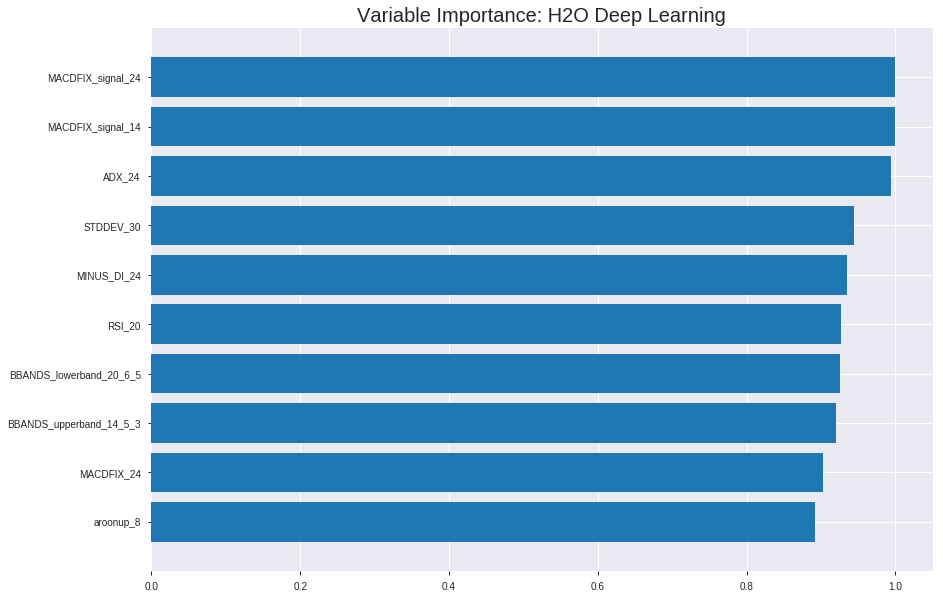

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190824_191555


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26439167533092917
RMSE: 0.5141903104210824
LogLoss: 0.7464713733315949
Mean Per-Class Error: 0.4495811119573496
AUC: 0.5702451014332203
pr_auc: 0.6670127855913888
Gini: 0.14049020286644054
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.02199742213015235: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    714   0.9986   (714.0/715.0)
1      0    1010  0        (0.0/1010.0)
Total  1    1724  0.4139   (714.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0219974    0.738844  398
max f2                       0.0219974    0.876128  398
max f0point5                 0.167995     0.646137  336
max accuracy                 0.167995     0.596522  336
max precision                0.99464      1         0
max recall                   0.0219974    1         398
max specificity              0.99464      1         0
max absolute_mcc             0.584608     0.114484  143
max min_per_class_accuracy   0.580455     0.402797  145
max mean_per_class_accuracy  0.424845     0.550419  206

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 50.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.971118           1.51815   1.51815            0.888889         0.983929  0.888889                    0.983929            0.0158416       0.0158416                  51.8152   51.8152
    2        0.0202899                   0.919489           1.40652   1.46393            0.823529         0.951207  0.857143                    0.968036            0.0138614       0.029703                   40.6523   46.3932
    3        0.0301449                   0.89508            1.40652   1.44516            0.823529         0.909715  0.846154                    0.948969            0.0138614       0.0435644                  40.6523   44.5164
    4        0.04                        0.870351           1.10513   1.36139            0.647059         0.88188   0.797101                    0.93244             0.0108911       0.0544554                  10.5125   36.1386
    5        0.0504348                   0.847226           1.42327   1.37419            0.833333         0.859595  0.804598                    0.917369            0.0148515       0.0693069                  42.3267   37.4189
    6        0.10029                     0.717435           1.19157   1.28341            0.697674         0.78772   0.751445                    0.852919            0.0594059       0.128713                   19.1573   28.3409
    7        0.150145                    0.608432           1.05256   1.20675            0.616279         0.663635  0.706564                    0.790068            0.0524752       0.181188                   5.25558   20.6755
    8        0.642899                    0.580454           1.00265   1.05032            0.587059         0.580851  0.614968                    0.629713            0.494059        0.675248                   0.264997  5.03174
    9        0.69971                     0.465528           1.06309   1.05135            0.622449         0.523356  0.615576                    0.621077            0.060396        0.735644                   6.30936   5.13547
    10       0.8                         0.2812             0.918131  1.03465            0.537572         0.370858  0.605797                    0.589709            0.0920792       0.827723                   -8.18692  3.46535
    11       0.89971                     0.17263            0.943328  1.02453            0.552326         0.22355   0.599871                    0.54913             0.0940594       0.921782                   -5.66717  2.45324
    12       1                           0.0159659          0.779918  1                  0.456647         0.11651   0.585507                    0.505742            0.0782178       1                          -22.0082  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.4314626756762023
RMSE: 0.6568581853613474
LogLoss: 4.726955096311499
Mean Per-Class Error: 0.4700115340253749
AUC: 0.5160713074156998
pr_auc: 0.424726376002119
Gini: 0.032142614831399685
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0022974070353236247: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00229741   0.73913    355
max f2                       0.00229741   0.876289   355
max f0point5                 0.00807061   0.6393     347
max accuracy                 0.00807061   0.586207   347
max precision                0.27149      0.617391   92
max recall                   0.00229741   1          355
max specificity              1            0.730392   0
max absolute_mcc             0.27149      0.0592116  92
max min_per_class_accuracy   0.229977     0.519608   111
max mean_per_class_accuracy  0.27149      0.529988   92

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 47.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.172414                    1                  1.06367   1.06367            0.623529         1          0.623529                    1                   0.183391        0.183391                   6.36678   6.36678
    2        0.200811                    1                  0.731092  1.01664            0.428571         1          0.59596                     1                   0.0207612       0.204152                   -26.8908  1.6637
    3        0.300203                    0.999984           1.07923   1.03736            0.632653         1          0.608108                    1                   0.107266        0.311419                   7.92317   3.73609
    4        0.399594                    0.731347           0.905162  1.00448            0.530612         0.928308   0.588832                    0.982168            0.0899654       0.401384                   -9.48379  0.447895
    5        0.501014                    0.231826           1.16      1.03596            0.68             0.40169    0.607287                    0.864662            0.117647        0.519031                   16        3.59609
    6        0.600406                    0.140501           0.905162  1.01431            0.530612         0.180197   0.594595                    0.751356            0.0899654       0.608997                   -9.48379  1.43084
    7        0.699797                    0.0827098          1.0096    1.01364            0.591837         0.111224   0.594203                    0.660438            0.100346        0.709343                   0.960384  1.36402
    8        0.799189                    0.0388251          0.97479   1.00881            0.571429         0.0598398  0.591371                    0.585745            0.0968858       0.806228                   -2.52101  0.88086
    9        0.89858                     0.0145273          0.905162  0.997344           0.530612         0.0241844  0.58465                     0.523631            0.0899654       0.896194                   -9.48379  -0.265569
    10       1                           0.00229741         1.02353   1                  0.6              0.0101498  0.586207                    0.471553            0.103806        1                          2.35294   0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 19:15:57  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 19:16:00  3.965 sec   1607 obs/sec      1         1             1725       0.574625         1.15697             -0.360566      0.546985        0.616107           1.2335           0.414493                         0.672713           6.33821               -0.865631        0.509762          0.370164             1.01287            0.401623
    2019-08-24 19:16:02  5.720 sec   6864 obs/sec      10        10            17250      0.51419          0.746471            -0.0894281     0.570245        0.667013           1.51815          0.413913                         0.656858           4.72696               -0.778726        0.516071          0.424726             1.06367            0.413793

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ----------------------
MACDFIX_signal_24         1.0                    1.0                  0.0017217724986336254
MACDFIX_signal_14         0.9997682571411133     0.9997682571411133   0.0017213734901524395
ADX_24                    0.9946645498275757     0.9946645498275757   0.0017125860672589153
STDDEV_30                 0.9450682997703552     0.9450682997703552   0.0016271926078750367
MINUS_DI_24               0.9353594779968262     0.9353594779968262   0.001610476225551239
---                       ---                    ---                  ---
WMA_8                     0.3201600909233093     0.3201600909233093   0.000551242839711795
VAR_12                    0.316262423992157      0.316262423992157    0.0005445319439809032
BBANDS_middleband_30_6_4  0.27915072441101074    0.27915072441101074  0.00048063404026453256
CMO_20                    0.26396444439888       0.26396444439888     0.00045448672098309634
TEMA_12                   0.20567670464515686    0.20567670464515686  0.0003541284936676219


See the whole table with table.as_data_frame()


('accuracy', 0.5263157894736842)

('F1', 0.6880000000000001)

('auc', 0.5011168046248851)

('logloss', 16.163354297876474)

('mean_per_class_error', 0.49540139272106165)

('rmse', 0.6908866793171862)

('mse', 0.4773244036579284)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


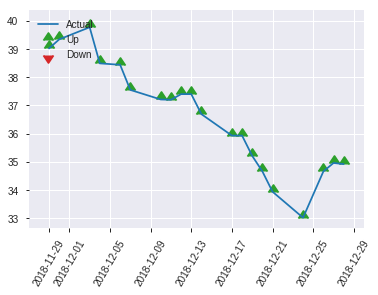


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4773244036579284
RMSE: 0.6908866793171862
LogLoss: 16.163354297876474
Mean Per-Class Error: 0.49540139272106165
AUC: 0.5011168046248851
pr_auc: 0.012160302458005562
Gini: 0.0022336092497701188
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05165385820210005: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    117  0.9915   (117.0/118.0)
1      0    129  0        (0.0/129.0)
Total  1    246  0.4737   (117.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0516539    0.688      5
max f2                       0.0516539    0.846457   5
max f0point5                 0.0516539    0.579515   5
max accuracy                 0.999779     0.526316   3
max precision                0.999779     0.52459    3
max recall                   0.0516539    1          5
max specificity              1            0.0254237  0
max absolute_mcc             0.0516539    0.0666632  5
max min_per_class_accuracy   1            0.0254237  0
max mean_per_class_accuracy  0.999779     0.504599   3

Gains/Lift Table: Avg response rate: 52.23 %, avg score: 99.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.97166                     1                  1.00523   1.00523            0.525            1         0.525                       1                   0.976744        0.976744                   0.523256  0.523256
    2        1                           0.0189181          0.820598  1                  0.428571         0.724294  0.522267                    0.992186            0.0232558       1                          -17.9402  0

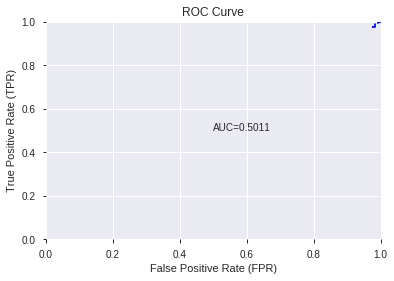

This function is available for GLM models only


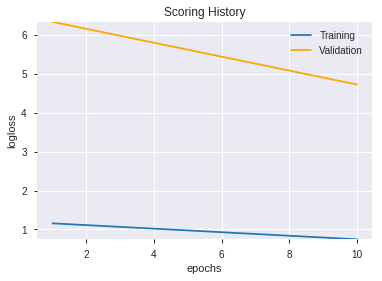

--2019-08-24 19:46:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  67.0MB/s    in 5.5s    

2019-08-24 19:47:03 (64.4 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190824_191555',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190824_191555',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_8405',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_2_sid_8405',


In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_194710_model_6  0.565202   3.124225              0.474576  0.625000  0.390624
1  DeepLearning_grid_1_AutoML_20190824_194710_model_9  0.503876   0.698208              0.500000  0.502481  0.252487
2  DeepLearning_grid_1_AutoML_20190824_194710_model_5  0.503876   0.702357              0.500000  0.504545  0.254566
3  DeepLearning_grid_1_AutoML_20190824_194710_model_4  0.503876   0.718382              0.500000  0.512288  0.262439
4  DeepLearning_grid_1_AutoML_20190824_194710_model_8  0.500000   0.699499              0.500000  0.503106  0.253116
5  DeepLearning_grid_1_AutoML_20190824_194710_model_2  0.499015  17.910785              0.500000  0.722409  0.521874
6               DeepLearning_1_AutoML_20190824_194710  0.499015  17.967201              0.500000  0.722681  0.522267
7  DeepLearning_grid_1_AutoML_20190824_194710_model_3  0.496124  16.425946              0.500000  0.691182  0.477733
8  DeepLearning_grid_1_AutoML_20190824_194710_model_1  0.494449  17.742106              0.500000  0.720035  0.518450
9  DeepLearning_grid_1_AutoML_20190824_194710_model_7  0.471193  13.821861              0.491164  0.684479  0.468511

variable  relative_importance  scaled_importance  percentage
0               weekday_name             1.000000           1.000000    0.031098
1                  STDDEV_24             0.840108           0.840108    0.026126
2          MACDFIX_signal_14             0.832040           0.832040    0.025875
3                       SINH             0.824755           0.824755    0.025648
4          MACDFIX_signal_24             0.811622           0.811622    0.025240
5                     ADX_24             0.804706           0.804706    0.025025
6                  STDDEV_30             0.772981           0.772981    0.024038
7           MACDFIX_signal_8             0.763535           0.763535    0.023744
8                    weekday             0.738760           0.738760    0.022974
9          LINEARREG_SLOPE_8             0.706524           0.706524    0.021971
10                MACDFIX_24             0.701189           0.701189    0.021806
11                    CCI_14             0.693624           0.693624    0.021570
12                 aroonup_8             0.690273           0.690273    0.021466
13               AROONOSC_24             0.679053           0.679053    0.021117
14                    ADX_12             0.677968           0.677968    0.021083
15                 PLUS_DM_8             0.666075           0.666075    0.020714
16   BBANDS_upperband_30_1_5             0.661108           0.661108    0.020559
17           MACDFIX_hist_12             0.656680           0.656680    0.020421
18                    RSI_20             0.643514           0.643514    0.020012
19               MINUS_DI_24             0.639037           0.639037    0.019873
20                     RSI_8             0.634913           0.634913    0.019745
21                   MA_20_3             0.624205           0.624205    0.019412
22               MINUS_DI_30             0.624145           0.624145    0.019410
23               MINUS_DI_12             0.610409           0.610409    0.018982
24                   ROCR_14             0.607857           0.607857    0.018903
25   BBANDS_upperband_12_7_4             0.607298           0.607298    0.018886
26   BBANDS_upperband_14_5_3             0.603910           0.603910    0.018780
27                    ROC_14             0.599815           0.599815    0.018653
28    BBANDS_upperband_8_2_2             0.592036           0.592036    0.018411
29   BBANDS_lowerband_12_4_3             0.589692           0.589692    0.018338
30  BBANDS_middleband_20_7_4             0.578925           0.578925    0.018003
31                  TRIMA_30             0.578720           0.578720    0.017997
32  BBANDS_middleband_12_7_5             0.578353           0.578353    0.017986
33                    MA_8_0             0.577885           0.577885    0.017971
34   BBANDS_upperband_14_0_5             0.573980           0.573980    0.017850
35   BBANDS_middleband_8_8_5             0.573164           0.573164    0.017824
36   BBANDS_lowerband_20_1_3             0.572529           0.572529    0.017804
37                ROCR100_24             0.572368           0.572368    0.017800
38                   KAMA_24             0.571603           0.571603    0.017776
39                 MAVP_20_3             0.570048           0.570048    0.017727
40   BBANDS_upperband_14_2_4             0.569605           0.569605    0.017714
41   BBANDS_middleband_8_4_5             0.568770           0.568770    0.017688
42  BBANDS_middleband_24_1_5             0.565326           0.565326    0.017580
43   BBANDS_lowerband_30_7_4             0.562791           0.562791    0.017502
44   BBANDS_lowerband_20_6_5             0.557707           0.557707    0.017344
45    BBANDS_lowerband_8_3_5             0.557326           0.557326    0.017332
46   BBANDS_lowerband_20_0_3             0.537757           0.537757    0.016723
47              LINEARREG_24             0.531382           0.531382    0.016525
48  BBANDS_middleband_24_5_5             0.530536  

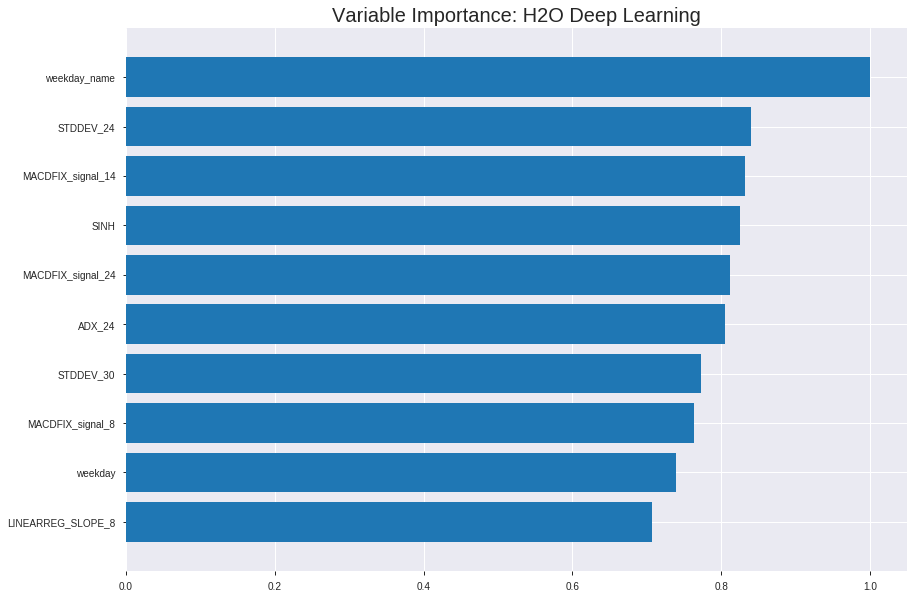

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_194710_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23615787550313047
RMSE: 0.48596077568372786
LogLoss: 0.6641940674695065
Mean Per-Class Error: 0.43226476493803223
AUC: 0.5823533891850723
pr_auc: 0.6713570591301969
Gini: 0.16470677837014458
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4805682471786538: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      16   699   0.9776   (699.0/715.0)
1      4    1006  0.004    (4.0/1010.0)
Total  20   1705  0.4075   (703.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.480568     0.741068  382
max f2                       0.39567      0.87628   397
max f0point5                 0.542473     0.648889  313
max accuracy                 0.515385     0.601739  348
max precision                0.935087     1         0
max recall                   0.39567      1         397
max specificity              0.935087     1         0
max absolute_mcc             0.629587     0.157348  164
max min_per_class_accuracy   0.584295     0.542657  240
max mean_per_class_accuracy  0.616903     0.567735  182

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 60.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104348                   0.853525           1.51815   1.51815            0.888889         0.899022  0.888889                    0.899022            0.0158416       0.0158416                  51.8152    51.8152
    2        0.0202899                   0.808304           1.40652   1.46393            0.823529         0.832665  0.857143                    0.866791            0.0138614       0.029703                   40.6523    46.3932
    3        0.0301449                   0.776448           1.30606   1.41232            0.764706         0.791702  0.826923                    0.842243            0.0128713       0.0425743                  30.6057    41.2319
    4        0.04                        0.763975           1.10513   1.33663            0.647059         0.769199  0.782609                    0.824247            0.0108911       0.0534653                  10.5125    33.6634
    5        0.0504348                   0.74821            1.42327   1.35456            0.833333         0.757541  0.793103                    0.810445            0.0148515       0.0683168                  42.3267    35.4558
    6        0.10029                     0.695178           1.35045   1.35252            0.790698         0.716488  0.791908                    0.763738            0.0673267       0.135644                   35.0449    35.2515
    7        0.150145                    0.659978           1.13199   1.27929            0.662791         0.677731  0.749035                    0.73518             0.0564356       0.192079                   13.1994    27.9292
    8        0.2                         0.641045           1.13199   1.24257            0.662791         0.651325  0.727536                    0.714277            0.0564356       0.248515                   13.1994    24.2574
    9        0.30029                     0.61332            1.02673   1.17049            0.601156         0.624481  0.685328                    0.684287            0.10297         0.351485                   2.6727     17.0486
    10       0.4                         0.597149           0.923469  1.10891            0.540698         0.604462  0.649275                    0.664389            0.0920792       0.443564                   -7.65312   10.8911
    11       0.50029                     0.58514            0.928003  1.07265            0.543353         0.590538  0.628042                    0.649585            0.0930693       0.536634                   -7.19968   7.26455
    12       0.609855                    0.576588           0.984991  1.0569             0.57672          0.579824  0.618821                    0.637052            0.107921        0.644554                   -1.50086   5.68978
    13       0.69971                     0.569554           0.991696  1.04852            0.580645         0.574643  0.613919                    0.629037            0.0891089       0.733663                   -0.830406  4.85247
    14       0.8                         0.550218           0.987237  1.04084            0.578035         0.560846  0.60942                     0.620489            0.0990099       0.832673                   -1.27625   4.08416
    15       0.89971                     0.523846           0.913539  1.02673            0.534884         0.537741  0.60116                     0.611318            0.0910891       0.923762                   -8.6461    2.67333
    16       1                           0.347853           0.760173  1                  0.445087         0.500565  0.585507                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24782293098710415
RMSE: 0.49781817060760664
LogLoss: 0.6908757972377543
Mean Per-Class Error: 0.45862168396770475
AUC: 0.5313962955424384
pr_auc: 0.6127884598283759
Gini: 0.06279259108487678
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12236053682882536: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.122361     0.73913    399
max f2                       0.122361     0.876289   399
max f0point5                 0.446276     0.642419   363
max accuracy                 0.446276     0.590264   363
max precision                0.84322      1          0
max recall                   0.122361     1          399
max specificity              0.84322      1          0
max absolute_mcc             0.548103     0.0861192  243
max min_per_class_accuracy   0.563987     0.509804   180
max mean_per_class_accuracy  0.548103     0.541378   243

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 55.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.800449           1.36471   1.36471            0.8              0.826804  0.8                         0.826804            0.0138408       0.0138408                  36.4706   36.4706
    2        0.020284                    0.773121           1.02353   1.19412            0.6              0.787834  0.7                         0.807319            0.0103806       0.0242215                  2.35294   19.4118
    3        0.030426                    0.753865           1.02353   1.13725            0.6              0.764981  0.666667                    0.793206            0.0103806       0.0346021                  2.35294   13.7255
    4        0.040568                    0.736753           0.682353  1.02353            0.4              0.747361  0.6                         0.781745            0.00692042      0.0415225                  -31.7647  2.35294
    5        0.0507099                   0.722721           1.36471   1.09176            0.8              0.729868  0.64                        0.771369            0.0138408       0.0553633                  36.4706   9.17647
    6        0.10142                     0.642597           1.16      1.12588            0.68             0.67497   0.66                        0.72317             0.0588235       0.114187                   16        12.5882
    7        0.150101                    0.59815            1.06618   1.10652            0.625            0.613976  0.648649                    0.687756            0.0519031       0.16609                    6.61765   10.6518
    8        0.200811                    0.579264           0.818824  1.03387            0.48             0.589049  0.606061                    0.66283             0.0415225       0.207612                   -18.1176  3.38681
    9        0.300203                    0.5751             1.21849   1.09499            0.714286         0.576187  0.641892                    0.634144            0.121107        0.32872                    21.8487   9.49921
    10       0.399594                    0.572047           0.765906  1.01314            0.44898          0.574092  0.593909                    0.619207            0.0761246       0.404844                   -23.4094  1.31383
    11       0.501014                    0.563997           1.02353   1.01524            0.6              0.568999  0.595142                    0.609043            0.103806        0.508651                   2.35294   1.52417
    12       0.600406                    0.556006           1.14886   1.03736            0.673469         0.560443  0.608108                    0.600998            0.114187        0.622837                   14.886    3.73609
    13       0.699797                    0.542467           0.97479   1.02847            0.571429         0.54911   0.602899                    0.593629            0.0968858       0.719723                   -2.52101  2.8474
    14       0.799189                    0.521804           0.905162  1.01314            0.530612         0.531881  0.593909                    0.585949            0.0899654       0.809689                   -9.48379  1.31383
    15       0.89858                     0.463437           0.939976  1.00505            0.55102          0.498038  0.589165                    0.576225            0.0934256       0.903114                   -6.0024   0.504581
    16       1                           0.122361           0.955294  1                  0.56             0.361153  0.586207                    0.554413         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 19:51:56  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 19:51:59  3 min  1.343 sec  994 obs/sec       1.40464   1             2423       0.533477         0.8517              -0.172685      0.535971        0.598486           0.948845         0.414493                         0.575266           2.6836                -0.364279        0.503833          0.503199             0.880455           0.413793
    2019-08-24 19:52:07  3 min  9.517 sec  2186 obs/sec      12.4864   9             21539      0.495855         0.686189            -0.0131179     0.53599         0.620834           1.42327          0.404058                         0.509596           0.735395              -0.0705774       0.508795          0.591169             1.02353            0.413793
    2019-08-24 19:52:15  3 min 17.493 sec  2673 obs/sec      26.3907   19            45524      0.491107         0.675824            0.00618912     0.560312        0.644401           1.51815          0.409275                         0.500474           0.698132              -0.0325903       0.50519           0.585344             0.682353           0.413793
    2019-08-24 19:52:23  3 min 25.768 sec  2923 obs/sec      41.6052   30            71769      0.485961         0.664194            0.0269095      0.582353        0.671357           1.51815          0.407536                         0.497818           0.690876              -0.0216622       0.531396          0.612788             1.36471            0.413793
    2019-08-24 19:52:31  3 min 33.644 sec  3095 obs/sec      56.84     41            98049      0.484029         0.659546            0.0346314      0.614887        0.693421           1.51815          0.393043                         0.578536           2.14941               -0.379833        0.503146          0.593975             1.02353            0.413793
    2019-08-24 19:52:39  3 min 41.627 sec  3198 obs/sec      72.1606   52            124477     0.48278          0.657392            0.0396058      0.625964        0.701934           1.61304          0.394783                         0.58333            2.12289               -0.402796        0.510389          0.598594             1.02353            0.413793
    2019-08-24 19:52:47  3 min 49.533 sec  3269 obs/sec      87.3849   63            150739     0.480933         0.652766            0.046939       0.648358        0.718245           1.61304          0.389565                         0.600614           2.83023               -0.487156        0.504011          0.601062             1.70588            0.413793
    2019-08-24 19:52:48  3 min 50.269 sec  3268 obs/sec      87.3849   63            150739     0.485961         0.664194            0.0269095      0.582353        0.671357           1.51815          0.407536                         0.497818           0.690876              -0.0216622       0.531396          0.612788             1.36471            0.413793

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
weekday_name              1.0                    1.0                  0.031097980733290842
STDDEV_24                 0.8401078581809998     0.8401078581809998   0.026125657987598968
MACDFIX_signal_14         0.8320398926734924     0.8320398926734924   0.02587476055168965
SINH                      0.8247551321983337     0.8247551321983337   0.025648219210786524
MACDFIX_signal_24         0.8116223812103271     0.8116223812103271   0.02523981717358639
---                       ---                    ---                  ---
BBANDS_lowerband_8_3_5    0.5573256015777588     0.5573256015777588   0.017331700820034872
BBANDS_lowerband_20_0_3   0.5377568006515503     0.5377568006515503   0.016723150625858035
LINEARREG_24              0.5313822627067566     0.5313822627067566   0.01652491536766721
BBANDS_middleband_24_5_5  0.5305360555648804     0.5305360555648804   0.01649860003427277
BBANDS_upperband_20_0_3   0.5298218131065369     0.5298218131065369   0.016476388536064306


See the whole table with table.as_data_frame()


('accuracy', 0.5748987854251012)

('F1', 0.6972972972972973)

('auc', 0.5652016817763763)

('logloss', 3.1242247496940942)

('mean_per_class_error', 0.4220536066219944)

('rmse', 0.6249995797839024)

('mse', 0.3906244747300546)

deeplearning prediction progress: |███████████████████████████████████████| 100%


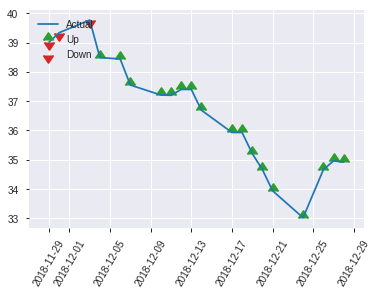


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3906244747300546
RMSE: 0.6249995797839024
LogLoss: 3.1242247496940942
Mean Per-Class Error: 0.4220536066219944
AUC: 0.5652016817763763
pr_auc: 0.5571043176172522
Gini: 0.13040336355275262
Confusion Matrix (Act/Pred) for max f1 @ threshold = 9.3706413201535e-15: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    112  0.9492   (112.0/118.0)
1      0    129  0        (0.0/129.0)
Total  6    241  0.4534   (112.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       9.37064e-15  0.697297  235
max f2                       9.37064e-15  0.852048  235
max f0point5                 0.04972      0.594354  130
max accuracy                 0.0521666    0.574899  128
max precision                0.498362     0.655172  23
max recall                   9.37064e-15  1         235
max specificity              0.576588     0.974576  0
max absolute_mcc             9.37064e-15  0.164976  235
max min_per_class_accuracy   0.075361     0.550388  118
max mean_per_class_accuracy  0.181749     0.577946  79

Gains/Lift Table: Avg response rate: 52.23 %, avg score: 16.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0242915                   0.576588           0.957364  0.957364           0.5              0.576588     0.5                         0.576588            0.0232558       0.0232558                  -4.26357   -4.26357
    2        0.0323887                   0.57297            0         0.718023           0                0.574701     0.375                       0.576116            0               0.0232558                  -100       -28.1977
    3        0.0404858                   0.570703           0.957364  0.765891           0.5              0.571158     0.4                         0.575124            0.00775194      0.0310078                  -4.26357   -23.4109
    4        0.0526316                   0.558922           1.91473   1.03101            1                0.5669       0.538462                    0.573226            0.0232558       0.0542636                  91.4729    3.10078
    5        0.101215                    0.510079           1.43605   1.22543            0.75             0.532596     0.64                        0.553724            0.0697674       0.124031                   43.6047    22.5426
    6        0.149798                    0.456064           0.957364  1.13849            0.5              0.489346     0.594595                    0.532845            0.0465116       0.170543                   -4.26357   13.8487
    7        0.202429                    0.379234           1.03101   1.11054            0.538462         0.421662     0.58                        0.503937            0.0542636       0.224806                   3.10078    11.0543
    8        0.299595                    0.245438           1.27649   1.16436            0.666667         0.314686     0.608108                    0.442558            0.124031        0.348837                   27.6486    16.4362
    9        0.40081                     0.142987           1.07225   1.1411             0.56             0.187399     0.59596                     0.378124            0.108527        0.457364                   7.22481    14.1101
    10       0.502024                    0.075361           0.91907   1.09634            0.48             0.117996     0.572581                    0.325679            0.0930233       0.550388                   -8.09302   9.63366
    11       0.59919                     0.020088           1.03714   1.08674            0.541667         0.0464613    0.567568                    0.2804              0.100775        0.651163                   3.71447    8.67379
    12       0.700405                    0.00287506         0.765891  1.04037            0.4              0.00941207   0.543353                    0.24124             0.0775194       0.728682                   -23.4109   4.03728
    13       0.797571                    4.31979e-05        0.877584  1.02054            0.458333         0.00109883   0.532995                    0.211984            0.0852713       0.813953                   -12.2416   2.05407
    14       0.898785                    2.99272e-09        0.842481  1.00049            0.44             8.98549e-06  0.522523                    0.188113            0.0852713       0.899225                   -15.7519   0.0488861
    15       1                           8.90996e-19        0.995659  1                  0.52             3.74241e-11  0.522267                    0.169073            0.100775        1                          -0.434109  0

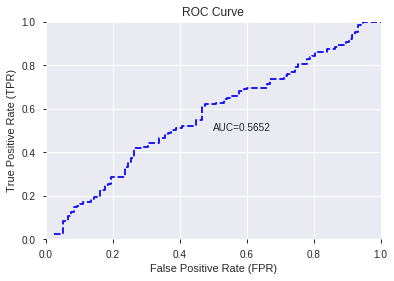

This function is available for GLM models only


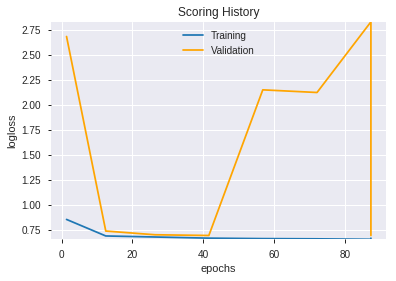

--2019-08-24 19:57:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_194710_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_194710_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_8405',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['weekday_name',
 'STDDEV_24',
 'MACDFIX_signal_14',
 'SINH',
 'MACDFIX_signal_24',
 'ADX_24',
 'STDDEV_30',
 'MACDFIX_signal_8',
 'weekday',
 'LINEARREG_SLOPE_8',
 'MACDFIX_24',
 'CCI_14',
 'aroonup_8',
 'AROONOSC_24',
 'ADX_12',
 'PLUS_DM_8',
 'BBANDS_upperband_30_1_5',
 'MACDFIX_hist_12',
 'RSI_20',
 'MINUS_DI_24',
 'RSI_8',
 'MA_20_3',
 'MINUS_DI_30',
 'MINUS_DI_12',
 'ROCR_14',
 'BBANDS_upperband_12_7_4',
 'BBANDS_upperband_14_5_3',
 'ROC_14',
 'BBANDS_upperband_8_2_2',
 'BBANDS_lowerband_12_4_3',
 'BBANDS_middleband_20_7_4',
 'TRIMA_30',
 'BBANDS_middleband_12_7_5',
 'MA_8_0',
 'BBANDS_upperband_14_0_5',
 'BBANDS_middleband_8_8_5',
 'BBANDS_lowerband_20_1_3',
 'ROCR100_24',
 'KAMA_24',
 'MAVP_20_3',
 'BBANDS_upperband_14_2_4',
 'BBANDS_middleband_8_4_5',
 'BBANDS_middleband_24_1_5',
 'BBANDS_lowerband_30_7_4',
 'BBANDS_lowerband_20_6_5',
 'BBANDS_lowerband_8_3_5',
 'BBANDS_lowerband_20_0_3',
 'LINEARREG_24',
 'BBANDS_middleband_24_5_5',
 'BBANDS_upperband_20_0_3']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_195729_model_1  0.541486  17.307283                   0.5  0.720095  0.518536

variable  relative_importance  scaled_importance  percentage
0                       SINH             0.007988           1.000000    0.089046
1               weekday_name             0.007133           0.892945    0.079513
2           MACDFIX_signal_8             0.005574           0.697794    0.062136
3                     ROC_14             0.005492           0.687559    0.061224
4                    ROCR_14             0.005490           0.687211    0.061193
5                 MACDFIX_24             0.005461           0.683602    0.060872
6          MACDFIX_signal_14             0.005164           0.646385    0.057558
7          MACDFIX_signal_24             0.004233           0.529953    0.047190
8                  PLUS_DM_8             0.002313           0.289591    0.025787
9                     RSI_20             0.002083           0.260742    0.023218
10               MINUS_DI_24             0.002077           0.259959    0.023148
11                    ADX_24             0.002068           0.258828    0.023048
12               MINUS_DI_30             0.001906           0.238540    0.021241
13           MACDFIX_hist_12             0.001805           0.225902    0.020116
14                ROCR100_24             0.001794           0.224597    0.019999
15                   weekday             0.001793           0.224486    0.019990
16               MINUS_DI_12             0.001398           0.174970    0.015580
17    BBANDS_lowerband_8_3_5             0.001356           0.169710    0.015112
18                 aroonup_8             0.001322           0.165476    0.014735
19   BBANDS_lowerband_12_4_3             0.001091           0.136599    0.012164
20                 STDDEV_30             0.001034           0.129434    0.011526
21              LINEARREG_24             0.000991           0.124024    0.011044
22   BBANDS_lowerband_20_6_5             0.000984           0.123205    0.010971
23   BBANDS_middleband_8_4_5             0.000961           0.120358    0.010717
24   BBANDS_middleband_8_8_5             0.000930           0.116482    0.010372
25                   MA_20_3             0.000929           0.116293    0.010355
26                 MAVP_20_3             0.000921           0.115349    0.010271
27                    MA_8_0             0.000912           0.114142    0.010164
28  BBANDS_middleband_12_7_5             0.000843           0.105531    0.009397
29  BBANDS_middleband_20_7_4             0.000837           0.104815    0.009333
30   BBANDS_lowerband_20_1_3             0.000837           0.104796    0.009332
31                 STDDEV_24             0.000816           0.102089    0.009091
32               AROONOSC_24             0.000814           0.101913    0.009075
33   BBANDS_lowerband_20_0_3             0.000808           0.101115    0.009004
34                    CCI_14             0.000806           0.100925    0.008987
35    BBANDS_upperband_8_2_2             0.000799           0.100038    0.008908
36         LINEARREG_SLOPE_8             0.000757           0.094776    0.008439
37   BBANDS_upperband_30_1_5             0.000726           0.090899    0.008094
38   BBANDS_upperband_14_2_4             0.000713           0.089257    0.007948
39   BBANDS_lowerband_30_7_4             0.000711           0.089035    0.007928
40   BBANDS_upperband_12_7_4             0.000708           0.088655    0.007894
41   BBANDS_upperband_14_5_3             0.000696           0.087078    0.007754
42                   KAMA_24             0.000676           0.084598    0.007533
43  BBANDS_middleband_24_1_5             0.000613           0.076717    0.006831
44   BBANDS_upperband_14_0_5             0.000600           0.075048    0.006683
45  BBANDS_middleband_24_5_5             0.000548           0.068557    0.006105
46                  TRIMA_30             0.000467           0.058471    0.005207
47   BBANDS_upperband_20_0_3             0.000437           0.054761    0.004876
48                    ADX_12             0.000158  

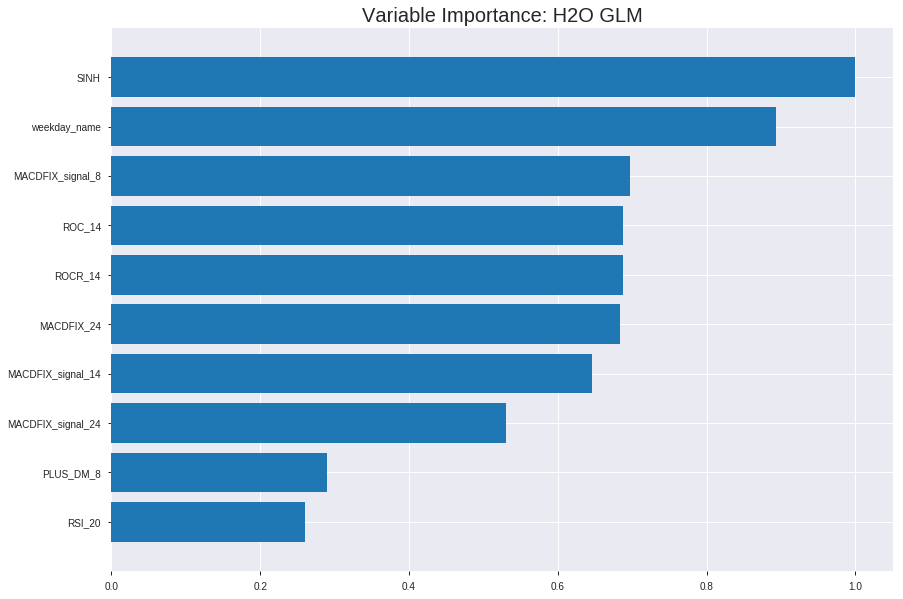

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_195729_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24216792981097227
RMSE: 0.4921056083921136
LogLoss: 0.6773821102987119
Null degrees of freedom: 1724
Residual degrees of freedom: 1674
Null deviance: 2340.659668736101
Residual deviance: 2336.968280530556
AIC: 2438.968280530556
AUC: 0.5408003877310807
pr_auc: 0.607723758742796
Gini: 0.08160077546216149
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5553786016644017: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    715   1        (715.0/715.0)
1      0    1010  0        (0.0/1010.0)
Total  0    1725  0.4145   (715.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.555379     0.738574  399
max f2                       0.555379     0.875976  399
max f0point5                 0.575944     0.646109  306
max accuracy                 0.575944     0.594203  306
max precision                0.624227     1         0
max recall                   0.555379     1         399
max specificity              0.624227     1         0
max absolute_mcc             0.576206     0.100055  303
max min_per_class_accuracy   0.584152     0.525874  219
max mean_per_class_accuracy  0.579161     0.539812  273

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 58.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104348                   0.612498           1.32838   1.32838            0.777778         0.616311  0.777778                    0.616311            0.0138614       0.0138614                  32.8383    32.8383
    2        0.0202899                   0.609093           1.00466   1.17115            0.588235         0.610612  0.685714                    0.613543            0.00990099      0.0237624                  0.465929   17.1146
    3        0.0301449                   0.606914           0.803727  1.05103            0.470588         0.60778   0.615385                    0.611659            0.00792079      0.0316832                  -19.6273   5.10282
    4        0.04                        0.605235           0.904193  1.01485            0.529412         0.606041  0.594203                    0.610275            0.00891089      0.0405941                  -9.58066   1.48515
    5        0.0504348                   0.6042             1.32838   1.07972            0.777778         0.604728  0.632184                    0.609127            0.0138614       0.0544554                  32.8383    7.972
    6        0.10029                     0.599894           0.913539  0.99711            0.534884         0.60183   0.583815                    0.6055              0.0455446       0.1                        -8.6461    -0.289017
    7        0.150145                    0.596828           1.01284   1.00233            0.593023         0.598238  0.586873                    0.603089            0.050495        0.150495                   1.28367    0.233189
    8        0.2                         0.593696           1.07242   1.0198             0.627907         0.595037  0.597101                    0.601082            0.0534653       0.20396                    7.24154    1.9802
    9        0.30029                     0.589854           1.17481   1.07157            0.687861         0.591656  0.627413                    0.597934            0.117822        0.321782                   17.4813    7.15719
    10       0.4                         0.586868           0.983047  1.0495             0.575581         0.588272  0.614493                    0.595525            0.0980198       0.419802                   -1.69526   4.9505
    11       0.50029                     0.584247           1.01685   1.04296            0.595376         0.585605  0.61066                     0.593537            0.10198         0.521782                   1.68546    4.29597
    12       0.6                         0.582266           1.06249   1.0462             0.622093         0.583267  0.61256                     0.59183             0.105941        0.627723                   6.24856    4.62046
    13       0.69971                     0.579949           1.02277   1.04286            0.598837         0.580995  0.610605                    0.590286            0.10198         0.729703                   2.27665    4.28646
    14       0.8                         0.577199           0.99711   1.03713            0.583815         0.578632  0.607246                    0.588825            0.1             0.829703                   -0.289017  3.71287
    15       0.89971                     0.573639           0.86389   1.01793            0.505814         0.575564  0.596005                    0.587355            0.0861386       0.915842                   -13.611    1.79296
    16       1                           0.555379           0.839152  1                  0.491329         0.568927  0.585507                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3552043536639365
RMSE: 0.5959902295037532
LogLoss: 2.8003692876500654
Null degrees of freedom: 492
Residual degrees of freedom: 442
Null deviance: 668.7154569489843
Residual deviance: 4048.182186939468
AIC: 4150.182186939468
AUC: 0.4988805210665581
pr_auc: 0.586678950422294
Gini: -0.002238957866883773
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.212005805093618e-07: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       3.21201e-07  0.73913    399
max f2                       3.21201e-07  0.876289   399
max f0point5                 3.21201e-07  0.639098   399
max accuracy                 3.21201e-07  0.586207   399
max precision                0.607141     1          0
max recall                   3.21201e-07  1          399
max specificity              0.607141     1          0
max absolute_mcc             0.605888     0.0759874  3
max min_per_class_accuracy   0.507223     0.512111   218
max mean_per_class_accuracy  0.51312      0.519464   208

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 35.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.605017           1.36471   1.36471            0.8              0.606129     0.8                         0.606129            0.0138408       0.0138408                  36.4706   36.4706
    2        0.020284                    0.597672           0.682353  1.02353            0.4              0.600605     0.6                         0.603367            0.00692042      0.0207612                  -31.7647  2.35294
    3        0.030426                    0.595327           1.02353   1.02353            0.6              0.596528     0.6                         0.601087            0.0103806       0.0311419                  2.35294   2.35294
    4        0.040568                    0.589876           0.682353  0.938235           0.4              0.593425     0.55                        0.599172            0.00692042      0.0380623                  -31.7647  -6.17647
    5        0.0507099                   0.586483           0.682353  0.887059           0.4              0.587866     0.52                        0.59691             0.00692042      0.0449827                  -31.7647  -11.2941
    6        0.10142                     0.57759            0.955294  0.921176           0.56             0.580987     0.54                        0.588949            0.0484429       0.0934256                  -4.47059  -7.88235
    7        0.150101                    0.574923           1.13725   0.991256           0.666667         0.576114     0.581081                    0.584786            0.0553633       0.148789                   13.7255   -0.874404
    8        0.200811                    0.570949           1.09176   1.01664            0.64             0.573121     0.59596                     0.581841            0.0553633       0.204152                   9.17647   1.6637
    9        0.300203                    0.56425            1.04442   1.02583            0.612245         0.567442     0.601351                    0.577074            0.103806        0.307958                   4.44178   2.58347
    10       0.399594                    0.551619           0.97479   1.01314            0.571429         0.558495     0.593909                    0.572452            0.0968858       0.404844                   -2.52101  1.31383
    11       0.501014                    0.506639           1.05765   1.02215            0.62             0.530705     0.59919                     0.564002            0.107266        0.512111                   5.76471   2.21481
    12       0.600406                    0.335285           0.80072   0.985493           0.469388         0.425835     0.577703                    0.541129            0.0795848       0.591696                   -19.928   -1.45072
    13       0.699797                    0.137088           0.97479   0.983973           0.571429         0.250037     0.576812                    0.499786            0.0968858       0.688581                   -2.52101  -1.60273
    14       0.799189                    0.0182055          1.11405   1.00015            0.653061         0.0681322    0.586294                    0.446103            0.110727        0.799308                   11.4046   0.0149298
    15       0.89858                     1.10482e-07        1.07923   1.0089             0.632653         0.00549031   0.591422                    0.397367            0.107266        0.906574                   7.92317   0.889656
    16       1                           6.60715e-68        0.921176  1                  0.54        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 19:57:30  0.000 sec   2            2.5       51            1.35476           8.21132
    2019-08-24 19:57:30  0.035 sec   3            1.6       51            1.35408           12.0033
    2019-08-24 19:57:30  0.096 sec   5            0.97      51            1.35323           17.6467
    2019-08-24 19:57:30  0.164 sec   7            0.6       51            1.3522            25.6035
    2019-08-24 19:57:30  0.184 sec   9            0.38      51            1.35099           36.2099

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5303643724696356)

('F1', 0.6861702127659575)

('auc', 0.5414860070949941)

('logloss', 17.30728307920532)

('mean_per_class_error', 0.4578242018131651)

('rmse', 0.7200945050841363)

('mse', 0.5185360962523672)

glm prediction progress: |████████████████████████████████████████████████| 100%


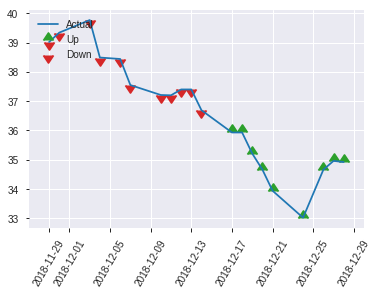


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5185360962523672
RMSE: 0.7200945050841363
LogLoss: 17.30728307920532
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 345.9465433426434
Residual deviance: 75796.16776766178
AIC: 75898.16776766178
AUC: 0.5414860070949941
pr_auc: 0.5672766867805474
Gini: 0.08297201418998812
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.5939179326214335e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       3.59392e-48  0.68617   63
max f2                       3.59392e-48  0.845347  63
max f0point5                 3.59392e-48  0.57744   63
max accuracy                 5.62445e-41  0.530364  60
max precision                0.495327     1         0
max recall                   3.59392e-48  1         63
max specificity              0.495327     1         0
max absolute_mcc             2.12844e-24  0.119409  35
max min_per_class_accuracy   1.04307e-45  0.294574  62
max mean_per_class_accuracy  2.12844e-24  0.542176  35

Gains/Lift Table: Avg response rate: 52.23 %, avg score:  0.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.0990728          1.27649   1.27649            0.666667         0.299307      0.666667                    0.299307            0.0155039       0.0155039                  27.6486    27.6486
    2        0.0202429                   0.0419387          0.957364  1.14884            0.5              0.0726301     0.6                         0.208636            0.00775194      0.0232558                  -4.26357   14.8837
    3        0.0323887                   0.000109289        0         0.718023           0                0.0188158     0.375                       0.137454            0               0.0232558                  -100       -28.1977
    4        0.0404858                   2.16355e-09        1.91473   0.957364           1                5.41489e-05   0.5                         0.109974            0.0155039       0.0387597                  91.4729    -4.26357
    5        0.0526316                   5.97565e-12        1.27649   1.03101            0.666667         9.92393e-10   0.538462                    0.0845952           0.0155039       0.0542636                  27.6486    3.10078
    6        0.101215                    7.33145e-20        1.43605   1.22543            0.75             1.64659e-13   0.64                        0.0439895           0.0697674       0.124031                   43.6047    22.5426
    7        0.149798                    6.48012e-26        1.27649   1.24199            0.666667         6.36747e-21   0.648649                    0.0297226           0.0620155       0.186047                   27.6486    24.1986
    8        0.202429                    3.27421e-31        0.883721  1.14884            0.461538         1.08872e-26   0.6                         0.0219947           0.0465116       0.232558                   -11.6279   14.8837
    9        0.299595                    7.02018e-54        1.19671   1.16436            0.625            3.91495e-33   0.608108                    0.0148613           0.116279        0.348837                   19.6705    16.4362
    10       0.40081                     6.1713e-73         1.07225   1.1411             0.56             2.11162e-55   0.59596                     0.0111085           0.108527        0.457364                   7.22481    14.1101
    11       0.502024                    4.50709e-97        0.995659  1.11178            0.52             1.54144e-74   0.580645                    0.00886885          0.100775        0.55814                    -0.434109  11.1778
    12       0.59919                     3.06943e-139       0.957364  1.08674            0.5              2.33903e-99   0.567568                    0.00743066          0.0930233       0.651163                   -4.26357   8.67379
    13       0.700405                    7.04131e-205       0.765891  1.04037            0.4              1.93897e-144  0.543353                    0.00635686          0.0775194       0.728682                   -23.4109   4.03728
    14       1                           0                  0.905615  1                  0.472973         1.73815e-210  0.522267                    0.00445238          0.271318        1                          -9.43851   0

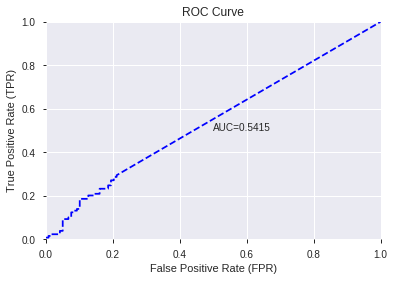

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


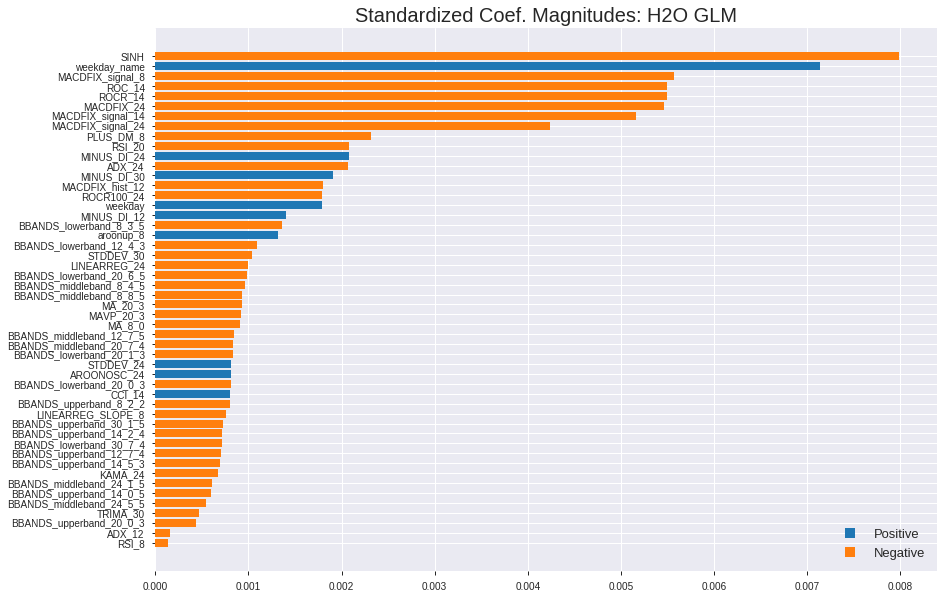

'log_likelihood'
--2019-08-24 19:57:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_195729_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_195729_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_8405',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['SINH',
 'weekday_name',
 'MACDFIX_signal_8',
 'ROC_14',
 'ROCR_14',
 'MACDFIX_24',
 'MACDFIX_signal_14',
 'MACDFIX_signal_24',
 'PLUS_DM_8',
 'RSI_20',
 'MINUS_DI_24',
 'ADX_24',
 'MINUS_DI_30',
 'MACDFIX_hist_12',
 'ROCR100_24',
 'weekday',
 'MINUS_DI_12',
 'BBANDS_lowerband_8_3_5',
 'aroonup_8',
 'BBANDS_lowerband_12_4_3',
 'STDDEV_30',
 'LINEARREG_24',
 'BBANDS_lowerband_20_6_5',
 'BBANDS_middleband_8_4_5',
 'BBANDS_middleband_8_8_5',
 'MA_20_3',
 'MAVP_20_3',
 'MA_8_0',
 'BBANDS_middleband_12_7_5',
 'BBANDS_middleband_20_7_4',
 'BBANDS_lowerband_20_1_3',
 'STDDEV_24',
 'AROONOSC_24',
 'BBANDS_lowerband_20_0_3',
 'CCI_14',
 'BBANDS_upperband_8_2_2',
 'LINEARREG_SLOPE_8',
 'BBANDS_upperband_30_1_5',
 'BBANDS_upperband_14_2_4',
 'BBANDS_lowerband_30_7_4',
 'BBANDS_upperband_12_7_4',
 'BBANDS_upperband_14_5_3',
 'KAMA_24',
 'BBANDS_middleband_24_1_5',
 'BBANDS_upperband_14_0_5',
 'BBANDS_middleband_24_5_5',
 'TRIMA_30',
 'BBANDS_upperband_20_0_3',
 'ADX_12',
 'RSI_8']

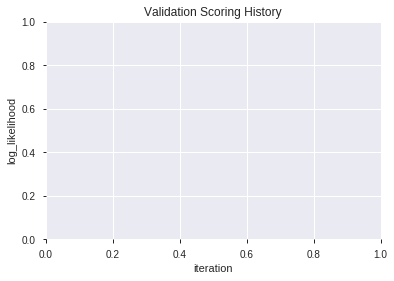

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_195740_model_1  0.520037  0.792584              0.500000  0.542395  0.294193
1  XGBoost_grid_1_AutoML_20190824_195740_model_2  0.502956  0.702456              0.478452  0.504594  0.254615
2  XGBoost_grid_1_AutoML_20190824_195740_model_4  0.496420  0.707051              0.500000  0.506612  0.256656
3  XGBoost_grid_1_AutoML_20190824_195740_model_6  0.486861  0.781629              0.500000  0.538883  0.290395
4  XGBoost_grid_1_AutoML_20190824_195740_model_5  0.484825  0.929567              0.500000  0.586399  0.343863
5               XGBoost_3_AutoML_20190824_195740  0.480489  0.740616              0.491164  0.522023  0.272508
6               XGBoost_1_AutoML_20190824_195740  0.464492  0.742973              0.500000  0.522931  0.273457
7  XGBoost_grid_1_AutoML_20190824_195740_model_3  0.459894  0.809150              0.495763  0.549258  0.301684
8  XGBoost_grid_1_AutoML_20190824_195740_model_7  0.459072  0.747797              0.495401  0.525001  0.275626
9               XGBoost_2_AutoML_20190824_195740  0.439627  0.732336              0.500000  0.518610  0.268956

variable  relative_importance  scaled_importance  percentage
0                 PLUS_DM_8           238.099228           1.000000    0.080798
1         MACDFIX_signal_24           188.752396           0.792747    0.064053
2               MINUS_DI_30           153.471619           0.644570    0.052080
3                    ROC_14           145.421677           0.610761    0.049349
4                    ADX_12           133.427612           0.560387    0.045278
5                    ADX_24           127.765259           0.536605    0.043357
6         MACDFIX_signal_14           118.311981           0.496902    0.040149
7         LINEARREG_SLOPE_8           111.624168           0.468814    0.037879
8                ROCR100_24           110.981445           0.466114    0.037661
9                   weekday           109.066048           0.458070    0.037011
10                STDDEV_24            94.482048           0.396818    0.032062
11          MACDFIX_hist_12            93.902092           0.394382    0.031865
12  BBANDS_upperband_12_7_4            87.361099           0.366910    0.029646
13                STDDEV_30            86.949036           0.365180    0.029506
14              MINUS_DI_24            80.500931           0.338098    0.027318
15              AROONOSC_24            75.210297           0.315878    0.025522
16                    RSI_8            71.483795           0.300227    0.024258
17              MINUS_DI_12            70.368149           0.295541    0.023879
18  BBANDS_upperband_14_0_5            69.936508           0.293728    0.023733
19  BBANDS_lowerband_20_6_5            63.857388           0.268197    0.021670
20               MACDFIX_24            61.784832           0.259492    0.020967
21                   CCI_14            58.195103           0.244415    0.019748
22  BBANDS_lowerband_30_7_4            54.778683           0.230067    0.018589
23  BBANDS_middleband_8_8_5            53.210381           0.223480    0.018057
24                  MA_20_3            52.311119           0.219703    0.017752
25  BBANDS_upperband_20_0_3            43.893452           0.184349    0.014895
26  BBANDS_upperband_30_1_5            42.689682           0.179294    0.014487
27                MAVP_20_3            41.432430           0.174013    0.014060
28   BBANDS_lowerband_8_3_5            37.834862           0.158904    0.012839
29  BBANDS_middleband_8_4_5            36.087570           0.151565    0.012246
30                   MA_8_0            33.845291           0.142148    0.011485
31                  KAMA_24            32.243279           0.135420    0.010942
32             weekday_name            29.828310           0.125277    0.010122
33  BBANDS_upperband_14_5_3            26.321777           0.110550    0.008932
34                  ROCR_14            23.420025           0.098362    0.007948
35  BBANDS_lowerband_20_0_3            15.140785           0.063590    0.005138
36             LINEARREG_24            13.307165           0.055889    0.004516
37         MACDFIX_signal_8            12.775221           0.053655    0.004335
38   BBANDS_upperband_8_2_2            11.392679           0.047848    0.003866
39                   RSI_20            10.028095           0.042117    0.003403
40  BBANDS_upperband_14_2_4             9.208834           0.038676    0.003125
41                     SINH             8.580676           0.036038    0.002912
42  BBANDS_lowerband_12_4_3             3.279403           0.013773    0.001113
43                 TRIMA_30             2.632151           0.011055    0.000893
44                aroonup_8             1.633987           0.006863    0.000554

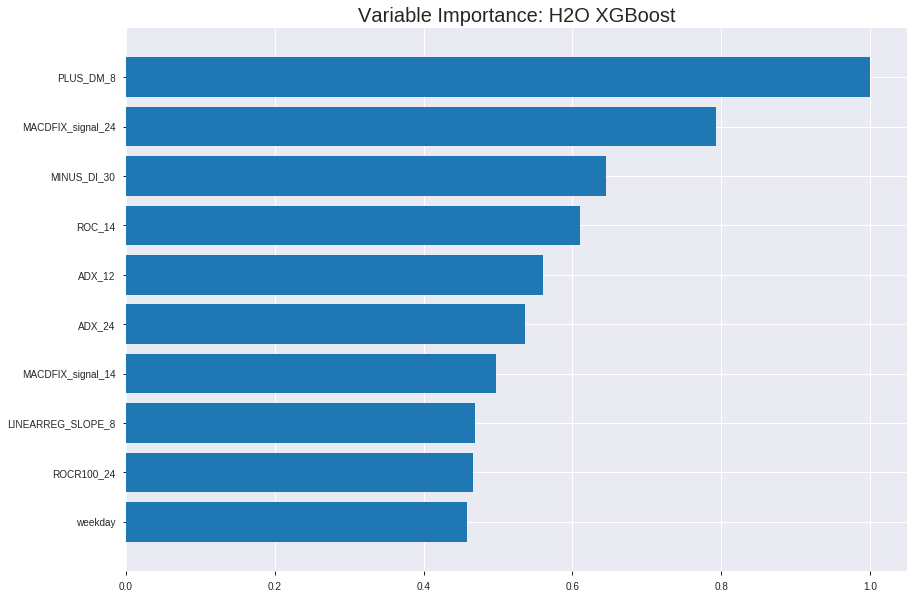

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_195740_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.20297683103244185
RMSE: 0.450529500734904
LogLoss: 0.5953470226876137
Mean Per-Class Error: 0.24267119019594263
AUC: 0.8420577442359621
pr_auc: 0.8858696390204869
Gini: 0.6841154884719243
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5491889317830404: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      377  338   0.4727   (338.0/715.0)
1      98   912   0.097    (98.0/1010.0)
Total  475  1250  0.2528   (436.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.549189     0.80708   231
max f2                       0.451903     0.893207  320
max f0point5                 0.597448     0.816404  165
max accuracy                 0.575379     0.763478  198
max precision                0.852348     1         0
max recall                   0.3955       1         357
max specificity              0.852348     1         0
max absolute_mcc             0.59611      0.511524  167
max min_per_class_accuracy   0.583215     0.735664  185
max mean_per_class_accuracy  0.59611      0.757329  167

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 57.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.768943           1.70792   1.70792            1                0.791022  1                           0.791022            0.0178218       0.0178218                  70.7921   70.7921
    2        0.0202899                   0.749205           1.70792   1.70792            1                0.756231  1                           0.774124            0.0168317       0.0346535                  70.7921   70.7921
    3        0.0301449                   0.738082           1.70792   1.70792            1                0.744492  1                           0.764437            0.0168317       0.0514851                  70.7921   70.7921
    4        0.04                        0.724678           1.60745   1.68317            0.941176         0.731269  0.985507                    0.756265            0.0158416       0.0673267                  60.7455   68.3168
    5        0.0504348                   0.712496           1.70792   1.68829            1                0.718634  0.988506                    0.748479            0.0178218       0.0851485                  70.7921   68.829
    6        0.10029                     0.675747           1.64834   1.66843            0.965116         0.693947  0.976879                    0.721371            0.0821782       0.167327                   64.8342   66.8431
    7        0.150145                    0.651551           1.70792   1.68154            1                0.662275  0.984556                    0.701748            0.0851485       0.252475                   70.7921   68.1544
    8        0.2                         0.639065           1.50933   1.63861            0.883721         0.64472   0.95942                     0.687533            0.0752475       0.327723                   50.9325   63.8614
    9        0.30029                     0.61528            1.46111   1.57933            0.855491         0.627144  0.92471                     0.667364            0.146535        0.474257                   46.1111   57.9332
    10       0.4                         0.600777           1.33059   1.51733            0.77907          0.608083  0.888406                    0.652587            0.132673        0.606931                   33.0589   51.7327
    11       0.50029                     0.587559           1.01685   1.417              0.595376         0.594421  0.829664                    0.640927            0.10198         0.708911                   1.68546   41.7
    12       0.6                         0.575424           1.00291   1.34818            0.587209         0.582016  0.789372                    0.631137            0.1             0.808911                   0.290698  34.8185
    13       0.69971                     0.556895           0.744733  1.26219            0.436047         0.567418  0.739022                    0.622057            0.0742574       0.883168                   -25.5267  26.2192
    14       0.8                         0.521361           0.562725  1.1745             0.32948          0.541062  0.687681                    0.611903            0.0564356       0.939604                   -43.7275  17.4505
    15       0.89971                     0.461099           0.466699  1.09606            0.273256         0.492959  0.641753                    0.598721            0.0465347       0.986139                   -53.3301  9.60626
    16       1                           0.210338           0.138213  1                  0.0809249        0.399982  0.585507                    0.57879             0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.29929213373951513
RMSE: 0.5470759853434577
LogLoss: 0.8021316276234832
Mean Per-Class Error: 0.4697231833910035
AUC: 0.5093798765180813
pr_auc: 0.6144430642085253
Gini: 0.018759753036162508
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19048327207565308: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    199  0.9755   (199.0/204.0)
1      1    288  0.0035   (1.0/289.0)
Total  6    487  0.4057   (200.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.190483     0.742268  393
max f2                       0.190483     0.876446  393
max f0point5                 0.190483     0.643719  393
max accuracy                 0.190483     0.59432   393
max precision                0.71202      1         0
max recall                   0.169517     1         399
max specificity              0.71202      1         0
max absolute_mcc             0.61816      0.105021  25
max min_per_class_accuracy   0.334575     0.480969  212
max mean_per_class_accuracy  0.581279     0.530277  55

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 37.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.689631           1.70588   1.70588            1                0.69681   1                           0.69681             0.017301        0.017301                   70.5882   70.5882
    2        0.020284                    0.654892           0.682353  1.19412            0.4              0.670159  0.7                         0.683485            0.00692042      0.0242215                  -31.7647  19.4118
    3        0.030426                    0.640716           1.36471   1.25098            0.8              0.646523  0.733333                    0.671164            0.0138408       0.0380623                  36.4706   25.098
    4        0.040568                    0.629551           1.36471   1.27941            0.8              0.637128  0.75                        0.662655            0.0138408       0.0519031                  36.4706   27.9412
    5        0.0507099                   0.622164           1.36471   1.29647            0.8              0.626887  0.76                        0.655502            0.0138408       0.0657439                  36.4706   29.6471
    6        0.10142                     0.590214           1.16      1.22824            0.68             0.605481  0.72                        0.630491            0.0588235       0.124567                   16        22.8235
    7        0.150101                    0.561023           0.852941  1.10652            0.5              0.57952   0.648649                    0.61396             0.0415225       0.16609                    -14.7059  10.6518
    8        0.200811                    0.494286           0.887059  1.0511             0.52             0.534038  0.616162                    0.593778            0.0449827       0.211073                   -11.2941  5.10992
    9        0.300203                    0.424571           0.97479   1.02583            0.571429         0.457772  0.601351                    0.548749            0.0968858       0.307958                   -2.52101  2.58347
    10       0.40568                     0.358539           0.852941  0.980882           0.5              0.389439  0.575                       0.507328            0.0899654       0.397924                   -14.7059  -1.91176
    11       0.501014                    0.333764           0.907384  0.966897           0.531915         0.341783  0.566802                    0.475828            0.0865052       0.484429                   -9.26158  -3.31031
    12       0.600406                    0.31255            1.11405   0.991256           0.653061         0.323288  0.581081                    0.450576            0.110727        0.595156                   11.4046   -0.874404
    13       0.699797                    0.289585           1.0096    0.993862           0.591837         0.299492  0.582609                    0.429118            0.100346        0.695502                   0.960384  -0.613811
    14       0.799189                    0.275977           1.14886   1.01314            0.673469         0.28319   0.593909                    0.41097             0.114187        0.809689                   14.886    1.31383
    15       0.89858                     0.24114            0.939976  1.00505            0.55102          0.257971  0.589165                    0.394047            0.0934256       0.903114                   -6.0024   0.504581
    16       1                           0.169517           0.955294  1                  0.56             0.216086  0.586207                    0.375998   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 19:57:53  0.020 sec   0                  0.5              0.693147            0.5             0                  1                0.414493                         0.5                0.693147              0.5               0                    1                  0.413793
    2019-08-24 19:57:53  0.089 sec   5                  0.49065          0.674567            0.667279        0.723066           1.70792          0.348406                         0.50453            0.702274              0.490484          0.576149             0.682353           0.411765
    2019-08-24 19:57:53  0.133 sec   10                 0.483929         0.661279            0.709817        0.775148           1.70792          0.338551                         0.508355           0.710136              0.499372          0.583635             0.487395           0.407708
    2019-08-24 19:57:53  0.180 sec   15                 0.477916         0.649438            0.736924        0.802793           1.70792          0.314783                         0.507872           0.709174              0.513154          0.595723             1.02353            0.409736
    2019-08-24 19:57:53  0.229 sec   20                 0.473113         0.639942            0.75211         0.813521           1.70792          0.304928                         0.511566           0.716964              0.516241          0.603074             1.02353            0.409736
    2019-08-24 19:57:53  0.280 sec   25                 0.468724         0.631283            0.783076        0.838217           1.61304          0.297971                         0.51825            0.731446              0.515452          0.604259             1.36471            0.411765
    2019-08-24 19:57:53  0.332 sec   30                 0.46521          0.624294            0.79866         0.85171            1.70792          0.297391                         0.526458           0.749949              0.513044          0.607777             1.36471            0.411765
    2019-08-24 19:57:53  0.388 sec   35                 0.461406         0.616764            0.815541        0.866304           1.70792          0.282319                         0.531407           0.761747              0.516165          0.614246             1.36471            0.411765
    2019-08-24 19:57:53  0.447 sec   40                 0.456971         0.608035            0.827267        0.875009           1.70792          0.266667                         0.535147           0.77101               0.511907          0.61211              1.70588            0.409736
    2019-08-24 19:57:53  0.493 sec   45                 0.453837         0.601866            0.834525        0.880371           1.70792          0.26029                          0.543062           0.791045              0.511212          0.611754             1.70588            0.403651
    2019-08-24 19:57:53  0.555 sec   50                 0.45053          0.595347            0.842058        0.88587            1.70792          0.252754                         0.547076           0.802132              0.50938           0.614443             1.70588            0.40568

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
PLUS_DM_8                238.09922790527344     1.0                   0.08079846604876192
MACDFIX_signal_24        188.7523956298828      0.792746777427506     0.06405272358124177
MINUS_DI_30              153.47161865234375     0.6445699971501027    0.05208026703078314
ROC_14                   145.4216766357422      0.6107608072278061    0.04934853634671032
ADX_12                   133.4276123046875      0.5603865811684656    0.04527837615272203
---                      ---                    ---                   ---
BBANDS_upperband_14_2_4  9.208833694458008      0.0386764534075755    0.003124998107538511
SINH                     8.580676078796387      0.036038235630945284  0.002911834158084215
BBANDS_lowerband_12_4_3  3.2794032096862793     0.013773262679335412  0.001112858496976962
TRIMA_30                 2.6321513652801514     0.011054850485812324  0.0008932149616520463
aroonup_8                1.6339874267578125     0.006862632193867869  0.0005544901543213736


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5425101214574899)

('F1', 0.6861702127659575)

('auc', 0.5200367888582316)

('logloss', 0.7925840456778243)

('mean_per_class_error', 0.44954670871107605)

('rmse', 0.5423953440156731)

('mse', 0.2941927092098804)

xgboost prediction progress: |████████████████████████████████████████████| 100%


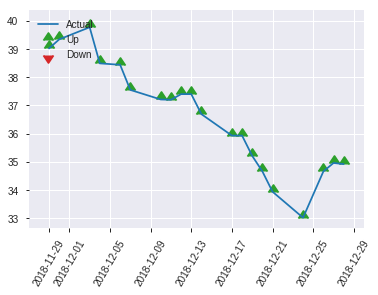


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2941927092098804
RMSE: 0.5423953440156731
LogLoss: 0.7925840456778243
Mean Per-Class Error: 0.44954670871107605
AUC: 0.5200367888582316
pr_auc: 0.5395877856885757
Gini: 0.04007357771646314
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1693178117275238: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.169318     0.68617   223
max f2                       0.169318     0.845347  223
max f0point5                 0.169318     0.57744   223
max accuracy                 0.334322     0.54251   73
max precision                0.56781      1         0
max recall                   0.169318     1         223
max specificity              0.56781      1         0
max absolute_mcc             0.477979     0.122708  3
max min_per_class_accuracy   0.308034     0.534884  111
max mean_per_class_accuracy  0.334322     0.550453  73

Gains/Lift Table: Avg response rate: 52.23 %, avg score: 32.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.478804           1.91473   1.91473            1                0.520871  1                           0.520871            0.0232558       0.0232558                  91.4729    91.4729
    2        0.0242915                   0.476873           0.638243  1.27649            0.333333         0.477241  0.666667                    0.499056            0.00775194      0.0310078                  -36.1757   27.6486
    3        0.0323887                   0.470187           0         0.957364           0                0.473011  0.5                         0.492545            0               0.0310078                  -100       -4.26357
    4        0.0404858                   0.465907           0         0.765891           0                0.467817  0.4                         0.487599            0               0.0310078                  -100       -23.4109
    5        0.0526316                   0.458205           0         0.589147           0                0.462978  0.307692                    0.481917            0               0.0310078                  -100       -41.0853
    6        0.101215                    0.433024           1.27649   0.91907            0.666667         0.449285  0.48                        0.466254            0.0620155       0.0930233                  27.6486    -8.09302
    7        0.149798                    0.383493           1.27649   1.03499            0.666667         0.411259  0.540541                    0.448418            0.0620155       0.155039                   27.6486    3.49885
    8        0.202429                    0.369664           1.47287   1.14884            0.769231         0.37537   0.6                         0.429425            0.0775194       0.232558                   47.2868    14.8837
    9        0.299595                    0.338823           0.957364  1.08674            0.5              0.351172  0.567568                    0.404046            0.0930233       0.325581                   -4.26357   8.67379
    10       0.40081                     0.318831           1.07225   1.08308            0.56             0.327391  0.565657                    0.384688            0.108527        0.434109                   7.22481    8.30789
    11       0.502024                    0.307074           0.995659  1.06545            0.52             0.312253  0.556452                    0.370085            0.100775        0.534884                   -0.434109  6.54539
    12       0.59919                     0.298358           0.957364  1.04793            0.5              0.302262  0.547297                    0.359086            0.0930233       0.627907                   -4.26357   4.79258
    13       0.700405                    0.291067           0.842481  1.01824            0.44             0.294412  0.531792                    0.34974             0.0852713       0.713178                   -15.7519   1.82372
    14       0.797571                    0.279398           0.718023  0.981663           0.375            0.285246  0.51269                     0.341883            0.0697674       0.782946                   -28.1977   -1.83371
    15       0.898785                    0.249343           1.07225   0.991864           0.56             0.265773  0.518018                    0.333312            0.108527        0.891473                   7.22481    -0.813604
    16       1                           0.169318           1.07225   1                  0.56             0.20454   0.522267             

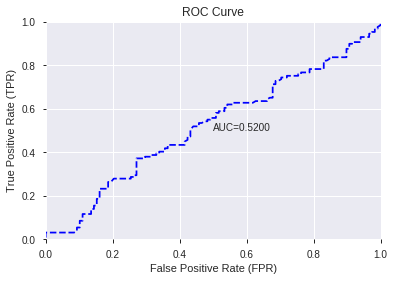

This function is available for GLM models only


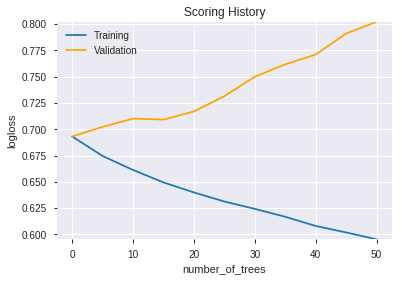

--2019-08-24 19:58:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_195740_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_195740_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_8405',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['PLUS_DM_8',
 'MACDFIX_signal_24',
 'MINUS_DI_30',
 'ROC_14',
 'ADX_12',
 'ADX_24',
 'MACDFIX_signal_14',
 'LINEARREG_SLOPE_8',
 'ROCR100_24',
 'weekday',
 'STDDEV_24',
 'MACDFIX_hist_12',
 'BBANDS_upperband_12_7_4',
 'STDDEV_30',
 'MINUS_DI_24',
 'AROONOSC_24',
 'RSI_8',
 'MINUS_DI_12',
 'BBANDS_upperband_14_0_5',
 'BBANDS_lowerband_20_6_5',
 'MACDFIX_24',
 'CCI_14',
 'BBANDS_lowerband_30_7_4',
 'BBANDS_middleband_8_8_5',
 'MA_20_3',
 'BBANDS_upperband_20_0_3',
 'BBANDS_upperband_30_1_5',
 'MAVP_20_3',
 'BBANDS_lowerband_8_3_5',
 'BBANDS_middleband_8_4_5',
 'MA_8_0',
 'KAMA_24',
 'weekday_name',
 'BBANDS_upperband_14_5_3',
 'ROCR_14',
 'BBANDS_lowerband_20_0_3',
 'LINEARREG_24',
 'MACDFIX_signal_8',
 'BBANDS_upperband_8_2_2',
 'RSI_20',
 'BBANDS_upperband_14_2_4',
 'SINH',
 'BBANDS_lowerband_12_4_3',
 'TRIMA_30',
 'aroonup_8']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_195809_model_1  0.522697  17.625458                   0.5  0.720883  0.519672

variable  relative_importance  scaled_importance    percentage
0               weekday_name         7.101164e-03           1.000000  1.844983e-02
1              days_in_month         6.464107e-03           0.910288  1.679466e-02
2                        EXP         6.304008e-03           0.887743  1.637871e-02
3                       SINH         6.287812e-03           0.885462  1.633662e-02
4                       COSH         6.285311e-03           0.885110  1.633013e-02
..                       ...                  ...                ...           ...
964  BBANDS_lowerband_12_2_3         5.297627e-07           0.000075  1.376398e-06
965  BBANDS_lowerband_24_2_2         5.179554e-07           0.000073  1.345721e-06
966  BBANDS_upperband_14_6_3         4.831476e-07           0.000068  1.255286e-06
967  BBANDS_lowerband_14_5_5         4.805648e-07           0.000068  1.248575e-06
968                  KAMA_20         4.802417e-08           0.000007  1.247736e-07

[969 rows x 4 columns]

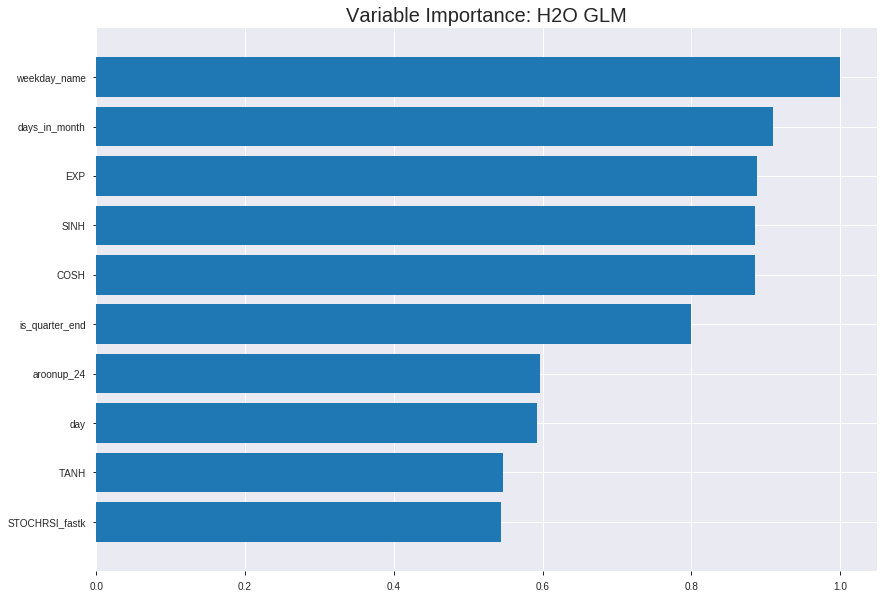

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_195809_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24123105205494147
RMSE: 0.49115277873075447
LogLoss: 0.675455996955622
Null degrees of freedom: 1724
Residual degrees of freedom: 755
Null deviance: 2340.659668736101
Residual deviance: 2330.323189496896
AIC: 4270.323189496896
AUC: 0.5612642802741813
pr_auc: 0.624312732009251
Gini: 0.12252856054836259
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5197625721753903: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    714   0.9986   (714.0/715.0)
1      0    1010  0        (0.0/1010.0)
Total  1    1724  0.4139   (714.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.519763     0.738844  398
max f2                       0.519763     0.876128  398
max f0point5                 0.574826     0.648366  267
max accuracy                 0.573491     0.593623  274
max precision                0.666036     1         0
max recall                   0.519763     1         398
max specificity              0.666036     1         0
max absolute_mcc             0.577038     0.132252  254
max min_per_class_accuracy   0.584023     0.541259  212
max mean_per_class_accuracy  0.577038     0.563193  254

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 58.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.638391           1.2335    1.2335             0.722222         0.649588  0.722222                    0.649588            0.0128713       0.0128713                  23.3498   23.3498
    2        0.0202899                   0.632871           1.00466   1.12235            0.588235         0.635657  0.657143                    0.642821            0.00990099      0.0227723                  0.465929  12.2348
    3        0.0301449                   0.629505           1.00466   1.08387            0.588235         0.631127  0.634615                    0.638998            0.00990099      0.0326733                  0.465929  8.38728
    4        0.04                        0.625228           1.00466   1.06436            0.588235         0.627369  0.623188                    0.636133            0.00990099      0.0425743                  0.465929  6.43564
    5        0.0504348                   0.6226             1.13861   1.07972            0.666667         0.62352   0.632184                    0.633523            0.0118812       0.0544554                  13.8614   7.972
    6        0.10029                     0.611317           1.01284   1.04647            0.593023         0.61619   0.612717                    0.624907            0.050495        0.10495                    1.28367   4.64717
    7        0.150145                    0.604445           1.01284   1.0353             0.593023         0.607509  0.606178                    0.61913             0.050495        0.155446                   1.28367   3.53033
    8        0.2                         0.599639           1.23129   1.08416            0.72093          0.601821  0.634783                    0.614815            0.0613861       0.216832                   23.1292   8.41584
    9        0.30029                     0.592564           1.10571   1.09135            0.647399         0.595916  0.638996                    0.608504            0.110891        0.327723                   10.5706   9.13548
    10       0.4                         0.588286           1.0327    1.07673            0.604651         0.59036   0.630435                    0.603981            0.10297         0.430693                   3.26963   7.67327
    11       0.50029                     0.584279           1.04647   1.07067            0.612717         0.58623   0.626883                    0.600422            0.10495         0.535644                   4.64717   7.06665
    12       0.6                         0.580413           1.05256   1.06766            0.616279         0.582373  0.625121                    0.597423            0.10495         0.640594                   5.25558   6.76568
    13       0.69971                     0.575472           1.08235   1.06975            0.633721         0.577991  0.626346                    0.594654            0.107921        0.748515                   8.23452   6.97499
    14       0.8                         0.570334           0.78979   1.03465            0.462428         0.572926  0.605797                    0.59193             0.0792079       0.827723                   -21.021   3.46535
    15       0.89971                     0.562741           0.834101  1.01243            0.488372         0.567027  0.592784                    0.58917             0.0831683       0.910891                   -16.5899  1.24273
    16       1                           0.519203           0.888514  1                  0.520231         0.552647  0.585507                    0.585507           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.38694541114657044
RMSE: 0.6220493639146096
LogLoss: 4.298040456299502
Null degrees of freedom: 492
Residual degrees of freedom: -477
Null deviance: 668.7154569489843
Residual deviance: 9046.176182834904
AIC: 10986.176182834904
AUC: 0.49955051224642105
pr_auc: 0.5905703706507858
Gini: -0.0008989755071578953
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.4825610096971248e-08: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.48256e-08  0.73913    399
max f2                       2.48256e-08  0.876289   399
max f0point5                 2.48256e-08  0.639098   399
max accuracy                 2.48256e-08  0.586207   399
max precision                0.604565     0.6875     15
max recall                   2.48256e-08  1          399
max specificity              0.638069     0.995098   0
max absolute_mcc             0.562064     0.0613216  80
max min_per_class_accuracy   0.413551     0.512111   244
max mean_per_class_accuracy  0.562064     0.523068   80

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 30.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.621455           1.02353   1.02353            0.6              0.634771     0.6                         0.634771            0.0103806       0.0103806                  2.35294   2.35294
    2        0.020284                    0.610678           1.02353   1.02353            0.6              0.61488      0.6                         0.624826            0.0103806       0.0207612                  2.35294   2.35294
    3        0.030426                    0.604783           1.36471   1.13725            0.8              0.607173     0.666667                    0.618942            0.0138408       0.0346021                  36.4706   13.7255
    4        0.040568                    0.596343           0.341176  0.938235           0.2              0.602038     0.55                        0.614716            0.00346021      0.0380623                  -65.8824  -6.17647
    5        0.0507099                   0.586513           1.36471   1.02353            0.8              0.588966     0.6                         0.609566            0.0138408       0.0519031                  36.4706   2.35294
    6        0.10142                     0.572462           1.09176   1.05765            0.64             0.577175     0.62                        0.59337             0.0553633       0.107266                   9.17647   5.76471
    7        0.150101                    0.565126           1.06618   1.06041            0.625            0.569144     0.621622                    0.585513            0.0519031       0.15917                    6.61765   6.04134
    8        0.200811                    0.558633           0.955294  1.03387            0.56             0.561231     0.606061                    0.579381            0.0484429       0.207612                   -4.47059  3.38681
    9        0.300203                    0.544271           1.0096    1.02583            0.591837         0.551621     0.601351                    0.57019             0.100346        0.307958                   0.960384  2.58347
    10       0.399594                    0.515849           0.870348  0.98716            0.510204         0.530568     0.57868                     0.560335            0.0865052       0.394464                   -12.9652  -1.28397
    11       0.501014                    0.412285           1.16      1.02215            0.68             0.466753     0.59919                     0.541391            0.117647        0.512111                   16        2.21481
    12       0.600406                    0.115122           0.80072   0.985493           0.469388         0.262316     0.577703                    0.495193            0.0795848       0.591696                   -19.928   -1.45072
    13       0.699797                    0.00882048         0.97479   0.983973           0.571429         0.0556026    0.576812                    0.432758            0.0968858       0.688581                   -2.52101  -1.60273
    14       0.799189                    5.33485e-05        1.11405   1.00015            0.653061         0.00196888   0.586294                    0.379183            0.110727        0.799308                   11.4046   0.0149298
    15       0.89858                     3.19466e-17        1.07923   1.0089             0.632653         1.13335e-05  0.591422                    0.337243            0.107266        0.906574                   7.92317   0.889656
    16       1                           1.25366e-159       0.921176  1                  0.54          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 19:58:12  0.000 sec   2            2.5       970           1.35091           18.3492
    2019-08-24 19:58:14  1.909 sec   4            1.8       970           1.34972           23.6982
    2019-08-24 19:58:16  3.628 sec   6            1.3       970           1.34832           30.339
    2019-08-24 19:58:18  5.330 sec   8            0.97      970           1.34667           38.0809
    2019-08-24 19:58:19  7.050 sec   10           0.71      970           1.34478           46.3161

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5222672064777328)

('F1', 0.6861702127659575)

('auc', 0.5226974116410459)

('logloss', 17.625457612009324)

('mean_per_class_error', 0.47612008934437)

('rmse', 0.7208825561800967)

('mse', 0.5196716598047503)

glm prediction progress: |████████████████████████████████████████████████| 100%


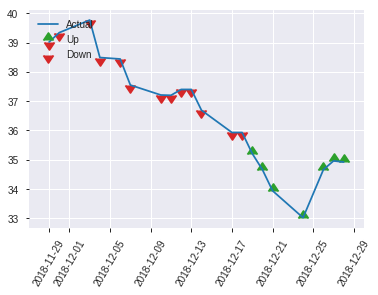


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5196716598047503
RMSE: 0.7208825561800967
LogLoss: 17.625457612009324
Null degrees of freedom: 246
Residual degrees of freedom: -723
Null deviance: 345.9465433426434
Residual deviance: 112766.91560674446
AIC: 114706.91560674446
AUC: 0.5226974116410459
pr_auc: 0.5750744491856398
Gini: 0.04539482328209177
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.2232635510111756e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       6.22326e-49  0.68617    25
max f2                       6.22326e-49  0.845347   25
max f0point5                 6.22326e-49  0.57744    25
max accuracy                 6.22326e-49  0.522267   25
max precision                0.400026     1          0
max recall                   6.22326e-49  1          25
max specificity              0.400026     1          0
max absolute_mcc             2.30108e-35  0.0810485  17
max min_per_class_accuracy   1.00457e-45  0.124031   24
max mean_per_class_accuracy  1.00457e-45  0.52388    24

Gains/Lift Table: Avg response rate: 52.23 %, avg score:  0.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.00358334         1.27649   1.27649            0.666667         0.163384      0.666667                    0.163384            0.0155039       0.0155039                  27.6486    27.6486
    2        0.0202429                   0.000420591        0.957364  1.14884            0.5              0.00199123    0.6                         0.0988272           0.00775194      0.0232558                  -4.26357   14.8837
    3        0.0323887                   2.75324e-10        0         0.718023           0                0.00014639    0.375                       0.0618219           0               0.0232558                  -100       -28.1977
    4        0.0404858                   2.10266e-21        1.91473   0.957364           1                1.32756e-10   0.5                         0.0494575           0.0155039       0.0387597                  91.4729    -4.26357
    5        0.0526316                   2.69237e-27        1.27649   1.03101            0.666667         7.22866e-22   0.538462                    0.0380442           0.0155039       0.0542636                  27.6486    3.10078
    6        0.101215                    4.79895e-46        1.43605   1.22543            0.75             4.35222e-30   0.64                        0.019783            0.0697674       0.124031                   43.6047    22.5426
    7        0.149798                    4.83103e-60        1.27649   1.24199            0.666667         1.1513e-47    0.648649                    0.0133669           0.0620155       0.186047                   27.6486    24.1986
    8        0.202429                    7.37942e-73        0.883721  1.14884            0.461538         1.33462e-61   0.6                         0.0098915           0.0465116       0.232558                   -11.6279   14.8837
    9        0.299595                    2.66964e-126       1.19671   1.16436            0.625            3.20602e-76   0.608108                    0.00668345          0.116279        0.348837                   19.6705    16.4362
    10       0.40081                     2.20115e-171       1.07225   1.1411             0.56             2.34534e-128  0.59596                     0.00499571          0.108527        0.457364                   7.22481    14.1101
    11       0.502024                    1.51376e-228       0.995659  1.11178            0.52             5.76671e-174  0.580645                    0.00398851          0.100775        0.55814                    -0.434109  11.1778
    12       1                           0                  0.887313  1                  0.463415         7.44615e-233  0.522267                    0.00200233          0.44186         1                          -11.2687   0

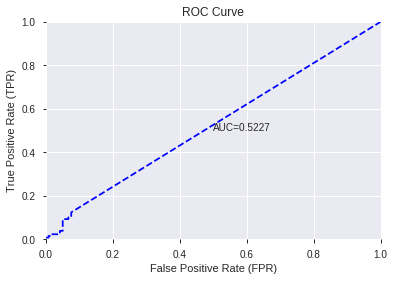

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


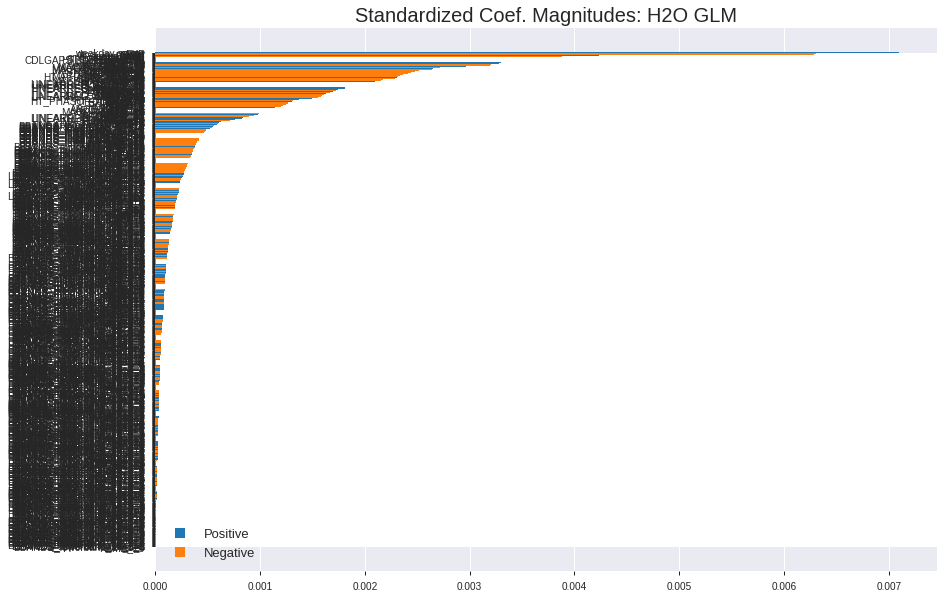

'log_likelihood'
--2019-08-24 19:58:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.24
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.24|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_195809_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_195809_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_8405',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

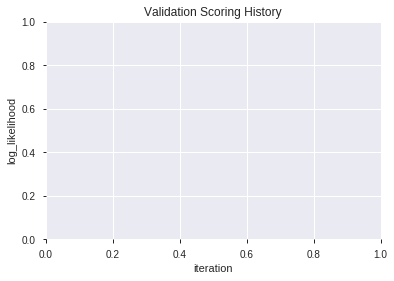

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_195843_model_6  0.516818  0.729165              0.500000  0.515686  0.265932
1  XGBoost_grid_1_AutoML_20190824_195843_model_1  0.505814  0.751809              0.491525  0.525490  0.276140
2  XGBoost_grid_1_AutoML_20190824_195843_model_4  0.490146  0.701989              0.500000  0.504320  0.254339
3  XGBoost_grid_1_AutoML_20190824_195843_model_7  0.489292  0.731457              0.500000  0.517457  0.267761
4  XGBoost_grid_1_AutoML_20190824_195843_model_2  0.488175  0.706816              0.500000  0.506594  0.256637
5               XGBoost_3_AutoML_20190824_195843  0.485416  0.723981              0.491525  0.514504  0.264715
6               XGBoost_1_AutoML_20190824_195843  0.484036  0.726175              0.495763  0.515497  0.265737
7  XGBoost_grid_1_AutoML_20190824_195843_model_5  0.480160  0.751487              0.500000  0.525387  0.276031
8  XGBoost_grid_1_AutoML_20190824_195843_model_3  0.469255  0.771300              0.486565  0.534593  0.285790
9               XGBoost_2_AutoML_20190824_195843  0.458547  0.735462              0.500000  0.519784  0.270175

variable  relative_importance  scaled_importance  percentage
0    HT_PHASOR_quadrature           192.185867           1.000000    0.029371
1                  MOM_30           110.277672           0.573807    0.016853
2                   MOM_8            94.500702           0.491715    0.014442
3                STDDEV_8            88.878609           0.462462    0.013583
4                  MOM_14            84.570770           0.440047    0.012924
..                    ...                  ...                ...         ...
265                ATR_14             3.168373           0.016486    0.000484
266                  mama             3.001508           0.015618    0.000459
267    LINEARREG_ANGLE_12             2.797572           0.014557    0.000428
268               DEMA_12             2.062745           0.010733    0.000315
269     LINEARREG_SLOPE_8             1.300416           0.006766    0.000199

[270 rows x 4 columns]

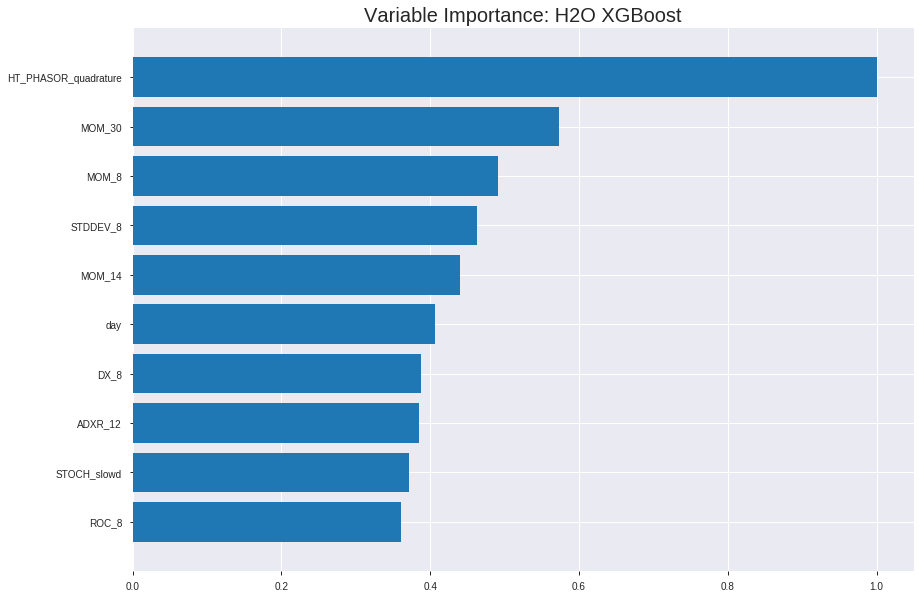

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_195843_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17910790911632923
RMSE: 0.4232114236600062
LogLoss: 0.545745057567497
Mean Per-Class Error: 0.13114311431143122
AUC: 0.9426573426573427
pr_auc: 0.9560374909536655
Gini: 0.8853146853146854
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5563758730888366: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      570  145   0.2028   (145.0/715.0)
1      75   935   0.0743   (75.0/1010.0)
Total  645  1080  0.1275   (220.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.556376     0.894737  213
max f2                       0.513091     0.931869  253
max f0point5                 0.590301     0.905116  177
max accuracy                 0.568679     0.873043  200
max precision                0.805167     1         0
max recall                   0.397806     1         347
max specificity              0.805167     1         0
max absolute_mcc             0.568679     0.737998  200
max min_per_class_accuracy   0.577674     0.865734  192
max mean_per_class_accuracy  0.573731     0.868857  196

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 57.94 %



group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ----------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.757745           1.70792     1.70792            1                0.773523  1                           0.773523            0.0178218       0.0178218                  70.7921   70.7921
    2        0.0202899                   0.748774           1.70792     1.70792            1                0.753925  1                           0.764004            0.0168317       0.0346535                  70.7921   70.7921
    3        0.0301449                   0.739691           1.70792     1.70792            1                0.743711  1                           0.75737             0.0168317       0.0514851                  70.7921   70.7921
    4        0.04                        0.729715           1.70792     1.70792            1                0.734496  1                           0.751734            0.0168317       0.0683168                  70.7921   70.7921
    5        0.0504348                   0.721995           1.70792     1.70792            1                0.726654  1                           0.746545            0.0178218       0.0861386                  70.7921   70.7921
    6        0.10029                     0.701415           1.68806     1.69805            0.988372         0.71143   0.99422                     0.729089            0.0841584       0.170297                   68.8061   69.8048
    7        0.150145                    0.683269           1.68806     1.69473            0.988372         0.692451  0.992278                    0.716924            0.0841584       0.254455                   68.8061   69.4732
    8        0.2                         0.669208           1.68806     1.69307            0.988372         0.675603  0.991304                    0.706623            0.0841584       0.338614                   68.8061   69.3069
    9        0.30029                     0.644226           1.61907     1.66836            0.947977         0.657149  0.976834                    0.6901              0.162376        0.50099                    61.9069   66.8355
    10       0.4                         0.618619           1.57883     1.64604            0.924419         0.631175  0.963768                    0.675411            0.157426        0.658416                   57.8834   64.604
    11       0.50029                     0.593815           1.41175     1.59907            0.82659          0.60604   0.936269                    0.661505            0.141584        0.8                        41.175    59.9073
    12       0.6                         0.56534            1.00291     1.5                0.587209         0.580609  0.878261                    0.648062            0.1             0.9                        0.290698  50
    13       0.69971                     0.529983           0.635505    1.37681            0.372093         0.547742  0.806131                    0.633766            0.0633663       0.963366                   -36.4495  37.6808
    14       0.8                         0.49403            0.266554    1.23762            0.156069         0.512157  0.724638                    0.618521            0.0267327       0.990099                   -73.3446  23.7624
    15       0.89971                     0.43931            0.0893679   1.11037            0.0523256        0.469716  0.650129                    0.602029            0.00891089      0.99901                    -91.0632  11.0369
    16       1                           0.216904           0.00987237  1                  0.00578035       0.376702  0.585507       



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2783190439020079
RMSE: 0.5275595169286664
LogLoss: 0.7527231915663345
Mean Per-Class Error: 0.47563437139561704
AUC: 0.5038503290589592
pr_auc: 0.5879052608571604
Gini: 0.007700658117918424
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25682568550109863: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   191  0.9363   (191.0/204.0)
1      5    284  0.0173   (5.0/289.0)
Total  18   475  0.3976   (196.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.256826     0.743455  382
max f2                       0.226815     0.877886  396
max f0point5                 0.256826     0.648698  382
max accuracy                 0.256826     0.602434  382
max precision                0.700396     1         0
max recall                   0.226815     1         396
max specificity              0.700396     1         0
max absolute_mcc             0.256826     0.121907  382
max min_per_class_accuracy   0.411729     0.484429  205
max mean_per_class_accuracy  0.268834     0.524366  373

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 42.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.672897           1.36471   1.36471            0.8              0.686737  0.8                         0.686737            0.0138408       0.0138408                  36.4706   36.4706
    2        0.020284                    0.642549           0.682353  1.02353            0.4              0.666587  0.6                         0.676662            0.00692042      0.0207612                  -31.7647  2.35294
    3        0.030426                    0.623471           0.341176  0.796078           0.2              0.631545  0.466667                    0.661623            0.00346021      0.0242215                  -65.8824  -20.3922
    4        0.040568                    0.616784           0.682353  0.767647           0.4              0.620512  0.45                        0.651345            0.00692042      0.0311419                  -31.7647  -23.2353
    5        0.0507099                   0.603832           1.02353   0.818824           0.6              0.609767  0.48                        0.64303             0.0103806       0.0415225                  2.35294   -18.1176
    6        0.10142                     0.560487           1.22824   1.02353            0.72             0.580948  0.6                         0.611989            0.0622837       0.103806                   22.8235   2.35294
    7        0.150101                    0.53262            1.06618   1.03736            0.625            0.542856  0.608108                    0.589567            0.0519031       0.155709                   6.61765   3.73609
    8        0.200811                    0.51242            0.955294  1.01664            0.56             0.523278  0.59596                     0.572828            0.0484429       0.204152                   -4.47059  1.6637
    9        0.300203                    0.470052           1.0096    1.01431            0.591837         0.490638  0.594595                    0.545616            0.100346        0.304498                   0.960384  1.43084
    10       0.399594                    0.438414           0.905162  0.98716            0.530612         0.452535  0.57868                     0.522464            0.0899654       0.394464                   -9.48379  -1.28397
    11       0.501014                    0.410634           0.921176  0.973803           0.54             0.422732  0.57085                     0.502276            0.0934256       0.487889                   -7.88235  -2.61967
    12       0.600406                    0.386094           0.939976  0.968203           0.55102          0.397791  0.567568                    0.484979            0.0934256       0.581315                   -6.0024   -3.17965
    13       0.699797                    0.360275           1.21849   1.00375            0.714286         0.370613  0.588406                    0.468736            0.121107        0.702422                   21.8487   0.375107
    14       0.799189                    0.338844           1.04442   1.00881            0.612245         0.349427  0.591371                    0.453898            0.103806        0.806228                   4.44178   0.88086
    15       0.89858                     0.297864           1.04442   1.01275            0.612245         0.318655  0.593679                    0.438939            0.103806        0.910035                   4.44178   1.27473
    16       1                           0.182769           0.887059  1                  0.52             0.264488  0.586207                    0.421246   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 19:59:16  19.279 sec  0                  0.5              0.693147            0.5             0                  1                0.414493                         0.5                0.693147              0.5               0                    1                  0.413793
    2019-08-24 19:59:16  19.872 sec  5                  0.487257         0.667907            0.730405        0.776545           1.62252          0.31942                          0.503956           0.701113              0.495488          0.572749             0.284314           0.413793
    2019-08-24 19:59:16  20.019 sec  10                 0.477194         0.648275            0.800745        0.835352           1.70792          0.257391                         0.509131           0.711716              0.478263          0.574732             1.42157            0.413793
    2019-08-24 19:59:16  20.182 sec  15                 0.468011         0.630502            0.842677        0.874746           1.70792          0.224928                         0.508457           0.710408              0.501018          0.577479             1.36471            0.409736
    2019-08-24 19:59:17  20.345 sec  20                 0.459478         0.614088            0.872731        0.901546           1.70792          0.201159                         0.508985           0.711471              0.504927          0.57591              1.36471            0.397566
    2019-08-24 19:59:17  20.493 sec  25                 0.452637         0.601023            0.891958        0.91673            1.70792          0.177971                         0.510478           0.714596              0.500221          0.572518             1.02353            0.391481
    2019-08-24 19:59:17  20.643 sec  30                 0.446358         0.589038            0.906729        0.929133           1.70792          0.164058                         0.519091           0.733003              0.498355          0.576992             1.02353            0.401623
    2019-08-24 19:59:17  20.817 sec  35                 0.440428         0.577841            0.916588        0.933753           1.70792          0.16                             0.52262            0.740965              0.501136          0.577623             1.02353            0.399594
    2019-08-24 19:59:17  20.980 sec  40                 0.434798         0.567197            0.926967        0.943906           1.70792          0.14029                          0.523933           0.744145              0.501018          0.583705             1.36471            0.399594
    2019-08-24 19:59:17  21.139 sec  45                 0.429078         0.55656             0.935328        0.950191           1.70792          0.132754                         0.530604           0.759766              0.50586           0.587908             1.02353            0.399594
    2019-08-24 19:59:18  21.307 sec  50                 0.423211         0.545745            0.942657        0.956037           1.70792          0.127536                         0.52756            0.752723              0.50385           0.587905             1.36471            0.397566

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ----------------------
HT_PHASOR_quadrature  192.1858673095703      1.0                   0.029370657198689854
MOM_30                110.27767181396484     0.5738073946734653    0.016853100287027682
MOM_8                 94.50070190429688      0.4917151465257144    0.014441997008010311
STDDEV_8              88.87860870361328      0.46246173013569647   0.01358280494332856
MOM_14                84.57077026367188      0.44004677059550096   0.012924462850550973
---                   ---                    ---                   ---
ATR_14                3.168372631072998      0.016485981385766662  0.00048420410786533457
mama                  3.0015082359313965     0.015617736506590305  0.00045870318515452786
LINEARREG_ANGLE_12    2.797572135925293      0.014556596565027348  0.0004275368076910445
DEMA_12               2.0627453327178955     0.010733075025726289  0.0003152374672684261
LINEARREG_SLOPE_8     1.300416111946106      0.006766450260629279  0.00019873509105692815


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5506072874493927)

('F1', 0.6861702127659575)

('auc', 0.5168177637629747)

('logloss', 0.7291650697793686)

('mean_per_class_error', 0.4457692813033767)

('rmse', 0.5156862909010935)

('mse', 0.2659323506233272)

xgboost prediction progress: |████████████████████████████████████████████| 100%


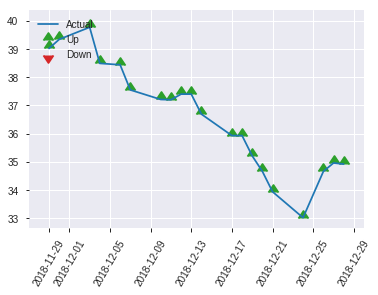


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2659323506233272
RMSE: 0.5156862909010935
LogLoss: 0.7291650697793686
Mean Per-Class Error: 0.4457692813033767
AUC: 0.5168177637629747
pr_auc: 0.5499803573231689
Gini: 0.03363552752594945
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18170076608657837: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.181701     0.68617   246
max f2                       0.181701     0.845347  246
max f0point5                 0.181701     0.57744   246
max accuracy                 0.454331     0.550607  103
max precision                0.607127     1         0
max recall                   0.181701     1         246
max specificity              0.607127     1         0
max absolute_mcc             0.254698     0.129283  232
max min_per_class_accuracy   0.439075     0.51938   119
max mean_per_class_accuracy  0.454331     0.554231  103

Gains/Lift Table: Avg response rate: 52.23 %, avg score: 42.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.585108           1.91473   1.91473            1                0.600401  1                           0.600401            0.0232558       0.0232558                  91.4729    91.4729
    2        0.0202429                   0.580622           0.957364  1.53178            0.5              0.582312  0.8                         0.593165            0.00775194      0.0310078                  -4.26357   53.1783
    3        0.0323887                   0.576544           0         0.957364           0                0.578166  0.5                         0.58754             0               0.0310078                  -100       -4.26357
    4        0.0404858                   0.560396           0         0.765891           0                0.575285  0.4                         0.585089            0               0.0310078                  -100       -23.4109
    5        0.0526316                   0.555874           1.27649   0.883721           0.666667         0.557227  0.461538                    0.57866             0.0155039       0.0465116                  27.6486    -11.6279
    6        0.101215                    0.529928           1.59561   1.22543            0.833333         0.539915  0.64                        0.560062            0.0775194       0.124031                   59.5607    22.5426
    7        0.149798                    0.510775           0.797804  1.08674            0.416667         0.516928  0.567568                    0.546073            0.0387597       0.162791                   -20.2196   8.67379
    8        0.202429                    0.501514           1.17829   1.11054            0.615385         0.506611  0.58                        0.535812            0.0620155       0.224806                   17.8295    11.0543
    9        0.299595                    0.475845           1.11693   1.11261            0.583333         0.488793  0.581081                    0.520563            0.108527        0.333333                   11.6925    11.2613
    10       0.40081                     0.45764            1.07225   1.10242            0.56             0.4669    0.575758                    0.507012            0.108527        0.44186                    7.22481    10.242
    11       0.502024                    0.434548           0.765891  1.03457            0.4              0.447096  0.540323                    0.494932            0.0775194       0.51938                    -23.4109   3.45711
    12       0.59919                     0.420697           0.718023  0.983239           0.375            0.427434  0.513514                    0.483986            0.0697674       0.589147                   -28.1977   -1.67609
    13       0.700405                    0.404073           1.14884   1.00717            0.6              0.4142    0.526012                    0.473902            0.116279        0.705426                   14.8837    0.716942
    14       0.797571                    0.356228           0.797804  0.981663           0.416667         0.383459  0.51269                     0.462883            0.0775194       0.782946                   -20.2196   -1.83371
    15       0.898785                    0.287621           0.995659  0.983239           0.52             0.326071  0.513514                    0.447476            0.100775        0.883721                   -0.434109  -1.67609
    16       1                           0.181701           1.14884   1                  0.6              0.25303   0.522267              

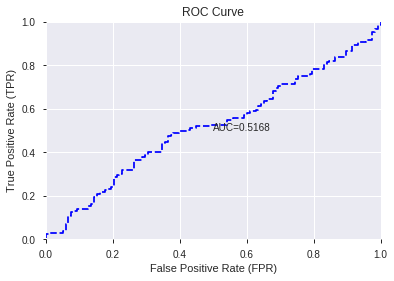

This function is available for GLM models only


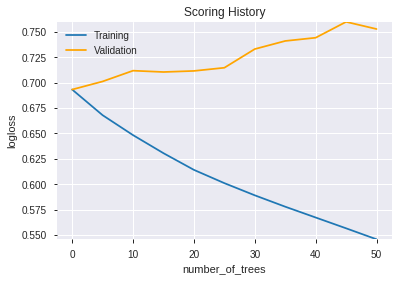

--2019-08-24 19:59:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.81.248
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.81.248|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(Share

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_195843_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_195843_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_8405',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_195929_model_4  0.560340  16.762147              0.500000  0.720674  0.519370
1  DeepLearning_grid_1_AutoML_20190824_195929_model_1  0.506011  15.866706              0.486927  0.684952  0.469160
2  DeepLearning_grid_1_AutoML_20190824_195929_model_9  0.503876   0.702076              0.500000  0.504346  0.254365
3  DeepLearning_grid_1_AutoML_20190824_195929_model_6  0.503876   0.693644              0.500000  0.500248  0.250248
4  DeepLearning_grid_1_AutoML_20190824_195929_model_5  0.500000   0.697236              0.500000  0.502008  0.252012
5  DeepLearning_grid_1_AutoML_20190824_195929_model_8  0.500000   0.704902              0.500000  0.505693  0.255725
6  DeepLearning_grid_1_AutoML_20190824_195929_model_3  0.500000  16.500306              0.500000  0.691182  0.477733
7               DeepLearning_1_AutoML_20190824_195929  0.498949  17.977136              0.500000  0.722681  0.522267
8  DeepLearning_grid_1_AutoML_20190824_195929_model_2  0.494810  17.914059              0.500000  0.722558  0.522090
9  DeepLearning_grid_1_AutoML_20190824_195929_model_7  0.431349   7.880729              0.491525  0.683431  0.467078

variable  relative_importance  scaled_importance  percentage
0                       SINH             1.000000           1.000000    0.022716
1                MINUS_DI_30             0.927598           0.927598    0.021072
2               LINEARREG_24             0.919589           0.919589    0.020890
3     BBANDS_upperband_8_2_2             0.910020           0.910020    0.020672
4    BBANDS_upperband_12_7_4             0.909778           0.909778    0.020667
5                    KAMA_24             0.907682           0.907682    0.020619
6                     ADX_24             0.906703           0.906703    0.020597
7                    MA_20_3             0.906476           0.906476    0.020592
8          MACDFIX_signal_14             0.906320           0.906320    0.020588
9                     MA_8_0             0.904751           0.904751    0.020553
10   BBANDS_lowerband_20_1_3             0.902303           0.902303    0.020497
11  BBANDS_middleband_20_7_4             0.899418           0.899418    0.020432
12                 MAVP_20_3             0.899389           0.899389    0.020431
13                   ROCR_14             0.895672           0.895672    0.020347
14    BBANDS_lowerband_8_3_5             0.893512           0.893512    0.020297
15              weekday_name             0.892598           0.892598    0.020277
16   BBANDS_upperband_14_2_4             0.891362           0.891362    0.020249
17         MACDFIX_signal_24             0.889822           0.889822    0.020214
18   BBANDS_upperband_20_0_3             0.889648           0.889648    0.020210
19                    RSI_20             0.886508           0.886508    0.020138
20                    ROC_14             0.884207           0.884207    0.020086
21  BBANDS_middleband_12_7_5             0.881235           0.881235    0.020019
22   BBANDS_upperband_14_5_3             0.881156           0.881156    0.020017
23               MINUS_DI_12             0.876821           0.876821    0.019918
24           MACDFIX_hist_12             0.876192           0.876192    0.019904
25                     RSI_8             0.875138           0.875138    0.019880
26   BBANDS_upperband_14_0_5             0.874773           0.874773    0.019872
27                ROCR100_24             0.874135           0.874135    0.019857
28   BBANDS_lowerband_20_6_5             0.872853           0.872853    0.019828
29                 STDDEV_30             0.872266           0.872266    0.019815
30                 aroonup_8             0.872153           0.872153    0.019812
31  BBANDS_middleband_24_5_5             0.871765           0.871765    0.019803
32   BBANDS_lowerband_30_7_4             0.871195           0.871195    0.019791
33  BBANDS_middleband_24_1_5             0.870212           0.870212    0.019768
34                    CCI_14             0.870030           0.870030    0.019764
35                 STDDEV_24             0.868423           0.868423    0.019728
36   BBANDS_upperband_30_1_5             0.867650           0.867650    0.019710
37                   weekday             0.866912           0.866912    0.019693
38   BBANDS_middleband_8_4_5             0.865825           0.865825    0.019669
39               AROONOSC_24             0.864488           0.864488    0.019638
40   BBANDS_lowerband_20_0_3             0.864370           0.864370    0.019635
41                  TRIMA_30             0.858024           0.858024    0.019491
42   BBANDS_lowerband_12_4_3             0.857517           0.857517    0.019480
43   BBANDS_middleband_8_8_5             0.850279           0.850279    0.019315
44               MINUS_DI_24             0.847512           0.847512    0.019253
45          MACDFIX_signal_8             0.842470           0.842470    0.019138
46                    ADX_12             0.835335           0.835335    0.018976
47                 PLUS_DM_8             0.825180           0.825180    0.018745
48                MACDFIX_24             0.824399  

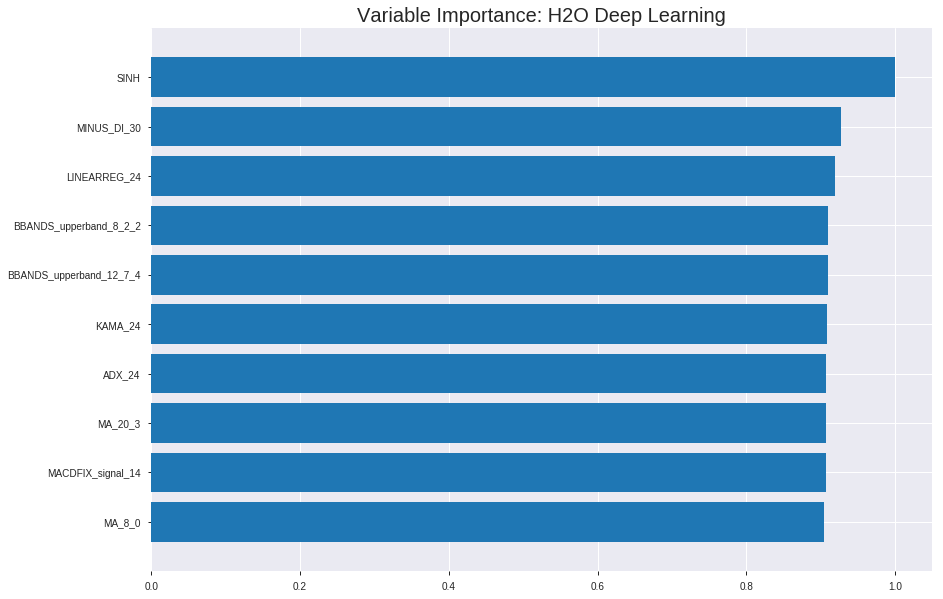

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_195929_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.3032862794657162
RMSE: 0.5507143356275703
LogLoss: 0.9231419263141774
Mean Per-Class Error: 0.47745966904382753
AUC: 0.5247843245863048
pr_auc: 0.6036533149517446
Gini: 0.0495686491726095
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08835703103324181: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      17   698   0.9762   (698.0/715.0)
1      6    1004  0.0059   (6.0/1010.0)
Total  23   1702  0.4081   (704.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.088357     0.740413   385
max f2                       0.0457889    0.876888   394
max f0point5                 0.242738     0.644484   339
max accuracy                 0.242738     0.594203   339
max precision                0.998789     0.833333   0
max recall                   0.0457889    1          394
max specificity              0.998789     0.998601   0
max absolute_mcc             0.242738     0.0832543  339
max min_per_class_accuracy   0.734651     0.520792   142
max mean_per_class_accuracy  0.242738     0.52254    339

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 67.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104348                   0.995              1.2335    1.2335             0.722222         0.997346  0.722222                    0.997346            0.0128713       0.0128713                  23.3498    23.3498
    2        0.0202899                   0.992054           1.20559   1.21994            0.705882         0.993525  0.714286                    0.99549             0.0118812       0.0247525                  20.5591    21.9943
    3        0.0301449                   0.988281           1.20559   1.21525            0.705882         0.990238  0.711538                    0.993773            0.0118812       0.0366337                  20.5591    21.5251
    4        0.04                        0.986027           0.803727  1.11386            0.470588         0.987183  0.652174                    0.992149            0.00792079      0.0445545                  -19.6273   11.3861
    5        0.0504348                   0.982061           1.13861   1.11898            0.666667         0.983935  0.655172                    0.99045             0.0118812       0.0564356                  13.8614    11.8983
    6        0.10029                     0.964441           0.953258  1.0366             0.55814          0.973244  0.606936                    0.981897            0.0475248       0.10396                    -4.67419   3.65993
    7        0.150145                    0.943933           1.15185   1.07487            0.674419         0.953613  0.629344                    0.972505            0.0574257       0.161386                   15.1854    7.48691
    8        0.2                         0.921852           0.834101  1.01485            0.488372         0.93304   0.594203                    0.962668            0.0415842       0.20297                    -16.5899   1.48515
    9        0.30029                     0.868258           1.04647   1.02541            0.612717         0.895361  0.600386                    0.940189            0.10495         0.307921                   4.64717    2.54119
    10       0.4                         0.806503           1.09227   1.04208            0.639535         0.836079  0.610145                    0.914237            0.108911        0.416832                   9.22749    4.20792
    11       0.50029                     0.736377           1.00698   1.03504            0.589595         0.772893  0.606025                    0.885902            0.10099         0.517822                   0.69822    3.50435
    12       0.6                         0.641569           0.943328  1.0198             0.552326         0.692246  0.597101                    0.85372             0.0940594       0.611881                   -5.66717   1.9802
    13       0.69971                     0.549995           0.973118  1.01315            0.569767         0.594765  0.593206                    0.816818            0.0970297       0.708911                   -2.68823   1.31494
    14       0.8                         0.428298           0.99711   1.01114            0.583815         0.486977  0.592029                    0.775469            0.1             0.808911                   -0.289017  1.11386
    15       0.89971                     0.283636           1.05256   1.01573            0.616279         0.35963   0.594716                    0.729384            0.10495         0.913861                   5.25558    1.57287
    16       1                           0.0151402          0.858897  1                  0.50289          0.175846  0.585507                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.39402665807907766
RMSE: 0.6277154276255106
LogLoss: 2.5651620595373923
Mean Per-Class Error: 0.4814013840830449
AUC: 0.4977780039351381
pr_auc: 0.5800460455122765
Gini: -0.004443992129723795
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.905699222990834e-06: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.9057e-06   0.73913    399
max f2                       1.9057e-06   0.876289   399
max f0point5                 1.9057e-06   0.639098   399
max accuracy                 1.9057e-06   0.586207   399
max precision                0.998955     1          0
max recall                   1.9057e-06   1          399
max specificity              0.998955     1          0
max absolute_mcc             0.0151785    0.0588282  380
max min_per_class_accuracy   0.477764     0.5        226
max mean_per_class_accuracy  0.145488     0.518599   312

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 47.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010142                    0.996906           1.36471   1.36471            0.8              0.997656    0.8                         0.997656            0.0138408       0.0138408                  36.4706    36.4706
    2        0.020284                    0.994911           0.682353  1.02353            0.4              0.995686    0.6                         0.996671            0.00692042      0.0207612                  -31.7647   2.35294
    3        0.030426                    0.993341           0.682353  0.909804           0.4              0.994458    0.533333                    0.995933            0.00692042      0.0276817                  -31.7647   -9.01961
    4        0.040568                    0.987959           0.341176  0.767647           0.2              0.99122     0.45                        0.994755            0.00346021      0.0311419                  -65.8824   -23.2353
    5        0.0507099                   0.984236           1.36471   0.887059           0.8              0.986277    0.52                        0.993059            0.0138408       0.0449827                  36.4706    -11.2941
    6        0.10142                     0.965349           1.02353   0.955294           0.6              0.976078    0.56                        0.984569            0.0519031       0.0968858                  2.35294    -4.47059
    7        0.150101                    0.938342           0.995098  0.968203           0.583333         0.953456    0.567568                    0.974478            0.0484429       0.145329                   -0.490196  -3.17965
    8        0.200811                    0.894088           1.09176   0.999406           0.64             0.919539    0.585859                    0.960605            0.0553633       0.200692                   9.17647    -0.0594177
    9        0.300203                    0.788796           1.0096    1.00278            0.591837         0.846091    0.587838                    0.922692            0.100346        0.301038                   0.960384   0.278219
    10       0.399594                    0.631375           0.939976  0.98716            0.55102          0.712546    0.57868                     0.870422            0.0934256       0.394464                   -6.0024    -1.28397
    11       0.501014                    0.477764           1.05765   1.00143            0.62             0.54427     0.587045                    0.804399            0.107266        0.50173                    5.76471    0.142891
    12       0.600406                    0.29551            1.0096    1.00278            0.591837         0.388637    0.587838                    0.735574            0.100346        0.602076                   0.960384   0.278219
    13       0.699797                    0.132825           1.07923   1.01364            0.632653         0.198949    0.594203                    0.659357            0.107266        0.709343                   7.92317    1.36402
    14       0.799189                    0.0394819          0.80072   0.98716            0.469388         0.0784942   0.57868                     0.587118            0.0795848       0.788927                   -19.928    -1.28397
    15       0.89858                     4.60837e-05        1.18367   1.0089             0.693878         0.0103902   0.591422                    0.523327            0.117647        0.906574                   18.3673    0.889656
    16       1                           4.20033e-41        0.921176  1                  0.54   


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 20:01:14  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 20:01:20  7.179 sec   372 obs/sec       1.37971   1             2380       0.633457         3.26285             -0.653428      0.528789        0.502676           1.04373          0.413913                         0.634422           8.24116               -0.659287        0.489356          0.297109             0.993203           0.411765
    2019-08-24 20:01:30  17.370 sec  446 obs/sec       4.10145   3             7075       0.550714         0.923142            -0.249694      0.524784        0.603653           1.2335           0.408116                         0.627715           2.56516               -0.624394        0.497778          0.580046             1.36471            0.413793
    2019-08-24 20:01:39  25.914 sec  494 obs/sec       6.78551   5             11705      0.53674          0.824161            -0.187076      0.553179        0.625425           1.13861          0.414493                         0.697528           9.22623               -1.00581         0.499864          0.588455             1.02353            0.413793
    2019-08-24 20:01:46  33.497 sec  537 obs/sec       9.49855   7             16385      0.608324         1.49106             -0.524827      0.542542        0.61591            1.32838          0.414493                         0.639658           7.94234               -0.686789        0.495658          0.312593             1.01153            0.411765
    2019-08-24 20:01:56  42.827 sec  599 obs/sec       13.5838   10            23432      0.557872         1.00848             -0.282391      0.570438        0.63055            1.04373          0.413913                         0.632983           6.8045                -0.651774        0.500059          0.333104             1.04977            0.409736
    2019-08-24 20:02:04  51.035 sec  655 obs/sec       17.68     13            30498      0.503879         0.724395            -0.0461706     0.610033        0.678467           1.32838          0.410435                         0.598025           5.84149               -0.474363        0.504334          0.368338             1.02353            0.409736
    2019-08-24 20:02:05  51.808 sec  655 obs/sec       17.68     13            30498      0.550714         0.923142            -0.249694      0.524784        0.603653           1.2335           0.408116                         0.627715           2.56516               -0.624394        0.497778          0.580046             1.36471            0.413793

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
SINH                     1.0                    1.0                  0.02271649823295825
MINUS_DI_30              0.927598237991333      0.927598237991333    0.021071783734225306
LINEARREG_24             0.919588565826416      0.919588565826416    0.020889832030644394
BBANDS_upperband_8_2_2   0.9100198745727539     0.9100198745727539   0.020672464872688853
BBANDS_upperband_12_7_4  0.9097781777381897     0.9097781777381897   0.020666974366973564
---                      ---                    ---                  ---
MACDFIX_signal_8         0.8424695134162903     0.8424695134162903   0.019137957212842355
ADX_12                   0.8353350162506104     0.8353350162506104   0.018975886420585144
PLUS_DM_8                0.8251801133155823     0.8251801133155823   0.018745202586005715
MACDFIX_24               0.8243987560272217     0.8243987560272217   0.018727452884545363
LINEARREG_SLOPE_8        0.8192048668861389     0.8192048668861389   0.018609465911049776


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5668016194331984)

('F1', 0.6861702127659575)

('auc', 0.5603402969386414)

('logloss', 16.762147308697703)

('mean_per_class_error', 0.4259295756142425)

('rmse', 0.7206736099887299)

('mse', 0.519370452134188)

deeplearning prediction progress: |███████████████████████████████████████| 100%


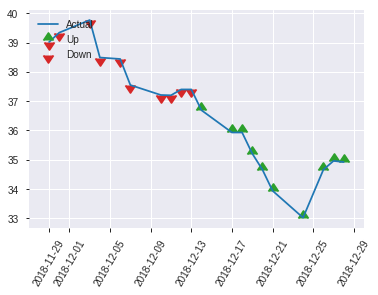


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.519370452134188
RMSE: 0.7206736099887299
LogLoss: 16.762147308697703
Mean Per-Class Error: 0.4259295756142425
AUC: 0.5603402969386414
pr_auc: 0.5679028101646322
Gini: 0.1206805938772828
Confusion Matrix (Act/Pred) for max f1 @ threshold = 8.256299353366906e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       8.2563e-49   0.68617   102
max f2                       8.2563e-49   0.845347  102
max f0point5                 8.2563e-49   0.57744   102
max accuracy                 1.12146e-37  0.566802  83
max precision                0.902565     1         0
max recall                   8.2563e-49   1         102
max specificity              0.902565     1         0
max absolute_mcc             1.12146e-37  0.156199  83
max min_per_class_accuracy   1.18878e-45  0.472868  101
max mean_per_class_accuracy  1.12146e-37  0.57407   83

Gains/Lift Table: Avg response rate: 52.23 %, avg score:  0.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.0710374          0.638243  0.638243           0.333333         0.518132      0.333333                    0.518132            0.00775194      0.00775194                 -36.1757   -36.1757
    2        0.0202429                   0.00659972         0.957364  0.765891           0.5              0.0190178     0.4                         0.318486            0.00775194      0.0155039                  -4.26357   -23.4109
    3        0.0323887                   0.000871437        1.27649   0.957364           0.666667         0.00338738    0.5                         0.200324            0.0155039       0.0310078                  27.6486    -4.26357
    4        0.0404858                   1.90633e-06        0         0.765891           0                0.00042937    0.4                         0.160345            0               0.0310078                  -100       -23.4109
    5        0.0526316                   1.9856e-07         1.91473   1.03101            1                9.3201e-07    0.538462                    0.123343            0.0232558       0.0542636                  91.4729    3.10078
    6        0.101215                    1.17738e-12        1.43605   1.22543            0.75             1.66057e-09   0.64                        0.0641382           0.0697674       0.124031                   43.6047    22.5426
    7        0.149798                    3.6745e-16         1.27649   1.24199            0.666667         1.92071e-13   0.648649                    0.0433366           0.0620155       0.186047                   27.6486    24.1986
    8        0.202429                    9.36794e-20        0.883721  1.14884            0.461538         5.08503e-17   0.6                         0.0320691           0.0465116       0.232558                   -11.6279   14.8837
    9        0.299595                    1.2044e-33         1.11693   1.13849            0.583333         5.98308e-21   0.594595                    0.0216683           0.108527        0.341085                   11.6925    13.8487
    10       0.40081                     1.26139e-44        1.14884   1.1411             0.6              7.30252e-35   0.59596                     0.0161965           0.116279        0.457364                   14.8837    14.1101
    11       0.502024                    5.45636e-58        0.995659  1.11178            0.52             1.21483e-45   0.580645                    0.0129311           0.100775        0.55814                    -0.434109  11.1778
    12       0.59919                     7.13686e-84        0.957364  1.08674            0.5              9.37268e-61   0.567568                    0.0108342           0.0930233       0.651163                   -4.26357   8.67379
    13       0.700405                    7.587e-122         0.765891  1.04037            0.4              1.4704e-86    0.543353                    0.00926853          0.0775194       0.728682                   -23.4109   4.03728
    14       0.797571                    4.41694e-203       0.877584  1.02054            0.458333         2.20135e-125  0.532995                    0.00813937          0.0852713       0.813953                   -12.2416   2.05407
    15       1                           0                  0.91907   1                  0.48             1.33581e-205  0.522267                    0.00649172          0.186047        1                          -8.09302   0

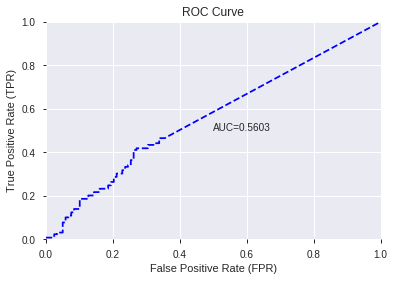

This function is available for GLM models only


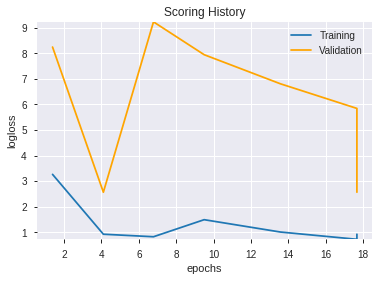

--2019-08-24 20:08:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_195929_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_195929_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_8405',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['SINH',
 'MINUS_DI_30',
 'LINEARREG_24',
 'BBANDS_upperband_8_2_2',
 'BBANDS_upperband_12_7_4',
 'KAMA_24',
 'ADX_24',
 'MA_20_3',
 'MACDFIX_signal_14',
 'MA_8_0',
 'BBANDS_lowerband_20_1_3',
 'BBANDS_middleband_20_7_4',
 'MAVP_20_3',
 'ROCR_14',
 'BBANDS_lowerband_8_3_5',
 'weekday_name',
 'BBANDS_upperband_14_2_4',
 'MACDFIX_signal_24',
 'BBANDS_upperband_20_0_3',
 'RSI_20',
 'ROC_14',
 'BBANDS_middleband_12_7_5',
 'BBANDS_upperband_14_5_3',
 'MINUS_DI_12',
 'MACDFIX_hist_12',
 'RSI_8',
 'BBANDS_upperband_14_0_5',
 'ROCR100_24',
 'BBANDS_lowerband_20_6_5',
 'STDDEV_30',
 'aroonup_8',
 'BBANDS_middleband_24_5_5',
 'BBANDS_lowerband_30_7_4',
 'BBANDS_middleband_24_1_5',
 'CCI_14',
 'STDDEV_24',
 'BBANDS_upperband_30_1_5',
 'weekday',
 'BBANDS_middleband_8_4_5',
 'AROONOSC_24',
 'BBANDS_lowerband_20_0_3',
 'TRIMA_30',
 'BBANDS_lowerband_12_4_3',
 'BBANDS_middleband_8_8_5',
 'MINUS_DI_24',
 'MACDFIX_signal_8',
 'ADX_12',
 'PLUS_DM_8',
 'MACDFIX_24',
 'LINEARREG_SLOPE_8']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_200840_model_1  0.541486  17.307283                   0.5  0.720095  0.518536

variable  relative_importance  scaled_importance  percentage
0                       SINH             0.007988           1.000000    0.089046
1               weekday_name             0.007133           0.892945    0.079513
2           MACDFIX_signal_8             0.005574           0.697794    0.062136
3                     ROC_14             0.005492           0.687559    0.061224
4                    ROCR_14             0.005490           0.687211    0.061193
5                 MACDFIX_24             0.005461           0.683602    0.060872
6          MACDFIX_signal_14             0.005164           0.646385    0.057558
7          MACDFIX_signal_24             0.004233           0.529953    0.047190
8                  PLUS_DM_8             0.002313           0.289591    0.025787
9                     RSI_20             0.002083           0.260742    0.023218
10               MINUS_DI_24             0.002077           0.259959    0.023148
11                    ADX_24             0.002068           0.258828    0.023048
12               MINUS_DI_30             0.001906           0.238540    0.021241
13           MACDFIX_hist_12             0.001805           0.225902    0.020116
14                ROCR100_24             0.001794           0.224597    0.019999
15                   weekday             0.001793           0.224486    0.019990
16               MINUS_DI_12             0.001398           0.174970    0.015580
17    BBANDS_lowerband_8_3_5             0.001356           0.169710    0.015112
18                 aroonup_8             0.001322           0.165476    0.014735
19   BBANDS_lowerband_12_4_3             0.001091           0.136599    0.012164
20                 STDDEV_30             0.001034           0.129434    0.011526
21              LINEARREG_24             0.000991           0.124024    0.011044
22   BBANDS_lowerband_20_6_5             0.000984           0.123205    0.010971
23   BBANDS_middleband_8_4_5             0.000961           0.120358    0.010717
24   BBANDS_middleband_8_8_5             0.000930           0.116482    0.010372
25                   MA_20_3             0.000929           0.116293    0.010355
26                 MAVP_20_3             0.000921           0.115349    0.010271
27                    MA_8_0             0.000912           0.114142    0.010164
28  BBANDS_middleband_12_7_5             0.000843           0.105531    0.009397
29  BBANDS_middleband_20_7_4             0.000837           0.104815    0.009333
30   BBANDS_lowerband_20_1_3             0.000837           0.104796    0.009332
31                 STDDEV_24             0.000816           0.102089    0.009091
32               AROONOSC_24             0.000814           0.101913    0.009075
33   BBANDS_lowerband_20_0_3             0.000808           0.101115    0.009004
34                    CCI_14             0.000806           0.100925    0.008987
35    BBANDS_upperband_8_2_2             0.000799           0.100038    0.008908
36         LINEARREG_SLOPE_8             0.000757           0.094776    0.008439
37   BBANDS_upperband_30_1_5             0.000726           0.090899    0.008094
38   BBANDS_upperband_14_2_4             0.000713           0.089257    0.007948
39   BBANDS_lowerband_30_7_4             0.000711           0.089035    0.007928
40   BBANDS_upperband_12_7_4             0.000708           0.088655    0.007894
41   BBANDS_upperband_14_5_3             0.000696           0.087078    0.007754
42                   KAMA_24             0.000676           0.084598    0.007533
43  BBANDS_middleband_24_1_5             0.000613           0.076717    0.006831
44   BBANDS_upperband_14_0_5             0.000600           0.075048    0.006683
45  BBANDS_middleband_24_5_5             0.000548           0.068557    0.006105
46                  TRIMA_30             0.000467           0.058471    0.005207
47   BBANDS_upperband_20_0_3             0.000437           0.054761    0.004876
48                    ADX_12             0.000158  

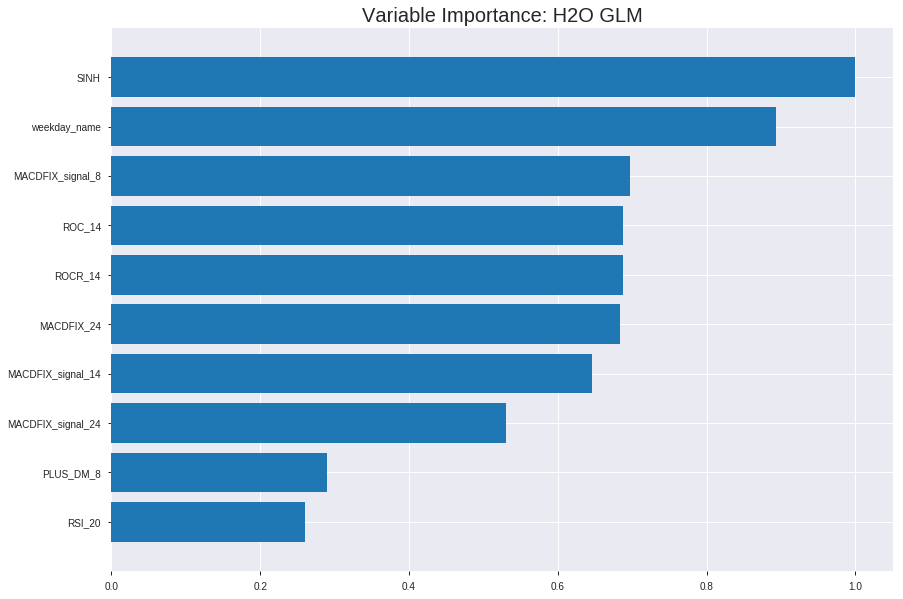

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_200840_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24216792981097227
RMSE: 0.4921056083921136
LogLoss: 0.6773821102987119
Null degrees of freedom: 1724
Residual degrees of freedom: 1674
Null deviance: 2340.659668736101
Residual deviance: 2336.968280530556
AIC: 2438.968280530556
AUC: 0.5408003877310807
pr_auc: 0.607723758742796
Gini: 0.08160077546216149
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5553786016644017: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    715   1        (715.0/715.0)
1      0    1010  0        (0.0/1010.0)
Total  0    1725  0.4145   (715.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.555379     0.738574  399
max f2                       0.555379     0.875976  399
max f0point5                 0.575944     0.646109  306
max accuracy                 0.575944     0.594203  306
max precision                0.624227     1         0
max recall                   0.555379     1         399
max specificity              0.624227     1         0
max absolute_mcc             0.576206     0.100055  303
max min_per_class_accuracy   0.584152     0.525874  219
max mean_per_class_accuracy  0.579161     0.539812  273

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 58.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104348                   0.612498           1.32838   1.32838            0.777778         0.616311  0.777778                    0.616311            0.0138614       0.0138614                  32.8383    32.8383
    2        0.0202899                   0.609093           1.00466   1.17115            0.588235         0.610612  0.685714                    0.613543            0.00990099      0.0237624                  0.465929   17.1146
    3        0.0301449                   0.606914           0.803727  1.05103            0.470588         0.60778   0.615385                    0.611659            0.00792079      0.0316832                  -19.6273   5.10282
    4        0.04                        0.605235           0.904193  1.01485            0.529412         0.606041  0.594203                    0.610275            0.00891089      0.0405941                  -9.58066   1.48515
    5        0.0504348                   0.6042             1.32838   1.07972            0.777778         0.604728  0.632184                    0.609127            0.0138614       0.0544554                  32.8383    7.972
    6        0.10029                     0.599894           0.913539  0.99711            0.534884         0.60183   0.583815                    0.6055              0.0455446       0.1                        -8.6461    -0.289017
    7        0.150145                    0.596828           1.01284   1.00233            0.593023         0.598238  0.586873                    0.603089            0.050495        0.150495                   1.28367    0.233189
    8        0.2                         0.593696           1.07242   1.0198             0.627907         0.595037  0.597101                    0.601082            0.0534653       0.20396                    7.24154    1.9802
    9        0.30029                     0.589854           1.17481   1.07157            0.687861         0.591656  0.627413                    0.597934            0.117822        0.321782                   17.4813    7.15719
    10       0.4                         0.586868           0.983047  1.0495             0.575581         0.588272  0.614493                    0.595525            0.0980198       0.419802                   -1.69526   4.9505
    11       0.50029                     0.584247           1.01685   1.04296            0.595376         0.585605  0.61066                     0.593537            0.10198         0.521782                   1.68546    4.29597
    12       0.6                         0.582266           1.06249   1.0462             0.622093         0.583267  0.61256                     0.59183             0.105941        0.627723                   6.24856    4.62046
    13       0.69971                     0.579949           1.02277   1.04286            0.598837         0.580995  0.610605                    0.590286            0.10198         0.729703                   2.27665    4.28646
    14       0.8                         0.577199           0.99711   1.03713            0.583815         0.578632  0.607246                    0.588825            0.1             0.829703                   -0.289017  3.71287
    15       0.89971                     0.573639           0.86389   1.01793            0.505814         0.575564  0.596005                    0.587355            0.0861386       0.915842                   -13.611    1.79296
    16       1                           0.555379           0.839152  1                  0.491329         0.568927  0.585507                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3552043536639365
RMSE: 0.5959902295037532
LogLoss: 2.8003692876500654
Null degrees of freedom: 492
Residual degrees of freedom: 442
Null deviance: 668.7154569489843
Residual deviance: 4048.182186939468
AIC: 4150.182186939468
AUC: 0.4988805210665581
pr_auc: 0.586678950422294
Gini: -0.002238957866883773
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.212005805093618e-07: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       3.21201e-07  0.73913    399
max f2                       3.21201e-07  0.876289   399
max f0point5                 3.21201e-07  0.639098   399
max accuracy                 3.21201e-07  0.586207   399
max precision                0.607141     1          0
max recall                   3.21201e-07  1          399
max specificity              0.607141     1          0
max absolute_mcc             0.605888     0.0759874  3
max min_per_class_accuracy   0.507223     0.512111   218
max mean_per_class_accuracy  0.51312      0.519464   208

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 35.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.605017           1.36471   1.36471            0.8              0.606129     0.8                         0.606129            0.0138408       0.0138408                  36.4706   36.4706
    2        0.020284                    0.597672           0.682353  1.02353            0.4              0.600605     0.6                         0.603367            0.00692042      0.0207612                  -31.7647  2.35294
    3        0.030426                    0.595327           1.02353   1.02353            0.6              0.596528     0.6                         0.601087            0.0103806       0.0311419                  2.35294   2.35294
    4        0.040568                    0.589876           0.682353  0.938235           0.4              0.593425     0.55                        0.599172            0.00692042      0.0380623                  -31.7647  -6.17647
    5        0.0507099                   0.586483           0.682353  0.887059           0.4              0.587866     0.52                        0.59691             0.00692042      0.0449827                  -31.7647  -11.2941
    6        0.10142                     0.57759            0.955294  0.921176           0.56             0.580987     0.54                        0.588949            0.0484429       0.0934256                  -4.47059  -7.88235
    7        0.150101                    0.574923           1.13725   0.991256           0.666667         0.576114     0.581081                    0.584786            0.0553633       0.148789                   13.7255   -0.874404
    8        0.200811                    0.570949           1.09176   1.01664            0.64             0.573121     0.59596                     0.581841            0.0553633       0.204152                   9.17647   1.6637
    9        0.300203                    0.56425            1.04442   1.02583            0.612245         0.567442     0.601351                    0.577074            0.103806        0.307958                   4.44178   2.58347
    10       0.399594                    0.551619           0.97479   1.01314            0.571429         0.558495     0.593909                    0.572452            0.0968858       0.404844                   -2.52101  1.31383
    11       0.501014                    0.506639           1.05765   1.02215            0.62             0.530705     0.59919                     0.564002            0.107266        0.512111                   5.76471   2.21481
    12       0.600406                    0.335285           0.80072   0.985493           0.469388         0.425835     0.577703                    0.541129            0.0795848       0.591696                   -19.928   -1.45072
    13       0.699797                    0.137088           0.97479   0.983973           0.571429         0.250037     0.576812                    0.499786            0.0968858       0.688581                   -2.52101  -1.60273
    14       0.799189                    0.0182055          1.11405   1.00015            0.653061         0.0681322    0.586294                    0.446103            0.110727        0.799308                   11.4046   0.0149298
    15       0.89858                     1.10482e-07        1.07923   1.0089             0.632653         0.00549031   0.591422                    0.397367            0.107266        0.906574                   7.92317   0.889656
    16       1                           6.60715e-68        0.921176  1                  0.54        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 20:08:40  0.000 sec   2            2.5       51            1.35476           8.21132
    2019-08-24 20:08:40  0.009 sec   3            1.6       51            1.35408           12.0033
    2019-08-24 20:08:40  0.024 sec   5            0.97      51            1.35323           17.6467
    2019-08-24 20:08:40  0.039 sec   7            0.6       51            1.3522            25.6035
    2019-08-24 20:08:40  0.063 sec   9            0.38      51            1.35099           36.2099

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5303643724696356)

('F1', 0.6861702127659575)

('auc', 0.5414860070949941)

('logloss', 17.30728307920532)

('mean_per_class_error', 0.4578242018131651)

('rmse', 0.7200945050841363)

('mse', 0.5185360962523672)

glm prediction progress: |████████████████████████████████████████████████| 100%


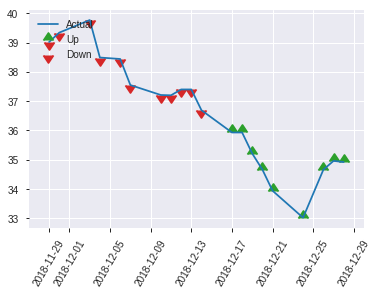


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5185360962523672
RMSE: 0.7200945050841363
LogLoss: 17.30728307920532
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 345.9465433426434
Residual deviance: 75796.16776766178
AIC: 75898.16776766178
AUC: 0.5414860070949941
pr_auc: 0.5672766867805474
Gini: 0.08297201418998812
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.5939179326214335e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       3.59392e-48  0.68617   63
max f2                       3.59392e-48  0.845347  63
max f0point5                 3.59392e-48  0.57744   63
max accuracy                 5.62445e-41  0.530364  60
max precision                0.495327     1         0
max recall                   3.59392e-48  1         63
max specificity              0.495327     1         0
max absolute_mcc             2.12844e-24  0.119409  35
max min_per_class_accuracy   1.04307e-45  0.294574  62
max mean_per_class_accuracy  2.12844e-24  0.542176  35

Gains/Lift Table: Avg response rate: 52.23 %, avg score:  0.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.0990728          1.27649   1.27649            0.666667         0.299307      0.666667                    0.299307            0.0155039       0.0155039                  27.6486    27.6486
    2        0.0202429                   0.0419387          0.957364  1.14884            0.5              0.0726301     0.6                         0.208636            0.00775194      0.0232558                  -4.26357   14.8837
    3        0.0323887                   0.000109289        0         0.718023           0                0.0188158     0.375                       0.137454            0               0.0232558                  -100       -28.1977
    4        0.0404858                   2.16355e-09        1.91473   0.957364           1                5.41489e-05   0.5                         0.109974            0.0155039       0.0387597                  91.4729    -4.26357
    5        0.0526316                   5.97565e-12        1.27649   1.03101            0.666667         9.92393e-10   0.538462                    0.0845952           0.0155039       0.0542636                  27.6486    3.10078
    6        0.101215                    7.33145e-20        1.43605   1.22543            0.75             1.64659e-13   0.64                        0.0439895           0.0697674       0.124031                   43.6047    22.5426
    7        0.149798                    6.48012e-26        1.27649   1.24199            0.666667         6.36747e-21   0.648649                    0.0297226           0.0620155       0.186047                   27.6486    24.1986
    8        0.202429                    3.27421e-31        0.883721  1.14884            0.461538         1.08872e-26   0.6                         0.0219947           0.0465116       0.232558                   -11.6279   14.8837
    9        0.299595                    7.02018e-54        1.19671   1.16436            0.625            3.91495e-33   0.608108                    0.0148613           0.116279        0.348837                   19.6705    16.4362
    10       0.40081                     6.1713e-73         1.07225   1.1411             0.56             2.11162e-55   0.59596                     0.0111085           0.108527        0.457364                   7.22481    14.1101
    11       0.502024                    4.50709e-97        0.995659  1.11178            0.52             1.54144e-74   0.580645                    0.00886885          0.100775        0.55814                    -0.434109  11.1778
    12       0.59919                     3.06943e-139       0.957364  1.08674            0.5              2.33903e-99   0.567568                    0.00743066          0.0930233       0.651163                   -4.26357   8.67379
    13       0.700405                    7.04131e-205       0.765891  1.04037            0.4              1.93897e-144  0.543353                    0.00635686          0.0775194       0.728682                   -23.4109   4.03728
    14       1                           0                  0.905615  1                  0.472973         1.73815e-210  0.522267                    0.00445238          0.271318        1                          -9.43851   0

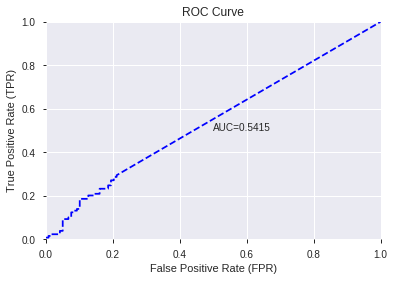

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


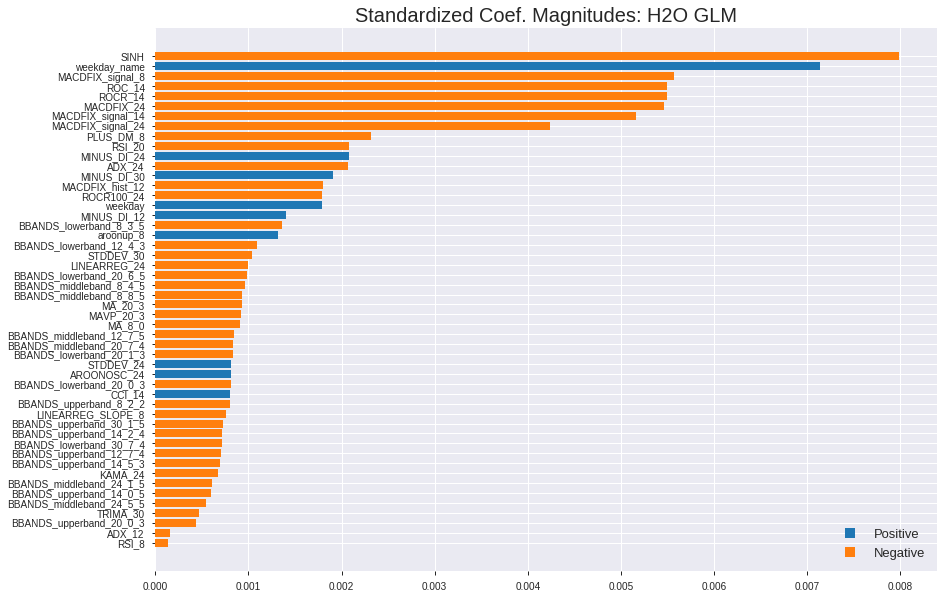

'log_likelihood'
--2019-08-24 20:08:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_200840_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_200840_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_8405',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['SINH',
 'weekday_name',
 'MACDFIX_signal_8',
 'ROC_14',
 'ROCR_14',
 'MACDFIX_24',
 'MACDFIX_signal_14',
 'MACDFIX_signal_24',
 'PLUS_DM_8',
 'RSI_20',
 'MINUS_DI_24',
 'ADX_24',
 'MINUS_DI_30',
 'MACDFIX_hist_12',
 'ROCR100_24',
 'weekday',
 'MINUS_DI_12',
 'BBANDS_lowerband_8_3_5',
 'aroonup_8',
 'BBANDS_lowerband_12_4_3',
 'STDDEV_30',
 'LINEARREG_24',
 'BBANDS_lowerband_20_6_5',
 'BBANDS_middleband_8_4_5',
 'BBANDS_middleband_8_8_5',
 'MA_20_3',
 'MAVP_20_3',
 'MA_8_0',
 'BBANDS_middleband_12_7_5',
 'BBANDS_middleband_20_7_4',
 'BBANDS_lowerband_20_1_3',
 'STDDEV_24',
 'AROONOSC_24',
 'BBANDS_lowerband_20_0_3',
 'CCI_14',
 'BBANDS_upperband_8_2_2',
 'LINEARREG_SLOPE_8',
 'BBANDS_upperband_30_1_5',
 'BBANDS_upperband_14_2_4',
 'BBANDS_lowerband_30_7_4',
 'BBANDS_upperband_12_7_4',
 'BBANDS_upperband_14_5_3',
 'KAMA_24',
 'BBANDS_middleband_24_1_5',
 'BBANDS_upperband_14_0_5',
 'BBANDS_middleband_24_5_5',
 'TRIMA_30',
 'BBANDS_upperband_20_0_3',
 'ADX_12',
 'RSI_8']

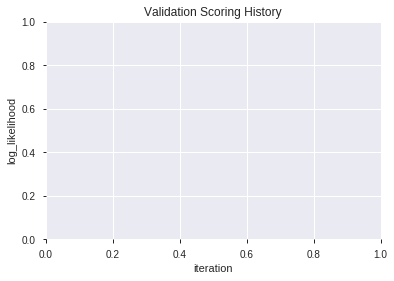

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_200850_model_1  0.520037  0.792584              0.500000  0.542395  0.294193
1  XGBoost_grid_1_AutoML_20190824_200850_model_2  0.502956  0.702456              0.478452  0.504594  0.254615
2  XGBoost_grid_1_AutoML_20190824_200850_model_4  0.496420  0.707051              0.500000  0.506612  0.256656
3  XGBoost_grid_1_AutoML_20190824_200850_model_6  0.486861  0.781629              0.500000  0.538883  0.290395
4  XGBoost_grid_1_AutoML_20190824_200850_model_5  0.484825  0.929567              0.500000  0.586399  0.343863
5               XGBoost_3_AutoML_20190824_200850  0.480489  0.740616              0.491164  0.522023  0.272508
6               XGBoost_1_AutoML_20190824_200850  0.464492  0.742973              0.500000  0.522931  0.273457
7  XGBoost_grid_1_AutoML_20190824_200850_model_3  0.459894  0.809150              0.495763  0.549258  0.301684
8  XGBoost_grid_1_AutoML_20190824_200850_model_7  0.459072  0.747797              0.495401  0.525001  0.275626
9               XGBoost_2_AutoML_20190824_200850  0.439627  0.732336              0.500000  0.518610  0.268956

variable  relative_importance  scaled_importance  percentage
0                 PLUS_DM_8           238.099228           1.000000    0.080798
1         MACDFIX_signal_24           188.752396           0.792747    0.064053
2               MINUS_DI_30           153.471619           0.644570    0.052080
3                    ROC_14           145.421677           0.610761    0.049349
4                    ADX_12           133.427612           0.560387    0.045278
5                    ADX_24           127.765259           0.536605    0.043357
6         MACDFIX_signal_14           118.311981           0.496902    0.040149
7         LINEARREG_SLOPE_8           111.624168           0.468814    0.037879
8                ROCR100_24           110.981445           0.466114    0.037661
9                   weekday           109.066048           0.458070    0.037011
10                STDDEV_24            94.482048           0.396818    0.032062
11          MACDFIX_hist_12            93.902092           0.394382    0.031865
12  BBANDS_upperband_12_7_4            87.361099           0.366910    0.029646
13                STDDEV_30            86.949036           0.365180    0.029506
14              MINUS_DI_24            80.500931           0.338098    0.027318
15              AROONOSC_24            75.210297           0.315878    0.025522
16                    RSI_8            71.483795           0.300227    0.024258
17              MINUS_DI_12            70.368149           0.295541    0.023879
18  BBANDS_upperband_14_0_5            69.936508           0.293728    0.023733
19  BBANDS_lowerband_20_6_5            63.857388           0.268197    0.021670
20               MACDFIX_24            61.784832           0.259492    0.020967
21                   CCI_14            58.195103           0.244415    0.019748
22  BBANDS_lowerband_30_7_4            54.778683           0.230067    0.018589
23  BBANDS_middleband_8_8_5            53.210381           0.223480    0.018057
24                  MA_20_3            52.311119           0.219703    0.017752
25  BBANDS_upperband_20_0_3            43.893452           0.184349    0.014895
26  BBANDS_upperband_30_1_5            42.689682           0.179294    0.014487
27                MAVP_20_3            41.432430           0.174013    0.014060
28   BBANDS_lowerband_8_3_5            37.834862           0.158904    0.012839
29  BBANDS_middleband_8_4_5            36.087570           0.151565    0.012246
30                   MA_8_0            33.845291           0.142148    0.011485
31                  KAMA_24            32.243279           0.135420    0.010942
32             weekday_name            29.828310           0.125277    0.010122
33  BBANDS_upperband_14_5_3            26.321777           0.110550    0.008932
34                  ROCR_14            23.420025           0.098362    0.007948
35  BBANDS_lowerband_20_0_3            15.140785           0.063590    0.005138
36             LINEARREG_24            13.307165           0.055889    0.004516
37         MACDFIX_signal_8            12.775221           0.053655    0.004335
38   BBANDS_upperband_8_2_2            11.392679           0.047848    0.003866
39                   RSI_20            10.028095           0.042117    0.003403
40  BBANDS_upperband_14_2_4             9.208834           0.038676    0.003125
41                     SINH             8.580676           0.036038    0.002912
42  BBANDS_lowerband_12_4_3             3.279403           0.013773    0.001113
43                 TRIMA_30             2.632151           0.011055    0.000893
44                aroonup_8             1.633987           0.006863    0.000554

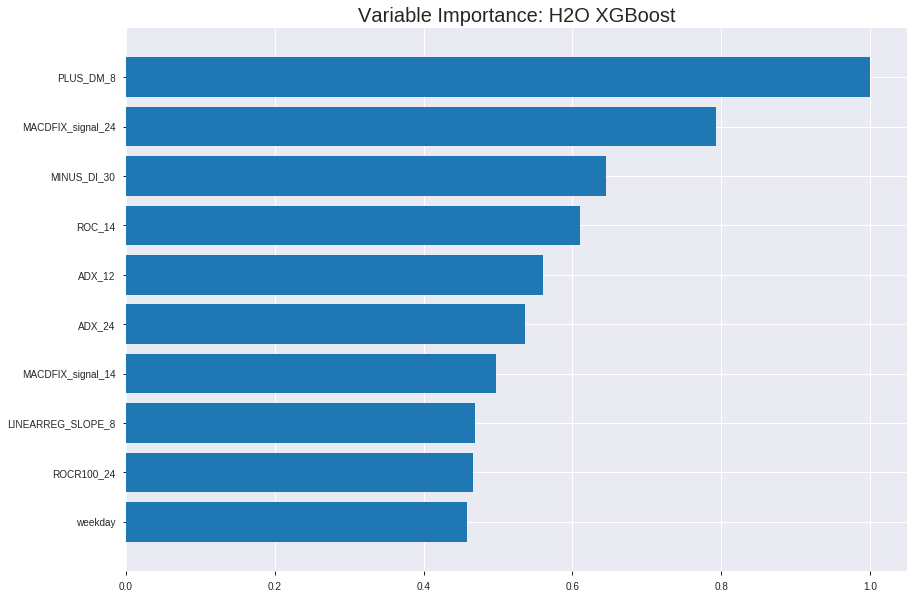

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_200850_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.20297683103244185
RMSE: 0.450529500734904
LogLoss: 0.5953470226876137
Mean Per-Class Error: 0.24267119019594263
AUC: 0.8420577442359621
pr_auc: 0.8858696390204869
Gini: 0.6841154884719243
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5491889317830404: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      377  338   0.4727   (338.0/715.0)
1      98   912   0.097    (98.0/1010.0)
Total  475  1250  0.2528   (436.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.549189     0.80708   231
max f2                       0.451903     0.893207  320
max f0point5                 0.597448     0.816404  165
max accuracy                 0.575379     0.763478  198
max precision                0.852348     1         0
max recall                   0.3955       1         357
max specificity              0.852348     1         0
max absolute_mcc             0.59611      0.511524  167
max min_per_class_accuracy   0.583215     0.735664  185
max mean_per_class_accuracy  0.59611      0.757329  167

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 57.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.768943           1.70792   1.70792            1                0.791022  1                           0.791022            0.0178218       0.0178218                  70.7921   70.7921
    2        0.0202899                   0.749205           1.70792   1.70792            1                0.756231  1                           0.774124            0.0168317       0.0346535                  70.7921   70.7921
    3        0.0301449                   0.738082           1.70792   1.70792            1                0.744492  1                           0.764437            0.0168317       0.0514851                  70.7921   70.7921
    4        0.04                        0.724678           1.60745   1.68317            0.941176         0.731269  0.985507                    0.756265            0.0158416       0.0673267                  60.7455   68.3168
    5        0.0504348                   0.712496           1.70792   1.68829            1                0.718634  0.988506                    0.748479            0.0178218       0.0851485                  70.7921   68.829
    6        0.10029                     0.675747           1.64834   1.66843            0.965116         0.693947  0.976879                    0.721371            0.0821782       0.167327                   64.8342   66.8431
    7        0.150145                    0.651551           1.70792   1.68154            1                0.662275  0.984556                    0.701748            0.0851485       0.252475                   70.7921   68.1544
    8        0.2                         0.639065           1.50933   1.63861            0.883721         0.64472   0.95942                     0.687533            0.0752475       0.327723                   50.9325   63.8614
    9        0.30029                     0.61528            1.46111   1.57933            0.855491         0.627144  0.92471                     0.667364            0.146535        0.474257                   46.1111   57.9332
    10       0.4                         0.600777           1.33059   1.51733            0.77907          0.608083  0.888406                    0.652587            0.132673        0.606931                   33.0589   51.7327
    11       0.50029                     0.587559           1.01685   1.417              0.595376         0.594421  0.829664                    0.640927            0.10198         0.708911                   1.68546   41.7
    12       0.6                         0.575424           1.00291   1.34818            0.587209         0.582016  0.789372                    0.631137            0.1             0.808911                   0.290698  34.8185
    13       0.69971                     0.556895           0.744733  1.26219            0.436047         0.567418  0.739022                    0.622057            0.0742574       0.883168                   -25.5267  26.2192
    14       0.8                         0.521361           0.562725  1.1745             0.32948          0.541062  0.687681                    0.611903            0.0564356       0.939604                   -43.7275  17.4505
    15       0.89971                     0.461099           0.466699  1.09606            0.273256         0.492959  0.641753                    0.598721            0.0465347       0.986139                   -53.3301  9.60626
    16       1                           0.210338           0.138213  1                  0.0809249        0.399982  0.585507                    0.57879             0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.29929213373951513
RMSE: 0.5470759853434577
LogLoss: 0.8021316276234832
Mean Per-Class Error: 0.4697231833910035
AUC: 0.5093798765180813
pr_auc: 0.6144430642085253
Gini: 0.018759753036162508
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19048327207565308: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    199  0.9755   (199.0/204.0)
1      1    288  0.0035   (1.0/289.0)
Total  6    487  0.4057   (200.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.190483     0.742268  393
max f2                       0.190483     0.876446  393
max f0point5                 0.190483     0.643719  393
max accuracy                 0.190483     0.59432   393
max precision                0.71202      1         0
max recall                   0.169517     1         399
max specificity              0.71202      1         0
max absolute_mcc             0.61816      0.105021  25
max min_per_class_accuracy   0.334575     0.480969  212
max mean_per_class_accuracy  0.581279     0.530277  55

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 37.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.689631           1.70588   1.70588            1                0.69681   1                           0.69681             0.017301        0.017301                   70.5882   70.5882
    2        0.020284                    0.654892           0.682353  1.19412            0.4              0.670159  0.7                         0.683485            0.00692042      0.0242215                  -31.7647  19.4118
    3        0.030426                    0.640716           1.36471   1.25098            0.8              0.646523  0.733333                    0.671164            0.0138408       0.0380623                  36.4706   25.098
    4        0.040568                    0.629551           1.36471   1.27941            0.8              0.637128  0.75                        0.662655            0.0138408       0.0519031                  36.4706   27.9412
    5        0.0507099                   0.622164           1.36471   1.29647            0.8              0.626887  0.76                        0.655502            0.0138408       0.0657439                  36.4706   29.6471
    6        0.10142                     0.590214           1.16      1.22824            0.68             0.605481  0.72                        0.630491            0.0588235       0.124567                   16        22.8235
    7        0.150101                    0.561023           0.852941  1.10652            0.5              0.57952   0.648649                    0.61396             0.0415225       0.16609                    -14.7059  10.6518
    8        0.200811                    0.494286           0.887059  1.0511             0.52             0.534038  0.616162                    0.593778            0.0449827       0.211073                   -11.2941  5.10992
    9        0.300203                    0.424571           0.97479   1.02583            0.571429         0.457772  0.601351                    0.548749            0.0968858       0.307958                   -2.52101  2.58347
    10       0.40568                     0.358539           0.852941  0.980882           0.5              0.389439  0.575                       0.507328            0.0899654       0.397924                   -14.7059  -1.91176
    11       0.501014                    0.333764           0.907384  0.966897           0.531915         0.341783  0.566802                    0.475828            0.0865052       0.484429                   -9.26158  -3.31031
    12       0.600406                    0.31255            1.11405   0.991256           0.653061         0.323288  0.581081                    0.450576            0.110727        0.595156                   11.4046   -0.874404
    13       0.699797                    0.289585           1.0096    0.993862           0.591837         0.299492  0.582609                    0.429118            0.100346        0.695502                   0.960384  -0.613811
    14       0.799189                    0.275977           1.14886   1.01314            0.673469         0.28319   0.593909                    0.41097             0.114187        0.809689                   14.886    1.31383
    15       0.89858                     0.24114            0.939976  1.00505            0.55102          0.257971  0.589165                    0.394047            0.0934256       0.903114                   -6.0024   0.504581
    16       1                           0.169517           0.955294  1                  0.56             0.216086  0.586207                    0.375998   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 20:08:54  0.014 sec   0                  0.5              0.693147            0.5             0                  1                0.414493                         0.5                0.693147              0.5               0                    1                  0.413793
    2019-08-24 20:08:54  0.080 sec   5                  0.49065          0.674567            0.667279        0.723066           1.70792          0.348406                         0.50453            0.702274              0.490484          0.576149             0.682353           0.411765
    2019-08-24 20:08:54  0.117 sec   10                 0.483929         0.661279            0.709817        0.775148           1.70792          0.338551                         0.508355           0.710136              0.499372          0.583635             0.487395           0.407708
    2019-08-24 20:08:54  0.164 sec   15                 0.477916         0.649438            0.736924        0.802793           1.70792          0.314783                         0.507872           0.709174              0.513154          0.595723             1.02353            0.409736
    2019-08-24 20:08:54  0.203 sec   20                 0.473113         0.639942            0.75211         0.813521           1.70792          0.304928                         0.511566           0.716964              0.516241          0.603074             1.02353            0.409736
    2019-08-24 20:08:54  0.234 sec   25                 0.468724         0.631283            0.783076        0.838217           1.61304          0.297971                         0.51825            0.731446              0.515452          0.604259             1.36471            0.411765
    2019-08-24 20:08:54  0.274 sec   30                 0.46521          0.624294            0.79866         0.85171            1.70792          0.297391                         0.526458           0.749949              0.513044          0.607777             1.36471            0.411765
    2019-08-24 20:08:54  0.311 sec   35                 0.461406         0.616764            0.815541        0.866304           1.70792          0.282319                         0.531407           0.761747              0.516165          0.614246             1.36471            0.411765
    2019-08-24 20:08:54  0.349 sec   40                 0.456971         0.608035            0.827267        0.875009           1.70792          0.266667                         0.535147           0.77101               0.511907          0.61211              1.70588            0.409736
    2019-08-24 20:08:54  0.386 sec   45                 0.453837         0.601866            0.834525        0.880371           1.70792          0.26029                          0.543062           0.791045              0.511212          0.611754             1.70588            0.403651
    2019-08-24 20:08:54  0.440 sec   50                 0.45053          0.595347            0.842058        0.88587            1.70792          0.252754                         0.547076           0.802132              0.50938           0.614443             1.70588            0.40568

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
PLUS_DM_8                238.09922790527344     1.0                   0.08079846604876192
MACDFIX_signal_24        188.7523956298828      0.792746777427506     0.06405272358124177
MINUS_DI_30              153.47161865234375     0.6445699971501027    0.05208026703078314
ROC_14                   145.4216766357422      0.6107608072278061    0.04934853634671032
ADX_12                   133.4276123046875      0.5603865811684656    0.04527837615272203
---                      ---                    ---                   ---
BBANDS_upperband_14_2_4  9.208833694458008      0.0386764534075755    0.003124998107538511
SINH                     8.580676078796387      0.036038235630945284  0.002911834158084215
BBANDS_lowerband_12_4_3  3.2794032096862793     0.013773262679335412  0.001112858496976962
TRIMA_30                 2.6321513652801514     0.011054850485812324  0.0008932149616520463
aroonup_8                1.6339874267578125     0.006862632193867869  0.0005544901543213736


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5425101214574899)

('F1', 0.6861702127659575)

('auc', 0.5200367888582316)

('logloss', 0.7925840456778243)

('mean_per_class_error', 0.44954670871107605)

('rmse', 0.5423953440156731)

('mse', 0.2941927092098804)

xgboost prediction progress: |████████████████████████████████████████████| 100%


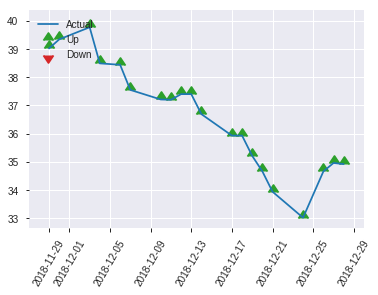


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2941927092098804
RMSE: 0.5423953440156731
LogLoss: 0.7925840456778243
Mean Per-Class Error: 0.44954670871107605
AUC: 0.5200367888582316
pr_auc: 0.5395877856885757
Gini: 0.04007357771646314
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1693178117275238: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.169318     0.68617   223
max f2                       0.169318     0.845347  223
max f0point5                 0.169318     0.57744   223
max accuracy                 0.334322     0.54251   73
max precision                0.56781      1         0
max recall                   0.169318     1         223
max specificity              0.56781      1         0
max absolute_mcc             0.477979     0.122708  3
max min_per_class_accuracy   0.308034     0.534884  111
max mean_per_class_accuracy  0.334322     0.550453  73

Gains/Lift Table: Avg response rate: 52.23 %, avg score: 32.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.478804           1.91473   1.91473            1                0.520871  1                           0.520871            0.0232558       0.0232558                  91.4729    91.4729
    2        0.0242915                   0.476873           0.638243  1.27649            0.333333         0.477241  0.666667                    0.499056            0.00775194      0.0310078                  -36.1757   27.6486
    3        0.0323887                   0.470187           0         0.957364           0                0.473011  0.5                         0.492545            0               0.0310078                  -100       -4.26357
    4        0.0404858                   0.465907           0         0.765891           0                0.467817  0.4                         0.487599            0               0.0310078                  -100       -23.4109
    5        0.0526316                   0.458205           0         0.589147           0                0.462978  0.307692                    0.481917            0               0.0310078                  -100       -41.0853
    6        0.101215                    0.433024           1.27649   0.91907            0.666667         0.449285  0.48                        0.466254            0.0620155       0.0930233                  27.6486    -8.09302
    7        0.149798                    0.383493           1.27649   1.03499            0.666667         0.411259  0.540541                    0.448418            0.0620155       0.155039                   27.6486    3.49885
    8        0.202429                    0.369664           1.47287   1.14884            0.769231         0.37537   0.6                         0.429425            0.0775194       0.232558                   47.2868    14.8837
    9        0.299595                    0.338823           0.957364  1.08674            0.5              0.351172  0.567568                    0.404046            0.0930233       0.325581                   -4.26357   8.67379
    10       0.40081                     0.318831           1.07225   1.08308            0.56             0.327391  0.565657                    0.384688            0.108527        0.434109                   7.22481    8.30789
    11       0.502024                    0.307074           0.995659  1.06545            0.52             0.312253  0.556452                    0.370085            0.100775        0.534884                   -0.434109  6.54539
    12       0.59919                     0.298358           0.957364  1.04793            0.5              0.302262  0.547297                    0.359086            0.0930233       0.627907                   -4.26357   4.79258
    13       0.700405                    0.291067           0.842481  1.01824            0.44             0.294412  0.531792                    0.34974             0.0852713       0.713178                   -15.7519   1.82372
    14       0.797571                    0.279398           0.718023  0.981663           0.375            0.285246  0.51269                     0.341883            0.0697674       0.782946                   -28.1977   -1.83371
    15       0.898785                    0.249343           1.07225   0.991864           0.56             0.265773  0.518018                    0.333312            0.108527        0.891473                   7.22481    -0.813604
    16       1                           0.169318           1.07225   1                  0.56             0.20454   0.522267             

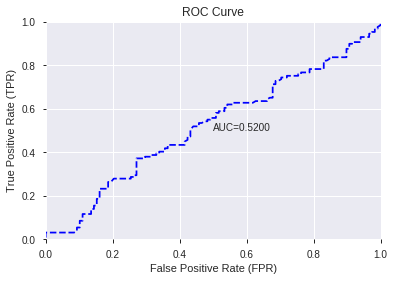

This function is available for GLM models only


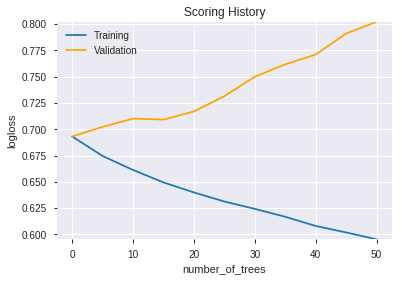

--2019-08-24 20:09:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_200850_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_200850_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_8405',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['PLUS_DM_8',
 'MACDFIX_signal_24',
 'MINUS_DI_30',
 'ROC_14',
 'ADX_12',
 'ADX_24',
 'MACDFIX_signal_14',
 'LINEARREG_SLOPE_8',
 'ROCR100_24',
 'weekday',
 'STDDEV_24',
 'MACDFIX_hist_12',
 'BBANDS_upperband_12_7_4',
 'STDDEV_30',
 'MINUS_DI_24',
 'AROONOSC_24',
 'RSI_8',
 'MINUS_DI_12',
 'BBANDS_upperband_14_0_5',
 'BBANDS_lowerband_20_6_5',
 'MACDFIX_24',
 'CCI_14',
 'BBANDS_lowerband_30_7_4',
 'BBANDS_middleband_8_8_5',
 'MA_20_3',
 'BBANDS_upperband_20_0_3',
 'BBANDS_upperband_30_1_5',
 'MAVP_20_3',
 'BBANDS_lowerband_8_3_5',
 'BBANDS_middleband_8_4_5',
 'MA_8_0',
 'KAMA_24',
 'weekday_name',
 'BBANDS_upperband_14_5_3',
 'ROCR_14',
 'BBANDS_lowerband_20_0_3',
 'LINEARREG_24',
 'MACDFIX_signal_8',
 'BBANDS_upperband_8_2_2',
 'RSI_20',
 'BBANDS_upperband_14_2_4',
 'SINH',
 'BBANDS_lowerband_12_4_3',
 'TRIMA_30',
 'aroonup_8']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [881] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_200911_model_2  0.571541  15.596047              0.500000  0.721405  0.520425
1  DeepLearning_grid_1_AutoML_20190824_200911_model_7  0.561884  17.117386              0.500000  0.720135  0.518594
2  DeepLearning_grid_1_AutoML_20190824_200911_model_3  0.525719  17.592413              0.500000  0.721119  0.520013
3  DeepLearning_grid_1_AutoML_20190824_200911_model_4  0.506110  16.016118              0.487288  0.691181  0.477731
4  DeepLearning_grid_1_AutoML_20190824_200911_model_1  0.500328  16.418356              0.500000  0.694033  0.481682
5  DeepLearning_grid_1_AutoML_20190824_200911_model_9  0.500000   0.699758              0.500000  0.503231  0.253242
6  DeepLearning_grid_1_AutoML_20190824_200911_model_5  0.500000   0.697876              0.500000  0.502319  0.252324
7  DeepLearning_grid_1_AutoML_20190824_200911_model_8  0.500000   0.696754              0.500000  0.501772  0.251775
8               DeepLearning_1_AutoML_20190824_200911  0.496124  16.457161              0.500000  0.691182  0.477733
9  DeepLearning_grid_1_AutoML_20190824_200911_model_6  0.436638   4.367526              0.500000  0.639197  0.408573

variable  relative_importance  scaled_importance  percentage
0                        TANH             1.000000           1.000000    0.004607
1                weekday_name             0.767314           0.767314    0.003535
2                         day             0.663818           0.663818    0.003058
3                HT_TRENDMODE             0.655824           0.655824    0.003021
4                         SIN             0.644321           0.644321    0.002968
..                        ...                  ...                ...         ...
964  BBANDS_middleband_20_6_5             0.180926           0.180926    0.000833
965                   MA_30_2             0.180278           0.180278    0.000830
966                 MAVP_14_7             0.180093           0.180093    0.000830
967   BBANDS_upperband_12_4_2             0.179876           0.179876    0.000829
968    BBANDS_upperband_8_2_2             0.179815           0.179815    0.000828

[969 rows x 4 columns]

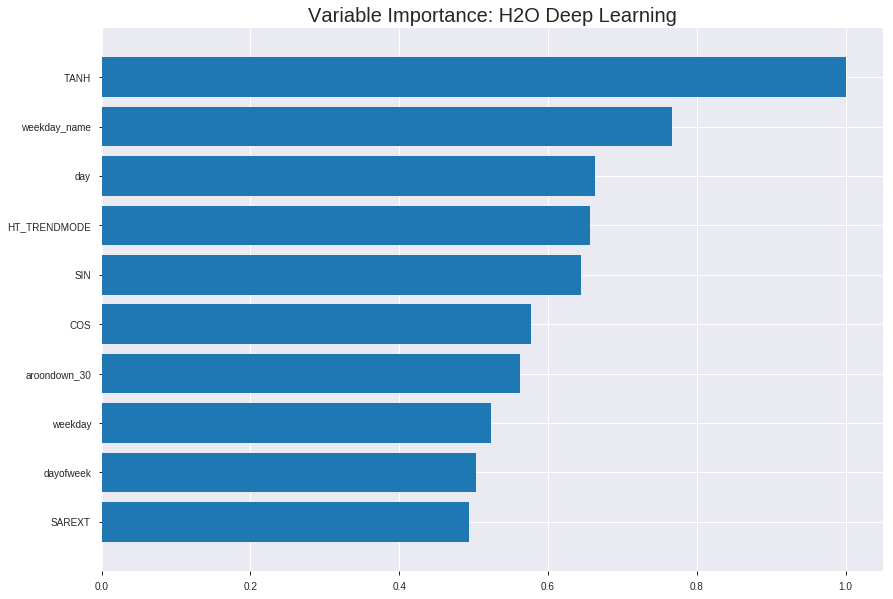

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_200911_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2571002455500531
RMSE: 0.5070505354992273
LogLoss: 0.7232845272125553
Mean Per-Class Error: 0.4598421380599599
AUC: 0.5375932977913176
pr_auc: 0.6037376893821536
Gini: 0.07518659558263519
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32490016357999807: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      12   703   0.9832   (703.0/715.0)
1      5    1005  0.005    (5.0/1010.0)
Total  17   1708  0.4104   (708.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.3249       0.739514   389
max f2                       0.303475     0.876432   396
max f0point5                 0.421649     0.645051   345
max accuracy                 0.421649     0.594783   345
max precision                0.974316     1          0
max recall                   0.303475     1          396
max specificity              0.974316     1          0
max absolute_mcc             0.421649     0.0873593  345
max min_per_class_accuracy   0.57275      0.534653   218
max mean_per_class_accuracy  0.564642     0.540158   227

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 60.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.934087           0.948845  0.948845           0.555556         0.946953  0.555556                    0.946953            0.00990099      0.00990099                 -5.11551  -5.11551
    2        0.0202899                   0.914918           1.10513   1.02475            0.647059         0.922863  0.6                         0.935253            0.0108911       0.0207921                  10.5125   2.47525
    3        0.0301449                   0.904249           0.904193  0.985339           0.529412         0.909481  0.576923                    0.926827            0.00891089      0.029703                   -9.58066  -1.46611
    4        0.04                        0.896739           0.904193  0.965347           0.529412         0.900088  0.565217                    0.920239            0.00891089      0.0386139                  -9.58066  -3.46535
    5        0.0504348                   0.886187           1.04373   0.981564           0.611111         0.891571  0.574713                    0.914308            0.0108911       0.049505                   4.37294   -1.84363
    6        0.10029                     0.843031           0.973118  0.977365           0.569767         0.864345  0.572254                    0.889471            0.0485149       0.0980198                  -2.68823  -2.26349
    7        0.150145                    0.802319           1.07242   1.00893            0.627907         0.823759  0.590734                    0.867651            0.0534653       0.151485                   7.24154   0.892618
    8        0.2                         0.761371           1.13199   1.0396             0.662791         0.782771  0.608696                    0.846493            0.0564356       0.207921                   13.1994   3.9604
    9        0.30029                     0.658733           1.04647   1.0419             0.612717         0.710308  0.610039                    0.80101             0.10495         0.312871                   4.64717   4.18976
    10       0.4                         0.597785           1.13199   1.06436            0.662791         0.622216  0.623188                    0.756441            0.112871        0.425743                   13.1994   6.43564
    11       0.50029                     0.573825           1.04647   1.06077            0.612717         0.583588  0.621089                    0.721791            0.10495         0.530693                   4.64717   6.07712
    12       0.6                         0.548691           0.923469  1.03795            0.540698         0.561994  0.607729                    0.695235            0.0920792       0.622772                   -7.65312  3.79538
    13       0.69971                     0.514644           0.923469  1.02164            0.540698         0.531987  0.598177                    0.671972            0.0920792       0.714851                   -7.65312  2.16394
    14       0.8                         0.475269           1.02673   1.02228            0.601156         0.496948  0.598551                    0.65003             0.10297         0.817822                   2.6727    2.22772
    15       0.89971                     0.427977           1.02277   1.02233            0.598837         0.45445   0.598582                    0.628355            0.10198         0.919802                   2.27665   2.23315
    16       1                           0.270715           0.799662  1                  0.468208         0.383112  0.585507                    0.60376     



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.33263922620271674
RMSE: 0.5767488415269828
LogLoss: 1.8907236962239526
Mean Per-Class Error: 0.46683967704728957
AUC: 0.5040538706832214
pr_auc: 0.5709065494076874
Gini: 0.008107741366442767
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.7527738051682795e-06: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.75277e-06  0.73913   399
max f2                       2.75277e-06  0.876289  399
max f0point5                 0.000416647  0.640171  396
max accuracy                 0.000416647  0.586207  396
max precision                0.530888     0.611465  270
max recall                   2.75277e-06  1         399
max specificity              0.953931     0.995098  0
max absolute_mcc             0.905889     0.109927  16
max min_per_class_accuracy   0.638578     0.514706  208
max mean_per_class_accuracy  0.530888     0.53316   270

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 56.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.919236           0.341176  0.341176           0.2              0.931818     0.2                         0.931818            0.00346021      0.00346021                 -65.8824  -65.8824
    2        0.020284                    0.912685           0.682353  0.511765           0.4              0.915037     0.3                         0.923428            0.00692042      0.0103806                  -31.7647  -48.8235
    3        0.030426                    0.908216           0.682353  0.568627           0.4              0.910934     0.333333                    0.919263            0.00692042      0.017301                   -31.7647  -43.1373
    4        0.040568                    0.903834           0.682353  0.597059           0.4              0.906466     0.35                        0.916064            0.00692042      0.0242215                  -31.7647  -40.2941
    5        0.0507099                   0.899895           1.02353   0.682353           0.6              0.901691     0.4                         0.913189            0.0103806       0.0346021                  2.35294   -31.7647
    6        0.10142                     0.882897           1.09176   0.887059           0.64             0.891674     0.52                        0.902432            0.0553633       0.0899654                  9.17647   -11.2941
    7        0.150101                    0.863467           1.13725   0.968203           0.666667         0.871699     0.567568                    0.892464            0.0553633       0.145329                   13.7255   -3.17965
    8        0.200811                    0.842401           1.02353   0.982175           0.6              0.852863     0.575758                    0.882464            0.0519031       0.197232                   2.35294   -1.78253
    9        0.300203                    0.806996           1.04442   1.00278            0.612245         0.826872     0.587838                    0.864059            0.103806        0.301038                   4.44178   0.278219
    10       0.399594                    0.723371           0.905162  0.978501           0.530612         0.76981      0.573604                    0.840616            0.0899654       0.391003                   -9.48379  -2.1499
    11       0.501014                    0.639909           1.19412   1.02215            0.7              0.680548     0.59919                     0.808214            0.121107        0.512111                   19.4118   2.21481
    12       0.600406                    0.564899           1.11405   1.03736            0.653061         0.606942     0.608108                    0.774895            0.110727        0.622837                   11.4046   3.73609
    13       0.699797                    0.43411            0.905162  1.01858            0.530612         0.509822     0.597101                    0.737247            0.0899654       0.712803                   -9.48379  1.85848
    14       0.799189                    0.269659           0.870348  1.00015            0.510204         0.355958     0.586294                    0.689828            0.0865052       0.799308                   -12.9652  0.0149298
    15       0.89858                     0.00209545         1.07923   1.0089             0.632653         0.125177     0.591422                    0.627372            0.107266        0.906574                   7.92317   0.889656
    16       1                           1.23726e-28        0.921176  1                  0.54     


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 20:10:45  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 20:10:48  1 min 35.935 sec  496 obs/sec       0.746667  1             1288       0.646679         4.34214             -0.723171      0.502888        0.376925           1.2335           0.414493                         0.686524           10.4526               -0.943019        0.494869          0.43499              0.682353           0.413793
    2019-08-24 20:11:02  1 min 50.228 sec  488 obs/sec       4.39652   6             7584       0.532774         0.777835            -0.169596      0.525562        0.608521           1.2335           0.413913                         0.71578            7.69886               -1.11215         0.501883          0.595705             1.02353            0.413793
    2019-08-24 20:11:17  2 min  4.627 sec  528 obs/sec       8.77101   12            15130      0.503641         0.708675            -0.0451826     0.518693        0.585365           0.664191         0.413333                         0.620552           3.74242               -0.587529        0.495412          0.574565             0.682353           0.413793
    2019-08-24 20:11:30  2 min 18.365 sec  554 obs/sec       13.1878   18            22749      0.507787         0.72289             -0.0624615     0.510308        0.586006           1.04373          0.414493                         0.629362           3.74146               -0.632926        0.493826          0.601615             1.70588            0.413793
    2019-08-24 20:11:45  2 min 33.344 sec  577 obs/sec       18.3165   25            31596      0.513023         0.72923             -0.0844894     0.540924        0.627568           1.42327          0.414493                         0.691989           5.98532               -0.974076        0.496913          0.585749             0.682353           0.413793
    2019-08-24 20:12:00  2 min 48.185 sec  594 obs/sec       23.5136   32            40561      0.519158         0.789691            -0.11058       0.526401        0.588653           0.948845         0.411594                         0.622358           5.54676               -0.596786        0.494275          0.38579              1.03628            0.411765
    2019-08-24 20:12:14  3 min  2.423 sec  609 obs/sec       28.6626   39            49443      0.505063         0.716382            -0.0510938     0.533476        0.593503           0.85396          0.410435                         0.589078           3.18041               -0.430578        0.499355          0.481526             0.921176           0.407708
    2019-08-24 20:12:29  3 min 16.713 sec  621 obs/sec       33.8696   46            58425      0.51245          0.742148            -0.0820659     0.515222        0.58289            0.948845         0.409855                         0.60292            3.57781               -0.498597        0.500526          0.482071             0.995098           0.40568
    2019-08-24 20:12:42 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
TANH                      1.0                    1.0                  0.004606765939482491
weekday_name              0.7673140168190002     0.7673140168190002   0.003534836077569265
day                       0.6638177037239075     0.6638177037239075   0.0030580527875407764
HT_TRENDMODE              0.6558243036270142     0.6558243036270142   0.0030212290642337523
SIN                       0.6443206667900085     0.6443206667900085   0.0029682345018728585
---                       ---                    ---                  ---
BBANDS_middleband_20_6_5  0.18092644214630127    0.18092644214630127  0.00083348577123133
MA_30_2                   0.1802779734134674     0.1802779734134674   0.0008304984275600917
MAVP_14_7                 0.18009327352046967    0.18009327352046967  0.0008296475583840036
BBANDS_upperband_12_4_2   0.17987622320652008    0.17987622320652008  0.0008286476583905467
BBANDS_upperband_8_2_2    0.17981477081775665    0.17981477081775665  0.0008283645616190915


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5668016194331984)

('F1', 0.6861702127659575)

('auc', 0.5715411903823413)

('logloss', 15.596047047254924)

('mean_per_class_error', 0.4259295756142425)

('rmse', 0.7214052235140574)

('mse', 0.5204254965133671)

deeplearning prediction progress: |███████████████████████████████████████| 100%


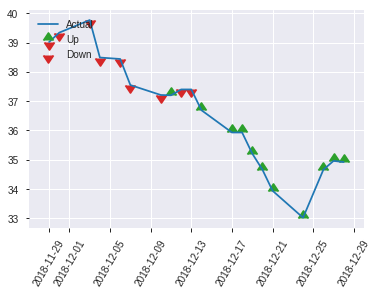


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5204254965133671
RMSE: 0.7214052235140574
LogLoss: 15.596047047254924
Mean Per-Class Error: 0.4259295756142425
AUC: 0.5715411903823413
pr_auc: 0.5718375974042941
Gini: 0.1430823807646826
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.461088409386464e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       6.46109e-48  0.68617   134
max f2                       6.46109e-48  0.845347  134
max f0point5                 5.16814e-45  0.586466  133
max accuracy                 3.02974e-26  0.566802  83
max precision                0.966495     1         0
max recall                   6.46109e-48  1         134
max specificity              0.966495     1         0
max absolute_mcc             3.02974e-26  0.156199  83
max min_per_class_accuracy   5.48734e-41  0.550847  124
max mean_per_class_accuracy  3.02974e-26  0.57407   83

Gains/Lift Table: Avg response rate: 52.23 %, avg score:  2.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.845323           0.638243  0.638243           0.333333         0.920229      0.333333                    0.920229            0.00775194      0.00775194                 -36.1757   -36.1757
    2        0.0202429                   0.78818            0.957364  0.765891           0.5              0.815045      0.4                         0.878156            0.00775194      0.0155039                  -4.26357   -23.4109
    3        0.0323887                   0.196436           0.638243  0.718023           0.333333         0.563464      0.375                       0.760146            0.00775194      0.0232558                  -36.1757   -28.1977
    4        0.0404858                   0.00178096         1.91473   0.957364           1                0.0785845     0.5                         0.623834            0.0155039       0.0387597                  91.4729    -4.26357
    5        0.0526316                   0.00010789         1.27649   1.03101            0.666667         0.00106398    0.538462                    0.480118            0.0155039       0.0542636                  27.6486    3.10078
    6        0.101215                    6.50256e-08        1.43605   1.22543            0.75             1.34249e-05   0.64                        0.249668            0.0697674       0.124031                   43.6047    22.5426
    7        0.149798                    2.15946e-10        1.27649   1.24199            0.666667         1.66227e-08   0.648649                    0.168694            0.0620155       0.186047                   27.6486    24.1986
    8        0.202429                    7.54042e-13        0.883721  1.14884            0.461538         6.50481e-11   0.6                         0.124834            0.0465116       0.232558                   -11.6279   14.8837
    9        0.299595                    9.76185e-23        1.19671   1.16436            0.625            4.97726e-14   0.608108                    0.0843472           0.116279        0.348837                   19.6705    16.4362
    10       0.40081                     2.39314e-30        1.07225   1.1411             0.56             9.80268e-24   0.59596                     0.0630474           0.108527        0.457364                   7.22481    14.1101
    11       0.502024                    6.93423e-41        0.91907   1.09634            0.48             1.50535e-31   0.572581                    0.0503362           0.0930233       0.550388                   -8.09302   9.63366
    12       0.59919                     2.75758e-58        1.03714   1.08674            0.541667         5.1199e-42    0.567568                    0.0421736           0.100775        0.651163                   3.71447    8.67379
    13       0.700405                    2.34078e-85        0.765891  1.04037            0.4              7.18112e-61   0.543353                    0.0360792           0.0775194       0.728682                   -23.4109   4.03728
    14       0.797571                    1.17336e-142       0.877584  1.02054            0.458333         3.88495e-88   0.532995                    0.0316837           0.0852713       0.813953                   -12.2416   2.05407
    15       0.898785                    6.94419e-280       0.842481  1.00049            0.44             1.77371e-145  0.522523                    0.0281157           0.0852713       0.899225                   -15.7519   0.0488861
    16       1                           0                  0.995659  

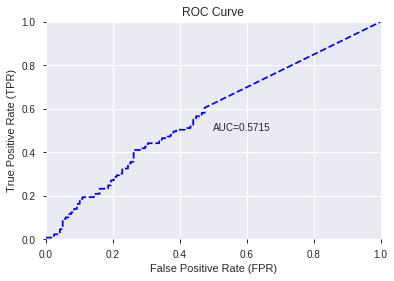

This function is available for GLM models only


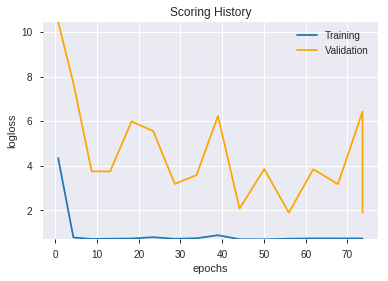

--2019-08-24 20:40:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_200911_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_200911_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_8405',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TANH',
 'weekday_name',
 'day',
 'HT_TRENDMODE',
 'SIN',
 'COS',
 'aroondown_30',
 'weekday',
 'dayofweek',
 'SAREXT',
 'aroonup_24',
 'days_in_month',
 'HT_DCPERIOD',
 'aroondown_20',
 'STOCHRSI_fastk',
 'aroonup_8',
 'aroondown_14',
 'aroondown_8',
 'aroonup_14',
 'is_quarter_end',
 'STOCHRSI_fastd',
 'STOCHF_fastk',
 'STOCH_slowd',
 'aroondown_12',
 'aroonup_20',
 'AROONOSC_24',
 'weekofyear',
 'MACDEXT_hist',
 'aroondown_24',
 'aroonup_12',
 'is_month_end',
 'month',
 'week',
 'AROONOSC_20',
 'ATR_30',
 'aroonup_30',
 'AROONOSC_14',
 'DX_8',
 'quarter',
 'STOCH_slowk',
 'AROONOSC_8',
 'HT_PHASOR_quadrature',
 'STOCHF_fastd',
 'dayofyear',
 'MINUS_DM_30',
 'AROONOSC_30',
 'PLUS_DM_30',
 'DX_12',
 'TRANGE',
 'HT_PHASOR_inphase',
 'ATR_24',
 'AROONOSC_12',
 'MINUS_DM_20',
 'WILLR_14',
 'is_month_start',
 'MINUS_DM_24',
 'TAN',
 'ATAN',
 'DX_14',
 'ADXR_8',
 'ATR_20',
 'WILLR_20',
 'ADX_8',
 'is_quarter_start',
 'ADXR_12',
 'WILLR_12',
 'DX_20',
 'ROCR_24',
 'WILLR_8',
 'ROCR_30',
 '

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_204103_model_1  0.522697  17.625458                   0.5  0.720883  0.519672

variable  relative_importance  scaled_importance    percentage
0               weekday_name         7.101164e-03           1.000000  1.844983e-02
1              days_in_month         6.464107e-03           0.910288  1.679466e-02
2                        EXP         6.304008e-03           0.887743  1.637871e-02
3                       SINH         6.287812e-03           0.885462  1.633662e-02
4                       COSH         6.285311e-03           0.885110  1.633013e-02
..                       ...                  ...                ...           ...
964  BBANDS_lowerband_12_2_3         5.297627e-07           0.000075  1.376398e-06
965  BBANDS_lowerband_24_2_2         5.179554e-07           0.000073  1.345721e-06
966  BBANDS_upperband_14_6_3         4.831476e-07           0.000068  1.255286e-06
967  BBANDS_lowerband_14_5_5         4.805648e-07           0.000068  1.248575e-06
968                  KAMA_20         4.802417e-08           0.000007  1.247736e-07

[969 rows x 4 columns]

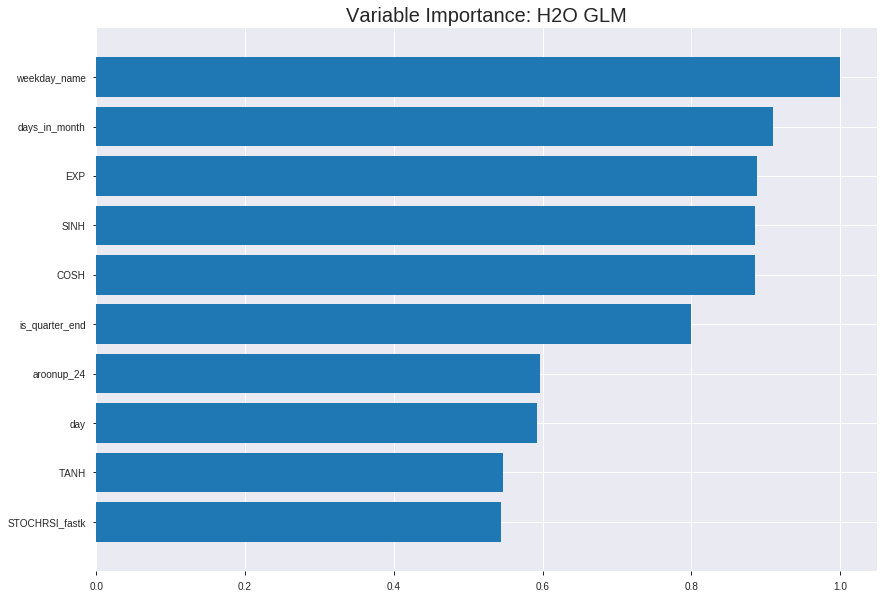

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_204103_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24123105205494147
RMSE: 0.49115277873075447
LogLoss: 0.675455996955622
Null degrees of freedom: 1724
Residual degrees of freedom: 755
Null deviance: 2340.659668736101
Residual deviance: 2330.323189496896
AIC: 4270.323189496896
AUC: 0.5612642802741813
pr_auc: 0.624312732009251
Gini: 0.12252856054836259
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5197625721753903: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    714   0.9986   (714.0/715.0)
1      0    1010  0        (0.0/1010.0)
Total  1    1724  0.4139   (714.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.519763     0.738844  398
max f2                       0.519763     0.876128  398
max f0point5                 0.574826     0.648366  267
max accuracy                 0.573491     0.593623  274
max precision                0.666036     1         0
max recall                   0.519763     1         398
max specificity              0.666036     1         0
max absolute_mcc             0.577038     0.132252  254
max min_per_class_accuracy   0.584023     0.541259  212
max mean_per_class_accuracy  0.577038     0.563193  254

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 58.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.638391           1.2335    1.2335             0.722222         0.649588  0.722222                    0.649588            0.0128713       0.0128713                  23.3498   23.3498
    2        0.0202899                   0.632871           1.00466   1.12235            0.588235         0.635657  0.657143                    0.642821            0.00990099      0.0227723                  0.465929  12.2348
    3        0.0301449                   0.629505           1.00466   1.08387            0.588235         0.631127  0.634615                    0.638998            0.00990099      0.0326733                  0.465929  8.38728
    4        0.04                        0.625228           1.00466   1.06436            0.588235         0.627369  0.623188                    0.636133            0.00990099      0.0425743                  0.465929  6.43564
    5        0.0504348                   0.6226             1.13861   1.07972            0.666667         0.62352   0.632184                    0.633523            0.0118812       0.0544554                  13.8614   7.972
    6        0.10029                     0.611317           1.01284   1.04647            0.593023         0.61619   0.612717                    0.624907            0.050495        0.10495                    1.28367   4.64717
    7        0.150145                    0.604445           1.01284   1.0353             0.593023         0.607509  0.606178                    0.61913             0.050495        0.155446                   1.28367   3.53033
    8        0.2                         0.599639           1.23129   1.08416            0.72093          0.601821  0.634783                    0.614815            0.0613861       0.216832                   23.1292   8.41584
    9        0.30029                     0.592564           1.10571   1.09135            0.647399         0.595916  0.638996                    0.608504            0.110891        0.327723                   10.5706   9.13548
    10       0.4                         0.588286           1.0327    1.07673            0.604651         0.59036   0.630435                    0.603981            0.10297         0.430693                   3.26963   7.67327
    11       0.50029                     0.584279           1.04647   1.07067            0.612717         0.58623   0.626883                    0.600422            0.10495         0.535644                   4.64717   7.06665
    12       0.6                         0.580413           1.05256   1.06766            0.616279         0.582373  0.625121                    0.597423            0.10495         0.640594                   5.25558   6.76568
    13       0.69971                     0.575472           1.08235   1.06975            0.633721         0.577991  0.626346                    0.594654            0.107921        0.748515                   8.23452   6.97499
    14       0.8                         0.570334           0.78979   1.03465            0.462428         0.572926  0.605797                    0.59193             0.0792079       0.827723                   -21.021   3.46535
    15       0.89971                     0.562741           0.834101  1.01243            0.488372         0.567027  0.592784                    0.58917             0.0831683       0.910891                   -16.5899  1.24273
    16       1                           0.519203           0.888514  1                  0.520231         0.552647  0.585507                    0.585507           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.38694541114657044
RMSE: 0.6220493639146096
LogLoss: 4.298040456299502
Null degrees of freedom: 492
Residual degrees of freedom: -477
Null deviance: 668.7154569489843
Residual deviance: 9046.176182834904
AIC: 10986.176182834904
AUC: 0.49955051224642105
pr_auc: 0.5905703706507858
Gini: -0.0008989755071578953
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.4825610096971248e-08: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.48256e-08  0.73913    399
max f2                       2.48256e-08  0.876289   399
max f0point5                 2.48256e-08  0.639098   399
max accuracy                 2.48256e-08  0.586207   399
max precision                0.604565     0.6875     15
max recall                   2.48256e-08  1          399
max specificity              0.638069     0.995098   0
max absolute_mcc             0.562064     0.0613216  80
max min_per_class_accuracy   0.413551     0.512111   244
max mean_per_class_accuracy  0.562064     0.523068   80

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 30.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.621455           1.02353   1.02353            0.6              0.634771     0.6                         0.634771            0.0103806       0.0103806                  2.35294   2.35294
    2        0.020284                    0.610678           1.02353   1.02353            0.6              0.61488      0.6                         0.624826            0.0103806       0.0207612                  2.35294   2.35294
    3        0.030426                    0.604783           1.36471   1.13725            0.8              0.607173     0.666667                    0.618942            0.0138408       0.0346021                  36.4706   13.7255
    4        0.040568                    0.596343           0.341176  0.938235           0.2              0.602038     0.55                        0.614716            0.00346021      0.0380623                  -65.8824  -6.17647
    5        0.0507099                   0.586513           1.36471   1.02353            0.8              0.588966     0.6                         0.609566            0.0138408       0.0519031                  36.4706   2.35294
    6        0.10142                     0.572462           1.09176   1.05765            0.64             0.577175     0.62                        0.59337             0.0553633       0.107266                   9.17647   5.76471
    7        0.150101                    0.565126           1.06618   1.06041            0.625            0.569144     0.621622                    0.585513            0.0519031       0.15917                    6.61765   6.04134
    8        0.200811                    0.558633           0.955294  1.03387            0.56             0.561231     0.606061                    0.579381            0.0484429       0.207612                   -4.47059  3.38681
    9        0.300203                    0.544271           1.0096    1.02583            0.591837         0.551621     0.601351                    0.57019             0.100346        0.307958                   0.960384  2.58347
    10       0.399594                    0.515849           0.870348  0.98716            0.510204         0.530568     0.57868                     0.560335            0.0865052       0.394464                   -12.9652  -1.28397
    11       0.501014                    0.412285           1.16      1.02215            0.68             0.466753     0.59919                     0.541391            0.117647        0.512111                   16        2.21481
    12       0.600406                    0.115122           0.80072   0.985493           0.469388         0.262316     0.577703                    0.495193            0.0795848       0.591696                   -19.928   -1.45072
    13       0.699797                    0.00882048         0.97479   0.983973           0.571429         0.0556026    0.576812                    0.432758            0.0968858       0.688581                   -2.52101  -1.60273
    14       0.799189                    5.33485e-05        1.11405   1.00015            0.653061         0.00196888   0.586294                    0.379183            0.110727        0.799308                   11.4046   0.0149298
    15       0.89858                     3.19466e-17        1.07923   1.0089             0.632653         1.13335e-05  0.591422                    0.337243            0.107266        0.906574                   7.92317   0.889656
    16       1                           1.25366e-159       0.921176  1                  0.54          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 20:41:06  0.000 sec   2            2.5       970           1.35091           18.3492
    2019-08-24 20:41:08  1.692 sec   4            1.8       970           1.34972           23.6982
    2019-08-24 20:41:09  3.373 sec   6            1.3       970           1.34832           30.339
    2019-08-24 20:41:11  5.034 sec   8            0.97      970           1.34667           38.0809
    2019-08-24 20:41:13  6.700 sec   10           0.71      970           1.34478           46.3161

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5222672064777328)

('F1', 0.6861702127659575)

('auc', 0.5226974116410459)

('logloss', 17.625457612009324)

('mean_per_class_error', 0.47612008934437)

('rmse', 0.7208825561800967)

('mse', 0.5196716598047503)

glm prediction progress: |████████████████████████████████████████████████| 100%


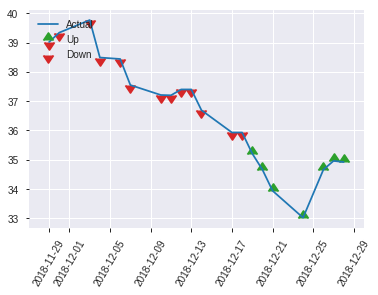


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5196716598047503
RMSE: 0.7208825561800967
LogLoss: 17.625457612009324
Null degrees of freedom: 246
Residual degrees of freedom: -723
Null deviance: 345.9465433426434
Residual deviance: 112766.91560674446
AIC: 114706.91560674446
AUC: 0.5226974116410459
pr_auc: 0.5750744491856398
Gini: 0.04539482328209177
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.2232635510111756e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       6.22326e-49  0.68617    25
max f2                       6.22326e-49  0.845347   25
max f0point5                 6.22326e-49  0.57744    25
max accuracy                 6.22326e-49  0.522267   25
max precision                0.400026     1          0
max recall                   6.22326e-49  1          25
max specificity              0.400026     1          0
max absolute_mcc             2.30108e-35  0.0810485  17
max min_per_class_accuracy   1.00457e-45  0.124031   24
max mean_per_class_accuracy  1.00457e-45  0.52388    24

Gains/Lift Table: Avg response rate: 52.23 %, avg score:  0.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.00358334         1.27649   1.27649            0.666667         0.163384      0.666667                    0.163384            0.0155039       0.0155039                  27.6486    27.6486
    2        0.0202429                   0.000420591        0.957364  1.14884            0.5              0.00199123    0.6                         0.0988272           0.00775194      0.0232558                  -4.26357   14.8837
    3        0.0323887                   2.75324e-10        0         0.718023           0                0.00014639    0.375                       0.0618219           0               0.0232558                  -100       -28.1977
    4        0.0404858                   2.10266e-21        1.91473   0.957364           1                1.32756e-10   0.5                         0.0494575           0.0155039       0.0387597                  91.4729    -4.26357
    5        0.0526316                   2.69237e-27        1.27649   1.03101            0.666667         7.22866e-22   0.538462                    0.0380442           0.0155039       0.0542636                  27.6486    3.10078
    6        0.101215                    4.79895e-46        1.43605   1.22543            0.75             4.35222e-30   0.64                        0.019783            0.0697674       0.124031                   43.6047    22.5426
    7        0.149798                    4.83103e-60        1.27649   1.24199            0.666667         1.1513e-47    0.648649                    0.0133669           0.0620155       0.186047                   27.6486    24.1986
    8        0.202429                    7.37942e-73        0.883721  1.14884            0.461538         1.33462e-61   0.6                         0.0098915           0.0465116       0.232558                   -11.6279   14.8837
    9        0.299595                    2.66964e-126       1.19671   1.16436            0.625            3.20602e-76   0.608108                    0.00668345          0.116279        0.348837                   19.6705    16.4362
    10       0.40081                     2.20115e-171       1.07225   1.1411             0.56             2.34534e-128  0.59596                     0.00499571          0.108527        0.457364                   7.22481    14.1101
    11       0.502024                    1.51376e-228       0.995659  1.11178            0.52             5.76671e-174  0.580645                    0.00398851          0.100775        0.55814                    -0.434109  11.1778
    12       1                           0                  0.887313  1                  0.463415         7.44615e-233  0.522267                    0.00200233          0.44186         1                          -11.2687   0

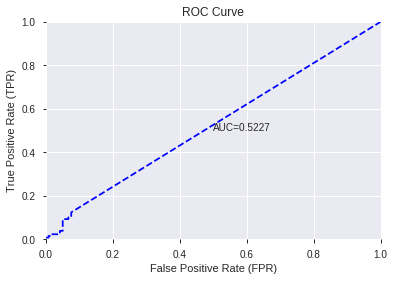

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


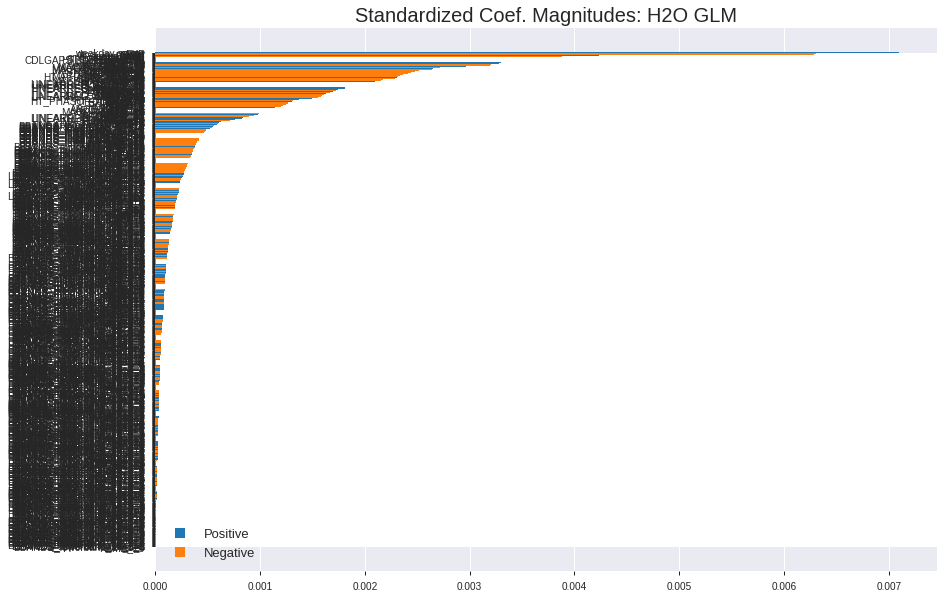

'log_likelihood'
--2019-08-24 20:41:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.228.168
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.228.168|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_204103_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_204103_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_8405',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['weekday_name',
 'days_in_month',
 'EXP',
 'SINH',
 'COSH',
 'is_quarter_end',
 'aroonup_24',
 'day',
 'TANH',
 'STOCHRSI_fastk',
 'TAN',
 'HT_TRENDMODE',
 'SAREXT',
 'is_quarter_start',
 'CDLGAPSIDESIDEWHITE',
 'MOM_30',
 'ROCR100_30',
 'ROCR_30',
 'ROCP_30',
 'is_month_end',
 'ROC_30',
 'DX_8',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'VAR_8',
 'AROONOSC_24',
 'MACDFIX_signal_8',
 'MACD_signal',
 'MACDFIX_signal_12',
 'aroondown_30',
 'dayofyear',
 'MOM_14',
 'MACDFIX_signal_14',
 'MACDFIX_8',
 'STOCHRSI_fastd',
 'ADX_24',
 'MACDFIX_12',
 'MACD',
 'TRIX_12',
 'ADX_20',
 'TRIX_14',
 'MACDFIX_14',
 'CCI_24',
 'MACDFIX_signal_20',
 'month',
 'HT_PHASOR_inphase',
 'STOCH_slowk',
 'STOCHF_fastd',
 'MACDFIX_24',
 'MACDFIX_20',
 'week',
 'weekofyear',
 'TRIX_8',
 'MACDFIX_signal_24',
 'PLUS_DM_14',
 'VAR_20',
 'PLUS_DM_12',
 'LINEARREG_ANGLE_20',
 'LINEARREG_SLOPE_20',
 'PLUS_DM_20',
 'CCI_30',
 'STOCHF_fastk',
 'aroonup_30',
 'PLUS_DM_24',
 'LINEARREG_ANGLE_30',
 'LINEARREG_SLOP

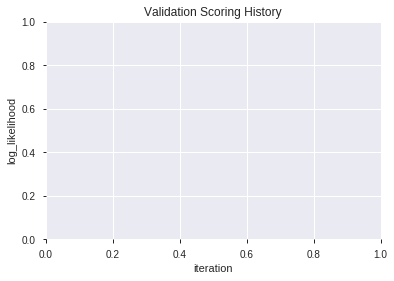

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_204136_model_6  0.516818  0.729165              0.500000  0.515686  0.265932
1  XGBoost_grid_1_AutoML_20190824_204136_model_1  0.505814  0.751809              0.491525  0.525490  0.276140
2  XGBoost_grid_1_AutoML_20190824_204136_model_4  0.490146  0.701989              0.500000  0.504320  0.254339
3  XGBoost_grid_1_AutoML_20190824_204136_model_7  0.489292  0.731457              0.500000  0.517457  0.267761
4  XGBoost_grid_1_AutoML_20190824_204136_model_2  0.488175  0.706816              0.500000  0.506594  0.256637
5               XGBoost_3_AutoML_20190824_204136  0.485416  0.723981              0.491525  0.514504  0.264715
6               XGBoost_1_AutoML_20190824_204136  0.484036  0.726175              0.495763  0.515497  0.265737
7  XGBoost_grid_1_AutoML_20190824_204136_model_5  0.480160  0.751487              0.500000  0.525387  0.276031
8  XGBoost_grid_1_AutoML_20190824_204136_model_3  0.469255  0.771300              0.486565  0.534593  0.285790
9               XGBoost_2_AutoML_20190824_204136  0.458547  0.735462              0.500000  0.519784  0.270175

variable  relative_importance  scaled_importance  percentage
0    HT_PHASOR_quadrature           192.185867           1.000000    0.029371
1                  MOM_30           110.277672           0.573807    0.016853
2                   MOM_8            94.500702           0.491715    0.014442
3                STDDEV_8            88.878609           0.462462    0.013583
4                  MOM_14            84.570770           0.440047    0.012924
..                    ...                  ...                ...         ...
265                ATR_14             3.168373           0.016486    0.000484
266                  mama             3.001508           0.015618    0.000459
267    LINEARREG_ANGLE_12             2.797572           0.014557    0.000428
268               DEMA_12             2.062745           0.010733    0.000315
269     LINEARREG_SLOPE_8             1.300416           0.006766    0.000199

[270 rows x 4 columns]

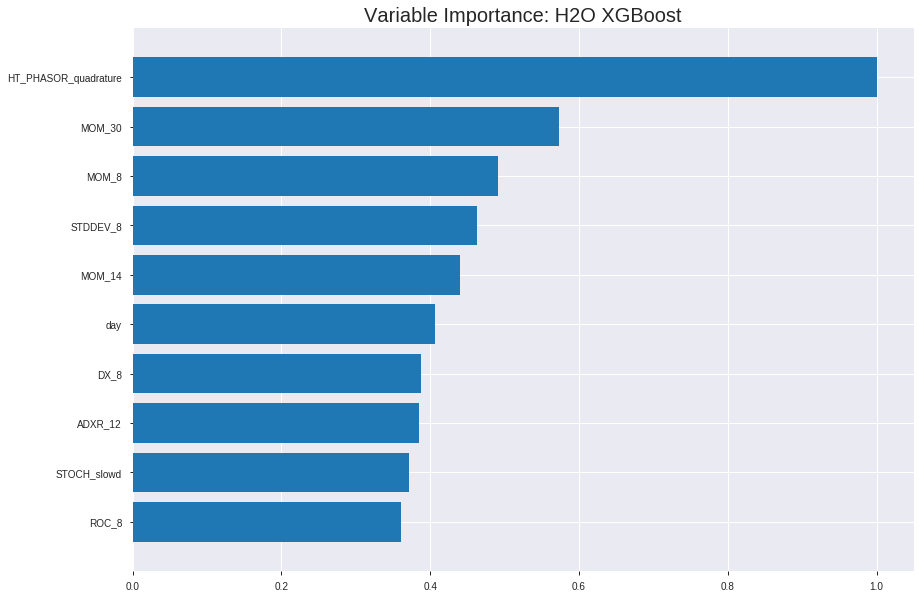

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_204136_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17910790911632923
RMSE: 0.4232114236600062
LogLoss: 0.545745057567497
Mean Per-Class Error: 0.13114311431143122
AUC: 0.9426573426573427
pr_auc: 0.9560374909536655
Gini: 0.8853146853146854
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5563758730888366: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      570  145   0.2028   (145.0/715.0)
1      75   935   0.0743   (75.0/1010.0)
Total  645  1080  0.1275   (220.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.556376     0.894737  213
max f2                       0.513091     0.931869  253
max f0point5                 0.590301     0.905116  177
max accuracy                 0.568679     0.873043  200
max precision                0.805167     1         0
max recall                   0.397806     1         347
max specificity              0.805167     1         0
max absolute_mcc             0.568679     0.737998  200
max min_per_class_accuracy   0.577674     0.865734  192
max mean_per_class_accuracy  0.573731     0.868857  196

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 57.94 %



group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ----------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.757745           1.70792     1.70792            1                0.773523  1                           0.773523            0.0178218       0.0178218                  70.7921   70.7921
    2        0.0202899                   0.748774           1.70792     1.70792            1                0.753925  1                           0.764004            0.0168317       0.0346535                  70.7921   70.7921
    3        0.0301449                   0.739691           1.70792     1.70792            1                0.743711  1                           0.75737             0.0168317       0.0514851                  70.7921   70.7921
    4        0.04                        0.729715           1.70792     1.70792            1                0.734496  1                           0.751734            0.0168317       0.0683168                  70.7921   70.7921
    5        0.0504348                   0.721995           1.70792     1.70792            1                0.726654  1                           0.746545            0.0178218       0.0861386                  70.7921   70.7921
    6        0.10029                     0.701415           1.68806     1.69805            0.988372         0.71143   0.99422                     0.729089            0.0841584       0.170297                   68.8061   69.8048
    7        0.150145                    0.683269           1.68806     1.69473            0.988372         0.692451  0.992278                    0.716924            0.0841584       0.254455                   68.8061   69.4732
    8        0.2                         0.669208           1.68806     1.69307            0.988372         0.675603  0.991304                    0.706623            0.0841584       0.338614                   68.8061   69.3069
    9        0.30029                     0.644226           1.61907     1.66836            0.947977         0.657149  0.976834                    0.6901              0.162376        0.50099                    61.9069   66.8355
    10       0.4                         0.618619           1.57883     1.64604            0.924419         0.631175  0.963768                    0.675411            0.157426        0.658416                   57.8834   64.604
    11       0.50029                     0.593815           1.41175     1.59907            0.82659          0.60604   0.936269                    0.661505            0.141584        0.8                        41.175    59.9073
    12       0.6                         0.56534            1.00291     1.5                0.587209         0.580609  0.878261                    0.648062            0.1             0.9                        0.290698  50
    13       0.69971                     0.529983           0.635505    1.37681            0.372093         0.547742  0.806131                    0.633766            0.0633663       0.963366                   -36.4495  37.6808
    14       0.8                         0.49403            0.266554    1.23762            0.156069         0.512157  0.724638                    0.618521            0.0267327       0.990099                   -73.3446  23.7624
    15       0.89971                     0.43931            0.0893679   1.11037            0.0523256        0.469716  0.650129                    0.602029            0.00891089      0.99901                    -91.0632  11.0369
    16       1                           0.216904           0.00987237  1                  0.00578035       0.376702  0.585507       



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2783190439020079
RMSE: 0.5275595169286664
LogLoss: 0.7527231915663345
Mean Per-Class Error: 0.47563437139561704
AUC: 0.5038503290589592
pr_auc: 0.5879052608571604
Gini: 0.007700658117918424
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25682568550109863: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   191  0.9363   (191.0/204.0)
1      5    284  0.0173   (5.0/289.0)
Total  18   475  0.3976   (196.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.256826     0.743455  382
max f2                       0.226815     0.877886  396
max f0point5                 0.256826     0.648698  382
max accuracy                 0.256826     0.602434  382
max precision                0.700396     1         0
max recall                   0.226815     1         396
max specificity              0.700396     1         0
max absolute_mcc             0.256826     0.121907  382
max min_per_class_accuracy   0.411729     0.484429  205
max mean_per_class_accuracy  0.268834     0.524366  373

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 42.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.672897           1.36471   1.36471            0.8              0.686737  0.8                         0.686737            0.0138408       0.0138408                  36.4706   36.4706
    2        0.020284                    0.642549           0.682353  1.02353            0.4              0.666587  0.6                         0.676662            0.00692042      0.0207612                  -31.7647  2.35294
    3        0.030426                    0.623471           0.341176  0.796078           0.2              0.631545  0.466667                    0.661623            0.00346021      0.0242215                  -65.8824  -20.3922
    4        0.040568                    0.616784           0.682353  0.767647           0.4              0.620512  0.45                        0.651345            0.00692042      0.0311419                  -31.7647  -23.2353
    5        0.0507099                   0.603832           1.02353   0.818824           0.6              0.609767  0.48                        0.64303             0.0103806       0.0415225                  2.35294   -18.1176
    6        0.10142                     0.560487           1.22824   1.02353            0.72             0.580948  0.6                         0.611989            0.0622837       0.103806                   22.8235   2.35294
    7        0.150101                    0.53262            1.06618   1.03736            0.625            0.542856  0.608108                    0.589567            0.0519031       0.155709                   6.61765   3.73609
    8        0.200811                    0.51242            0.955294  1.01664            0.56             0.523278  0.59596                     0.572828            0.0484429       0.204152                   -4.47059  1.6637
    9        0.300203                    0.470052           1.0096    1.01431            0.591837         0.490638  0.594595                    0.545616            0.100346        0.304498                   0.960384  1.43084
    10       0.399594                    0.438414           0.905162  0.98716            0.530612         0.452535  0.57868                     0.522464            0.0899654       0.394464                   -9.48379  -1.28397
    11       0.501014                    0.410634           0.921176  0.973803           0.54             0.422732  0.57085                     0.502276            0.0934256       0.487889                   -7.88235  -2.61967
    12       0.600406                    0.386094           0.939976  0.968203           0.55102          0.397791  0.567568                    0.484979            0.0934256       0.581315                   -6.0024   -3.17965
    13       0.699797                    0.360275           1.21849   1.00375            0.714286         0.370613  0.588406                    0.468736            0.121107        0.702422                   21.8487   0.375107
    14       0.799189                    0.338844           1.04442   1.00881            0.612245         0.349427  0.591371                    0.453898            0.103806        0.806228                   4.44178   0.88086
    15       0.89858                     0.297864           1.04442   1.01275            0.612245         0.318655  0.593679                    0.438939            0.103806        0.910035                   4.44178   1.27473
    16       1                           0.182769           0.887059  1                  0.52             0.264488  0.586207                    0.421246   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 20:42:07  19.135 sec  0                  0.5              0.693147            0.5             0                  1                0.414493                         0.5                0.693147              0.5               0                    1                  0.413793
    2019-08-24 20:42:08  19.627 sec  5                  0.487257         0.667907            0.730405        0.776545           1.62252          0.31942                          0.503956           0.701113              0.495488          0.572749             0.284314           0.413793
    2019-08-24 20:42:08  19.769 sec  10                 0.477194         0.648275            0.800745        0.835352           1.70792          0.257391                         0.509131           0.711716              0.478263          0.574732             1.42157            0.413793
    2019-08-24 20:42:08  19.919 sec  15                 0.468011         0.630502            0.842677        0.874746           1.70792          0.224928                         0.508457           0.710408              0.501018          0.577479             1.36471            0.409736
    2019-08-24 20:42:08  20.079 sec  20                 0.459478         0.614088            0.872731        0.901546           1.70792          0.201159                         0.508985           0.711471              0.504927          0.57591              1.36471            0.397566
    2019-08-24 20:42:09  20.227 sec  25                 0.452637         0.601023            0.891958        0.91673            1.70792          0.177971                         0.510478           0.714596              0.500221          0.572518             1.02353            0.391481
    2019-08-24 20:42:09  20.376 sec  30                 0.446358         0.589038            0.906729        0.929133           1.70792          0.164058                         0.519091           0.733003              0.498355          0.576992             1.02353            0.401623
    2019-08-24 20:42:09  20.517 sec  35                 0.440428         0.577841            0.916588        0.933753           1.70792          0.16                             0.52262            0.740965              0.501136          0.577623             1.02353            0.399594
    2019-08-24 20:42:09  20.663 sec  40                 0.434798         0.567197            0.926967        0.943906           1.70792          0.14029                          0.523933           0.744145              0.501018          0.583705             1.36471            0.399594
    2019-08-24 20:42:09  20.819 sec  45                 0.429078         0.55656             0.935328        0.950191           1.70792          0.132754                         0.530604           0.759766              0.50586           0.587908             1.02353            0.399594
    2019-08-24 20:42:09  20.975 sec  50                 0.423211         0.545745            0.942657        0.956037           1.70792          0.127536                         0.52756            0.752723              0.50385           0.587905             1.36471            0.397566

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ----------------------
HT_PHASOR_quadrature  192.1858673095703      1.0                   0.029370657198689854
MOM_30                110.27767181396484     0.5738073946734653    0.016853100287027682
MOM_8                 94.50070190429688      0.4917151465257144    0.014441997008010311
STDDEV_8              88.87860870361328      0.46246173013569647   0.01358280494332856
MOM_14                84.57077026367188      0.44004677059550096   0.012924462850550973
---                   ---                    ---                   ---
ATR_14                3.168372631072998      0.016485981385766662  0.00048420410786533457
mama                  3.0015082359313965     0.015617736506590305  0.00045870318515452786
LINEARREG_ANGLE_12    2.797572135925293      0.014556596565027348  0.0004275368076910445
DEMA_12               2.0627453327178955     0.010733075025726289  0.0003152374672684261
LINEARREG_SLOPE_8     1.300416111946106      0.006766450260629279  0.00019873509105692815


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5506072874493927)

('F1', 0.6861702127659575)

('auc', 0.5168177637629747)

('logloss', 0.7291650697793686)

('mean_per_class_error', 0.4457692813033767)

('rmse', 0.5156862909010935)

('mse', 0.2659323506233272)

xgboost prediction progress: |████████████████████████████████████████████| 100%


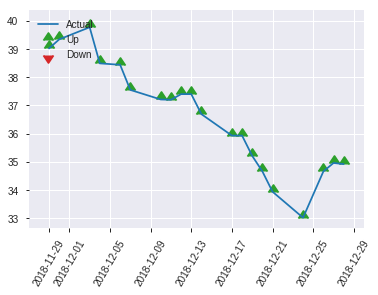


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2659323506233272
RMSE: 0.5156862909010935
LogLoss: 0.7291650697793686
Mean Per-Class Error: 0.4457692813033767
AUC: 0.5168177637629747
pr_auc: 0.5499803573231689
Gini: 0.03363552752594945
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18170076608657837: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.181701     0.68617   246
max f2                       0.181701     0.845347  246
max f0point5                 0.181701     0.57744   246
max accuracy                 0.454331     0.550607  103
max precision                0.607127     1         0
max recall                   0.181701     1         246
max specificity              0.607127     1         0
max absolute_mcc             0.254698     0.129283  232
max min_per_class_accuracy   0.439075     0.51938   119
max mean_per_class_accuracy  0.454331     0.554231  103

Gains/Lift Table: Avg response rate: 52.23 %, avg score: 42.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.585108           1.91473   1.91473            1                0.600401  1                           0.600401            0.0232558       0.0232558                  91.4729    91.4729
    2        0.0202429                   0.580622           0.957364  1.53178            0.5              0.582312  0.8                         0.593165            0.00775194      0.0310078                  -4.26357   53.1783
    3        0.0323887                   0.576544           0         0.957364           0                0.578166  0.5                         0.58754             0               0.0310078                  -100       -4.26357
    4        0.0404858                   0.560396           0         0.765891           0                0.575285  0.4                         0.585089            0               0.0310078                  -100       -23.4109
    5        0.0526316                   0.555874           1.27649   0.883721           0.666667         0.557227  0.461538                    0.57866             0.0155039       0.0465116                  27.6486    -11.6279
    6        0.101215                    0.529928           1.59561   1.22543            0.833333         0.539915  0.64                        0.560062            0.0775194       0.124031                   59.5607    22.5426
    7        0.149798                    0.510775           0.797804  1.08674            0.416667         0.516928  0.567568                    0.546073            0.0387597       0.162791                   -20.2196   8.67379
    8        0.202429                    0.501514           1.17829   1.11054            0.615385         0.506611  0.58                        0.535812            0.0620155       0.224806                   17.8295    11.0543
    9        0.299595                    0.475845           1.11693   1.11261            0.583333         0.488793  0.581081                    0.520563            0.108527        0.333333                   11.6925    11.2613
    10       0.40081                     0.45764            1.07225   1.10242            0.56             0.4669    0.575758                    0.507012            0.108527        0.44186                    7.22481    10.242
    11       0.502024                    0.434548           0.765891  1.03457            0.4              0.447096  0.540323                    0.494932            0.0775194       0.51938                    -23.4109   3.45711
    12       0.59919                     0.420697           0.718023  0.983239           0.375            0.427434  0.513514                    0.483986            0.0697674       0.589147                   -28.1977   -1.67609
    13       0.700405                    0.404073           1.14884   1.00717            0.6              0.4142    0.526012                    0.473902            0.116279        0.705426                   14.8837    0.716942
    14       0.797571                    0.356228           0.797804  0.981663           0.416667         0.383459  0.51269                     0.462883            0.0775194       0.782946                   -20.2196   -1.83371
    15       0.898785                    0.287621           0.995659  0.983239           0.52             0.326071  0.513514                    0.447476            0.100775        0.883721                   -0.434109  -1.67609
    16       1                           0.181701           1.14884   1                  0.6              0.25303   0.522267              

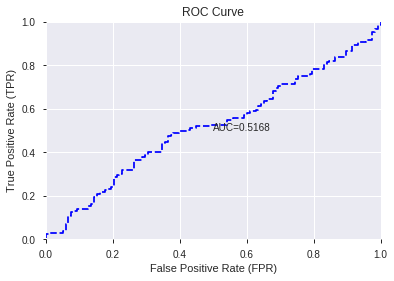

This function is available for GLM models only


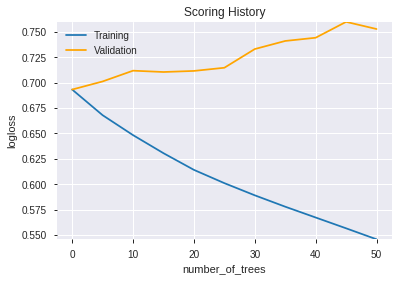

--2019-08-24 20:42:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.196
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.196|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(Share

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_204136_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_204136_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_8405',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['HT_PHASOR_quadrature',
 'MOM_30',
 'MOM_8',
 'STDDEV_8',
 'MOM_14',
 'day',
 'DX_8',
 'ADXR_12',
 'STOCH_slowd',
 'ROC_8',
 'weekday_name',
 'STOCHRSI_fastd',
 'SIN',
 'ADX_24',
 'MACDEXT_hist',
 'TAN',
 'HT_DCPERIOD',
 'NATR_14',
 'MACDFIX_signal_24',
 'LINEARREG_ANGLE_8',
 'PLUS_DM_30',
 'MINUS_DM_30',
 'SAREXT',
 'HT_PHASOR_inphase',
 'MACDEXT_signal',
 'ADX_12',
 'COS',
 'LINEARREG_ANGLE_14',
 'STDDEV_14',
 'NATR_8',
 'AROONOSC_12',
 'CMO_8',
 'ROC_14',
 'STDDEV_20',
 'MINUS_DM_24',
 'dayofyear',
 'LINEARREG_20',
 'dayofweek',
 'MACDFIX_8',
 'STOCHRSI_fastk',
 'ROC_12',
 'ADX_20',
 'TRANGE',
 'DX_30',
 'PLUS_DM_8',
 'CCI_8',
 'PPO',
 'MACDFIX_hist_24',
 'ROC_20',
 'MOM_12',
 'LINEARREG_ANGLE_30',
 'MOM_24',
 'DX_12',
 'MACDFIX_hist_20',
 'CCI_12',
 'CCI_14',
 'PLUS_DM_12',
 'AROONOSC_24',
 'ULTOSC',
 'MACDFIX_hist_8',
 'ADXR_14',
 'AdjClose',
 'ADX_14',
 'aroondown_24',
 'CCI_30',
 'PLUS_DM_24',
 'DX_14',
 'NATR_30',
 'WILLR_30',
 'MACDFIX_hist_14',
 'TRIX_12',
 'ROC_24',
 'AROON

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

320

['BBANDS_lowerband_12_2_3',
 'BBANDS_upperband_12_2_4',
 'BBANDS_middleband_12_2_4',
 'BBANDS_lowerband_12_2_4',
 'BBANDS_upperband_12_2_5',
 'BBANDS_middleband_12_2_5',
 'BBANDS_lowerband_12_2_5',
 'MA_12_3',
 'MAVP_12_3',
 'BBANDS_upperband_12_3_2',
 'BBANDS_middleband_12_3_2',
 'BBANDS_lowerband_12_3_2',
 'BBANDS_upperband_12_3_3',
 'BBANDS_middleband_12_3_3',
 'BBANDS_lowerband_12_3_3',
 'BBANDS_upperband_12_3_4',
 'BBANDS_middleband_12_3_4',
 'BBANDS_lowerband_12_3_4',
 'BBANDS_upperband_12_3_5',
 'BBANDS_middleband_12_3_5',
 'BBANDS_lowerband_12_3_5',
 'MA_12_4',
 'MAVP_12_4',
 'BBANDS_upperband_12_4_2',
 'BBANDS_middleband_12_4_2',
 'BBANDS_lowerband_12_4_2',
 'BBANDS_upperband_12_4_3',
 'BBANDS_middleband_12_4_3',
 'BBANDS_lowerband_12_4_3',
 'BBANDS_upperband_12_4_4',
 'BBANDS_middleband_12_4_4',
 'BBANDS_lowerband_12_4_4',
 'BBANDS_upperband_12_4_5',
 'BBANDS_lowerband_12_4_5',
 'MA_12_5',
 'MAVP_12_5',
 'BBANDS_middleband_12_5_2',
 'BBANDS_lowerband_12_5_3',
 'BBANDS_upperba

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_204327_model_1  0.508803  5.721283              0.500000  0.686966  0.471922
1  DeepLearning_grid_1_AutoML_20190824_204327_model_2  0.502168  0.936651              0.491525  0.574901  0.330511
2  DeepLearning_grid_1_AutoML_20190824_204327_model_3  0.500854  1.415151              0.491164  0.629176  0.395863
3  DeepLearning_grid_1_AutoML_20190824_204327_model_8  0.500000  0.697649              0.500000  0.502209  0.252214
4  DeepLearning_grid_1_AutoML_20190824_204327_model_4  0.498883  2.063835              0.487288  0.661963  0.438195
5  DeepLearning_grid_1_AutoML_20190824_204327_model_6  0.490671  0.712887              0.486565  0.509392  0.259480
6  DeepLearning_grid_1_AutoML_20190824_204327_model_5  0.486795  0.708299              0.495763  0.507255  0.257308
7               DeepLearning_1_AutoML_20190824_204327  0.481408  0.991972              0.491525  0.564015  0.318112
8  DeepLearning_grid_1_AutoML_20190824_204327_model_7  0.473722  1.066400              0.495763  0.602889  0.363476
9  DeepLearning_grid_1_AutoML_20190824_204327_model_9  0.471883  0.705495              0.500000  0.505973  0.256009

variable  relative_importance  scaled_importance  percentage
0    BBANDS_upperband_30_1_2             1.000000           1.000000    0.003394
1    BBANDS_lowerband_14_2_2             0.988897           0.988897    0.003356
2                 aroonup_20             0.988567           0.988567    0.003355
3                 MACDFIX_20             0.985499           0.985499    0.003345
4                  MAVP_12_6             0.981372           0.981372    0.003331
..                       ...                  ...                ...         ...
315                 MEDPRICE             0.857463           0.857463    0.002910
316  BBANDS_lowerband_14_4_5             0.850063           0.850063    0.002885
317              AROONOSC_20             0.840246           0.840246    0.002852
318                     DX_8             0.835532           0.835532    0.002836
319                MAVP_14_5             0.833633           0.833633    0.002829

[320 rows x 4 columns]

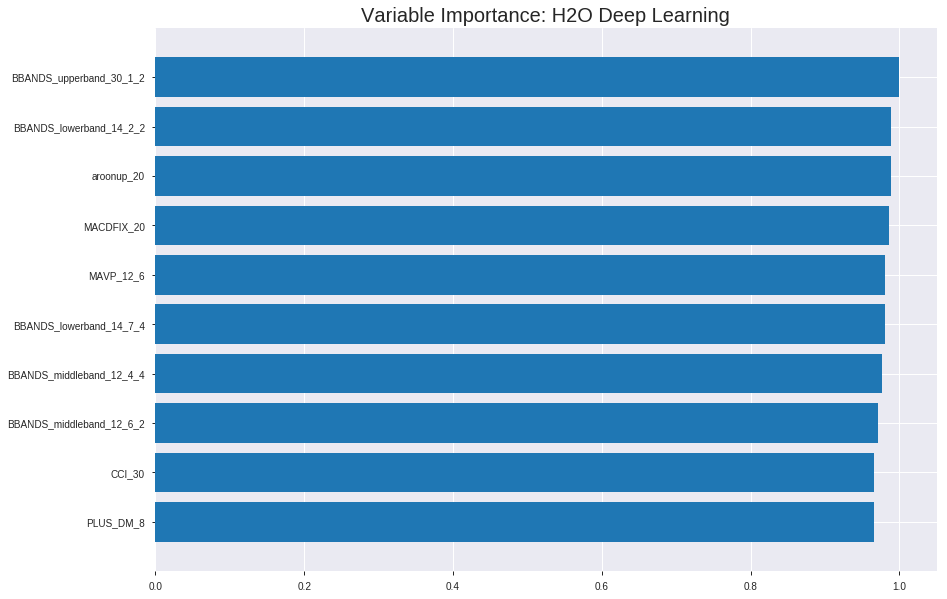

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_204327_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.3815448499318228
RMSE: 0.6176931681116627
LogLoss: 2.091944705376563
Mean Per-Class Error: 0.46989891296821984
AUC: 0.5399037596067299
pr_auc: 0.5381295935381695
Gini: 0.07980751921345974
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00016884820749411833: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    715   1        (715.0/715.0)
1      0    1010  0        (0.0/1010.0)
Total  0    1725  0.4145   (715.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.000168848  0.738574   399
max f2                       0.000168848  0.875976   399
max f0point5                 0.00876097   0.644924   390
max accuracy                 0.00876097   0.595362   390
max precision                0.999975     0.67027    0
max recall                   0.000168848  1          399
max specificity              0.999975     0.914685   0
max absolute_mcc             0.00876097   0.0862829  390
max min_per_class_accuracy   0.975068     0.516832   38
max mean_per_class_accuracy  0.36592      0.530101   252

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 72.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   1                  1.2335    1.2335             0.722222         1           0.722222                    1                   0.0128713       0.0128713                  23.3498   23.3498
    2        0.0202899                   0.999999           1.00466   1.12235            0.588235         0.999999    0.657143                    1                   0.00990099      0.0227723                  0.465929  12.2348
    3        0.0301449                   0.999998           1.30606   1.18241            0.764706         0.999999    0.692308                    0.999999            0.0128713       0.0356436                  30.6057   18.2407
    4        0.04                        0.999996           1.40652   1.23762            0.823529         0.999997    0.724638                    0.999999            0.0138614       0.049505                   40.6523   23.7624
    5        0.0504348                   0.999994           1.2335    1.23677            0.722222         0.999995    0.724138                    0.999998            0.0128713       0.0623762                  23.3498   23.677
    6        0.10029                     0.999908           1.09227   1.16494            0.639535         0.999962    0.682081                    0.99998             0.0544554       0.116832                   9.22749   16.494
    7        0.150145                    0.999739           1.09227   1.14081            0.639535         0.999823    0.667954                    0.999928            0.0544554       0.171287                   9.22749   14.0812
    8        0.2                         0.999403           0.953258  1.09406            0.55814          0.999598    0.64058                     0.999846            0.0475248       0.218812                   -4.67419  9.40594
    9        0.30029                     0.997757           1.01685   1.06827            0.595376         0.998702    0.625483                    0.999464            0.10198         0.320792                   1.68546   6.82748
    10       0.4                         0.993394           1.01284   1.05446            0.593023         0.996104    0.617391                    0.998626            0.10099         0.421782                   1.28367   5.44554
    11       0.50029                     0.974969           0.928003  1.02911            0.543353         0.986129    0.602549                    0.996121            0.0930693       0.514851                   -7.19968  2.91064
    12       0.6                         0.885034           1.00291   1.02475            0.587209         0.942024    0.6                         0.987131            0.1             0.614851                   0.290698  2.47525
    13       0.69971                     0.629987           1.00291   1.02164            0.587209         0.776771    0.598177                    0.957154            0.1             0.714851                   0.290698  2.16394
    14       0.8                         0.246439           1.06622   1.02723            0.624277         0.431103    0.601449                    0.891207            0.106931        0.821782                   6.62164   2.72277
    15       0.89971                     0.0338769          0.963188  1.02013            0.563953         0.123415    0.597294                    0.806117            0.0960396       0.917822                   -3.68121  2.01305
    16       1                           1.03902e-05        0.819407  1                  0.479769         0.00864045  0.585507   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3439049209097142
RMSE: 0.586434072091411
LogLoss: 1.4932963019400904
Mean Per-Class Error: 0.45040369088811993
AUC: 0.5527512042879436
pr_auc: 0.6238679092128607
Gini: 0.10550240857588711
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.044839907062729736: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    200  0.9804   (200.0/204.0)
1      0    289  0        (0.0/289.0)
Total  4    489  0.4057   (200.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0448399    0.742931  395
max f2                       0.0448399    0.878419  395
max f0point5                 0.623279     0.656109  331
max accuracy                 0.623279     0.610548  331
max precision                0.999688     0.846154  4
max recall                   0.0448399    1         395
max specificity              0.99997      0.990196  0
max absolute_mcc             0.623279     0.141675  331
max min_per_class_accuracy   0.963456     0.539216  160
max mean_per_class_accuracy  0.623279     0.549596  331

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 86.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010142                    0.999936           1.02353   1.02353            0.6              0.99997   0.6                         0.99997             0.0103806       0.0103806                  2.35294    2.35294
    2        0.020284                    0.999787           1.70588   1.36471            1                0.999889  0.8                         0.99993             0.017301        0.0276817                  70.5882    36.4706
    3        0.030426                    0.999585           1.36471   1.36471            0.8              0.999671  0.8                         0.999843            0.0138408       0.0415225                  36.4706    36.4706
    4        0.040568                    0.999428           1.02353   1.27941            0.6              0.999524  0.75                        0.999763            0.0103806       0.0519031                  2.35294    27.9412
    5        0.0507099                   0.99933            1.36471   1.29647            0.8              0.999368  0.76                        0.999684            0.0138408       0.0657439                  36.4706    29.6471
    6        0.10142                     0.998219           0.955294  1.12588            0.56             0.998772  0.66                        0.999228            0.0484429       0.114187                   -4.47059   12.5882
    7        0.150101                    0.997133           0.995098  1.08347            0.583333         0.997738  0.635135                    0.998745            0.0484429       0.16263                    -0.490196  8.34658
    8        0.200811                    0.996082           1.09176   1.08556            0.64             0.996631  0.636364                    0.998211            0.0553633       0.217993                   9.17647    8.55615
    9        0.300203                    0.992864           0.97479   1.04889            0.571429         0.994649  0.614865                    0.997032            0.0968858       0.314879                   -2.52101   4.88871
    10       0.399594                    0.983289           1.11405   1.06509            0.653061         0.989506  0.624365                    0.99516             0.110727        0.425606                   11.4046    6.50941
    11       0.501014                    0.964741           1.05765   1.06359            0.62             0.975842  0.623482                    0.99125             0.107266        0.532872                   5.76471    6.35866
    12       0.600406                    0.935833           0.905162  1.03736            0.530612         0.951773  0.608108                    0.984715            0.0899654       0.622837                   -9.48379   3.73609
    13       0.699797                    0.892048           0.97479   1.02847            0.571429         0.91497   0.602899                    0.974809            0.0968858       0.719723                   -2.52101   2.8474
    14       0.799189                    0.758589           1.11405   1.03912            0.653061         0.841665  0.609137                    0.95825             0.110727        0.83045                    11.4046    3.91162
    15       0.89858                     0.521761           1.0096    1.03585            0.591837         0.649918  0.607223                    0.924146            0.100346        0.930796                   0.960384   3.58518
    16       1                           0.0166356          0.682353  1                  0.4              0.295613  0.586207                    0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 20:43:28  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 20:43:32  4.231 sec   626 obs/sec       1.35884   1             2344       0.628627         2.72443             -0.628308      0.518812        0.439782           1.32838          0.414493                         0.619185           2.12108               -0.580547        0.515622          0.6023               1.02353            0.413793
    2019-08-24 20:43:39  11.568 sec  657 obs/sec       4.04174   3             6972       0.617693         2.09194             -0.572159      0.539904        0.53813            1.2335           0.414493                         0.586434           1.4933                -0.417765        0.552751          0.623868             1.02353            0.40568
    2019-08-24 20:43:46  18.644 sec  672 obs/sec       6.70377   5             11564      0.582491         2.23861             -0.398071      0.552753        0.465224           1.2335           0.406957                         0.643266           7.09218               -0.705875        0.521525          0.278453             1.02353            0.413793
    2019-08-24 20:43:53  25.659 sec  681 obs/sec       9.38551   7             16190      0.604134         1.99505             -0.503896      0.558859        0.498538           1.42327          0.411014                         0.643194           5.15487               -0.705492        0.526121          0.55401              1.36471            0.413793
    2019-08-24 20:44:00  32.456 sec  689 obs/sec       12.0412   9             20771      0.578753         1.5622              -0.380187      0.592873        0.569951           1.61304          0.408696                         0.62869            2.2757                -0.629444        0.518166          0.588355             1.02353            0.413793
    2019-08-24 20:44:07  39.307 sec  694 obs/sec       14.702    11            25361      0.584725         2.24533             -0.408817      0.565948        0.475616           1.04373          0.391304                         0.643258           6.4569                -0.705829        0.511093          0.371232             0.682353           0.411765
    2019-08-24 20:44:07  39.775 sec  694 obs/sec       14.702    11            25361      0.617693         2.09194             -0.572159      0.539904        0.53813            1.2335           0.414493                         0.586434           1.4933                -0.417765        0.552751          0.623868             1.02353            0.40568

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
BBANDS_upperband_30_1_2  1.0                    1.0                  0.0033937700030450364
BBANDS_lowerband_14_2_2  0.988897442817688      0.988897442817688    0.003356090477522614
aroonup_20               0.9885666370391846     0.9885666370391846   0.003354967798794695
MACDFIX_20               0.9854991436004639     0.9854991436004639   0.003344557431577827
MAVP_12_6                0.9813715815544128     0.9813715815544128   0.003330549435320232
---                      ---                    ---                  ---
MEDPRICE                 0.8574628233909607     0.8574628233909607   0.002910031608750546
BBANDS_lowerband_14_4_5  0.8500627875328064     0.8500627875328064   0.0028849175890336845
AROONOSC_20              0.8402459025382996     0.8402459025382996   0.0028516013392159843
DX_8                     0.8355318903923035     0.8355318903923035   0.0028356030662009127
MAVP_14_5                0.8336334228515625     0.8336334228515625   0.0028291601040093916


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5587044534412956)

('F1', 0.6861702127659575)

('auc', 0.508803048219682)

('logloss', 5.721282882942793)

('mean_per_class_error', 0.4452437261857838)

('rmse', 0.6869661403854499)

('mse', 0.47192247803608167)

deeplearning prediction progress: |███████████████████████████████████████| 100%


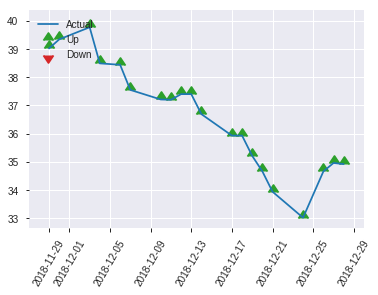


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.47192247803608167
RMSE: 0.6869661403854499
LogLoss: 5.721282882942793
Mean Per-Class Error: 0.4452437261857838
AUC: 0.508803048219682
pr_auc: 0.484979918823556
Gini: 0.01760609643936406
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07960486894736346: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0796049    0.68617   177
max f2                       0.0796049    0.845347  177
max f0point5                 0.999968     0.584256  101
max accuracy                 0.999987     0.558704  77
max precision                0.999987     0.568493  77
max recall                   0.0796049    1         177
max specificity              1            0.90678   0
max absolute_mcc             0.999987     0.111266  77
max min_per_class_accuracy   0.999992     0.525424  58
max mean_per_class_accuracy  0.999987     0.554756  77

Gains/Lift Table: Avg response rate: 52.23 %, avg score: 96.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   1                  0         0                  0                1         0                           1                   0               0                          -100       -100
    2        0.0202429                   1                  0.957364  0.382946           0.5              1         0.2                         1                   0.00775194      0.00775194                 -4.26357   -61.7054
    3        0.0323887                   1                  1.27649   0.718023           0.666667         1         0.375                       1                   0.0155039       0.0232558                  27.6486    -28.1977
    4        0.0404858                   1                  0.957364  0.765891           0.5              1         0.4                         1                   0.00775194      0.0310078                  -4.26357   -23.4109
    5        0.0526316                   1                  1.27649   0.883721           0.666667         1         0.461538                    1                   0.0155039       0.0465116                  27.6486    -11.6279
    6        0.101215                    1                  0.638243  0.765891           0.333333         1         0.4                         1                   0.0310078       0.0775194                  -36.1757   -23.4109
    7        0.149798                    1                  0.797804  0.776241           0.416667         1         0.405405                    1                   0.0387597       0.116279                   -20.2196   -22.3759
    8        0.202429                    1                  1.32558   0.91907            0.692308         1         0.48                        1                   0.0697674       0.186047                   32.5581    -8.09302
    9        0.299595                    0.999999           1.19671   1.00911            0.625            0.999999  0.527027                    1                   0.116279        0.302326                   19.6705    0.911376
    10       0.40081                     0.999997           0.995659  1.00572            0.52             0.999998  0.525253                    0.999999            0.100775        0.403101                   -0.434109  0.571608
    11       0.502024                    0.999992           1.22543   1.05001            0.64             0.999995  0.548387                    0.999998            0.124031        0.527132                   22.5426    5.00125
    12       0.59919                     0.999986           1.19671   1.0738             0.625            0.99999   0.560811                    0.999997            0.116279        0.643411                   19.6705    7.38005
    13       0.700405                    0.999966           0.91907   1.05144            0.48             0.999978  0.549133                    0.999994            0.0930233       0.736434                   -8.09302   5.14406
    14       0.797571                    0.99994            0.638243  1.0011             0.333333         0.999956  0.522843                    0.99999             0.0620155       0.79845                    -36.1757   0.11018
    15       0.898785                    0.999145           0.91907   0.991864           0.48             0.99979   0.518018                    0.999967            0.0930233       0.891473                   -8.09302   -0.813604
    16       1                           0.0796049          1.07225   1                  0.56             0.69768   0.522267            

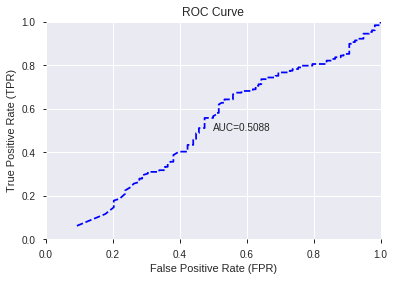

This function is available for GLM models only


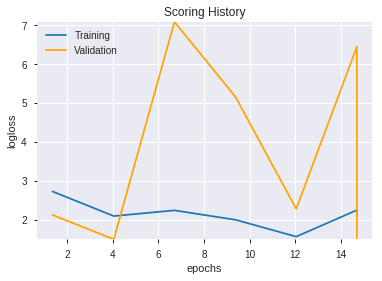

--2019-08-24 20:57:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.116
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.116|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_204327_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_204327_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_8405',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BBANDS_upperband_30_1_2',
 'BBANDS_lowerband_14_2_2',
 'aroonup_20',
 'MACDFIX_20',
 'MAVP_12_6',
 'BBANDS_lowerband_14_7_4',
 'BBANDS_middleband_12_4_4',
 'BBANDS_middleband_12_6_2',
 'CCI_30',
 'PLUS_DM_8',
 'KAMA_20',
 'MACD_hist',
 'MACDFIX_signal_8',
 'EMA_20',
 'AROONOSC_30',
 'ADX_8',
 'WILLR_12',
 'BBANDS_upperband_24_6_3',
 'AROONOSC_8',
 'MA_30_5',
 'BBANDS_middleband_12_3_5',
 'MAVP_12_7',
 'TYPPRICE',
 'STOCHF_fastd',
 'MAVP_20_2',
 'BBANDS_upperband_14_5_5',
 'ROCR100_20',
 'BBANDS_upperband_12_6_5',
 'STOCHF_fastk',
 'MAVP_12_3',
 'BBANDS_middleband_14_2_3',
 'BBANDS_lowerband_12_4_3',
 'WILLR_14',
 'BBANDS_upperband_20_7_4',
 'BBANDS_middleband_30_5_5',
 'BBANDS_lowerband_20_2_3',
 'TRIMA_20',
 'BBANDS_upperband_14_1_4',
 'BBANDS_lowerband_30_1_5',
 'MACDFIX_hist_8',
 'MINUS_DM_8',
 'BBANDS_middleband_14_1_3',
 'BBANDS_lowerband_12_3_4',
 'BBANDS_middleband_12_4_3',
 'MAVP_14_2',
 'BBANDS_middleband_30_5_4',
 'BBANDS_middleband_14_2_4',
 'MACDFIX_hist_14',
 'WCLPRICE',

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_205800_model_1  0.52976  0.692659              0.486565  0.499741  0.249741

variable  relative_importance  scaled_importance  percentage
0             STOCHRSI_fastk             0.004365           1.000000    0.017766
1                     MOM_30             0.004350           0.996540    0.017705
2                 aroonup_24             0.004337           0.993557    0.017652
3                    ROCP_14             0.004123           0.944569    0.016782
4                 ROCR100_14             0.004116           0.943028    0.016754
..                       ...                  ...                ...         ...
315                   ADX_12             0.000010           0.002288    0.000041
316  BBANDS_upperband_24_3_5             0.000010           0.002234    0.000040
317                MAVP_30_6             0.000009           0.001988    0.000035
318  BBANDS_upperband_12_2_4             0.000008           0.001905    0.000034
319  BBANDS_upperband_24_6_3             0.000001           0.000323    0.000006

[320 rows x 4 columns]

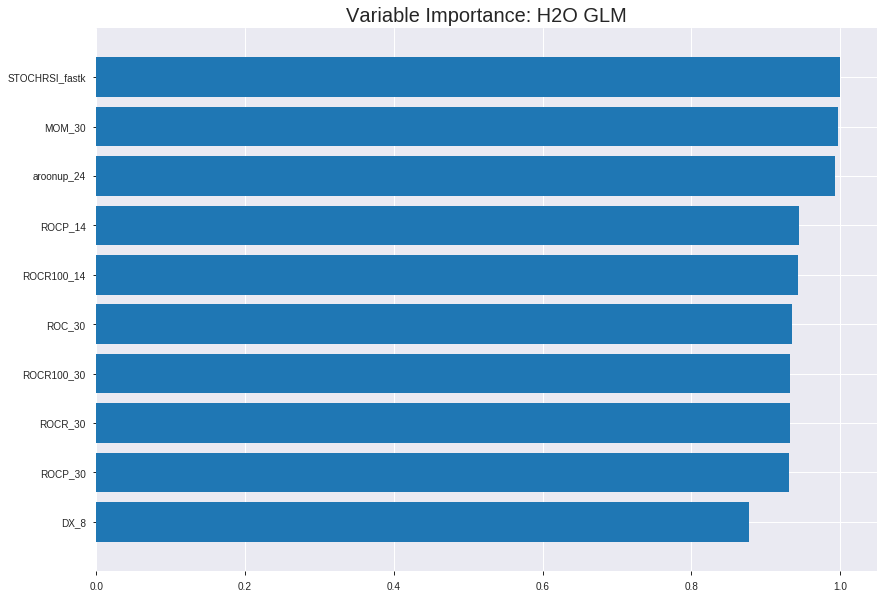

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_205800_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24182837757973097
RMSE: 0.491760488022097
LogLoss: 0.67668156712225
Null degrees of freedom: 1724
Residual degrees of freedom: 1404
Null deviance: 2340.659668736101
Residual deviance: 2334.5514065717625
AIC: 2976.5514065717625
AUC: 0.5443744374437444
pr_auc: 0.614996433970892
Gini: 0.08874887488748873
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5344584921473795: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    712   0.9958   (712.0/715.0)
1      0    1010  0        (0.0/1010.0)
Total  3    1722  0.4128   (712.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.534458     0.739385  397
max f2                       0.534458     0.876432  397
max f0point5                 0.548028     0.640127  386
max accuracy                 0.548028     0.588406  386
max precision                0.653348     1         0
max recall                   0.534458     1         397
max specificity              0.653348     1         0
max absolute_mcc             0.577338     0.101457  259
max min_per_class_accuracy   0.583503     0.534653  216
max mean_per_class_accuracy  0.577338     0.548688  259

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 58.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.632934           1.13861   1.13861            0.666667         0.641326  0.666667                    0.641326            0.0118812       0.0118812                  13.8614   13.8614
    2        0.0202899                   0.628183           1.10513   1.12235            0.647059         0.629463  0.657143                    0.635564            0.0108911       0.0227723                  10.5125   12.2348
    3        0.0301449                   0.62391            1.10513   1.11672            0.647059         0.625782  0.653846                    0.632366            0.0108911       0.0336634                  10.5125   11.6717
    4        0.04                        0.622115           1.10513   1.11386            0.647059         0.622923  0.652174                    0.630039            0.0108911       0.0445545                  10.5125   11.3861
    5        0.0504348                   0.619119           1.2335    1.13861            0.722222         0.620673  0.666667                    0.628102            0.0128713       0.0574257                  23.3498   13.8614
    6        0.10029                     0.609774           0.85396   0.99711            0.5              0.614043  0.583815                    0.621113            0.0425743       0.1                        -14.604   -0.289017
    7        0.150145                    0.604162           1.15185   1.04849            0.674419         0.606686  0.6139                      0.616322            0.0574257       0.157426                   15.1854   4.84919
    8        0.2                         0.598719           1.09227   1.05941            0.639535         0.601472  0.62029                     0.612621            0.0544554       0.211881                   9.22749   5.94059
    9        0.30029                     0.591951           1.08596   1.06827            0.635838         0.595173  0.625483                    0.606793            0.108911        0.320792                   8.59612   6.82748
    10       0.4                         0.587311           1.01284   1.05446            0.593023         0.589568  0.617391                    0.6025              0.10099         0.421782                   1.28367   5.44554
    11       0.50029                     0.583643           1.08596   1.06077            0.635838         0.585472  0.621089                    0.599086            0.108911        0.530693                   8.59612   6.07712
    12       0.6                         0.579524           1.02277   1.05446            0.598837         0.581448  0.617391                    0.596155            0.10198         0.632673                   2.27665   5.44554
    13       0.69971                     0.575756           0.973118  1.04286            0.569767         0.577692  0.610605                    0.593524            0.0970297       0.729703                   -2.68823  4.28646
    14       0.8                         0.571737           0.888514  1.02351            0.520231         0.573775  0.599275                    0.591048            0.0891089       0.818812                   -11.1486  2.35149
    15       0.89971                     0.565783           0.88375   1.00803            0.517442         0.569199  0.590206                    0.588627            0.0881188       0.906931                   -11.625   0.802542
    16       1                           0.530777           0.928003  1                  0.543353         0.557523  0.585507                    0.585507      



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24341926112913576
RMSE: 0.49337537547909277
LogLoss: 0.6799404671265836
Null degrees of freedom: 492
Residual degrees of freedom: 172
Null deviance: 668.7154569489843
Residual deviance: 670.4213005868114
AIC: 1312.4213005868114
AUC: 0.4978712938462582
pr_auc: 0.5802760958323696
Gini: -0.004257412307483555
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5299160894116585: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.529916     0.73913    399
max f2                       0.529916     0.876289   399
max f0point5                 0.532612     0.639198   395
max accuracy                 0.532612     0.586207   395
max precision                0.624077     1          0
max recall                   0.529916     1          399
max specificity              0.624077     1          0
max absolute_mcc             0.534075     0.0624602  390
max min_per_class_accuracy   0.561619     0.495098   198
max mean_per_class_accuracy  0.56883      0.515138   135

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 56.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010142                    0.607632           1.02353   1.02353            0.6              0.618974  0.6                         0.618974            0.0103806       0.0103806                  2.35294    2.35294
    2        0.020284                    0.599462           0.682353  0.852941           0.4              0.602067  0.5                         0.610521            0.00692042      0.017301                   -31.7647   -14.7059
    3        0.030426                    0.592524           1.36471   1.02353            0.8              0.5962    0.6                         0.605747            0.0138408       0.0311419                  36.4706    2.35294
    4        0.040568                    0.590058           1.02353   1.02353            0.6              0.591406  0.6                         0.602162            0.0103806       0.0415225                  2.35294    2.35294
    5        0.0507099                   0.588289           0.682353  0.955294           0.4              0.589229  0.56                        0.599575            0.00692042      0.0484429                  -31.7647   -4.47059
    6        0.10142                     0.580642           0.955294  0.955294           0.56             0.584414  0.56                        0.591995            0.0484429       0.0968858                  -4.47059   -4.47059
    7        0.150101                    0.577232           0.995098  0.968203           0.583333         0.578677  0.567568                    0.587676            0.0484429       0.145329                   -0.490196  -3.17965
    8        0.200811                    0.575281           1.02353   0.982175           0.6              0.576087  0.575758                    0.584749            0.0519031       0.197232                   2.35294    -1.78253
    9        0.300203                    0.570081           1.11405   1.02583            0.653061         0.572618  0.601351                    0.580733            0.110727        0.307958                   11.4046    2.58347
    10       0.399594                    0.56546            0.870348  0.98716            0.510204         0.567759  0.57868                     0.577506            0.0865052       0.394464                   -12.9652   -1.28397
    11       0.501014                    0.561619           1.02353   0.994523           0.6              0.563617  0.582996                    0.574694            0.103806        0.49827                    2.35294    -0.547749
    12       0.600406                    0.557887           1.0096    0.997019           0.591837         0.55983   0.584459                    0.572234            0.100346        0.598616                   0.960384   -0.298092
    13       0.699797                    0.553285           1.0096    0.998806           0.591837         0.555616  0.585507                    0.569873            0.100346        0.698962                   0.960384   -0.119352
    14       0.799189                    0.549762           1.04442   1.00448            0.612245         0.551727  0.588832                    0.567617            0.103806        0.802768                   4.44178    0.447895
    15       0.89858                     0.543207           1.04442   1.0089             0.612245         0.546714  0.591422                    0.565305            0.103806        0.906574                   4.44178    0.889656
    16       1                           0.529916           0.921176  1                  0.54             0.537056  0.586207      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 20:58:00  0.000 sec   2            2.3       321           1.35336           1.35988
    2019-08-24 20:58:00  0.106 sec   3            1.7       321           1.35283           1.3602
    2019-08-24 20:58:00  0.235 sec   4            1.2       321           1.35222           1.36046
    2019-08-24 20:58:01  0.343 sec   5            0.89      321           1.35152           1.36071
    2019-08-24 20:58:01  0.450 sec   6            0.65      321           1.35072           1.36094

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5465587044534413)

('F1', 0.6883468834688345)

('auc', 0.5297595585337012)

('logloss', 0.6926586677151881)

('mean_per_class_error', 0.4534226777033241)

('rmse', 0.4997413005331787)

('mse', 0.24974136745859285)

glm prediction progress: |████████████████████████████████████████████████| 100%


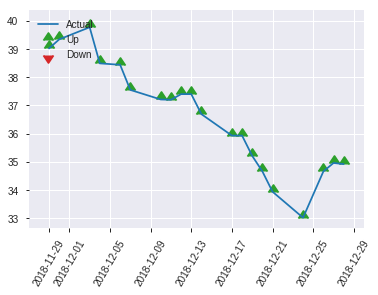


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24974136745859285
RMSE: 0.4997413005331787
LogLoss: 0.6926586677151881
Null degrees of freedom: 246
Residual degrees of freedom: -74
Null deviance: 345.9465433426434
Residual deviance: 342.17338185130296
AIC: 984.173381851303
AUC: 0.5297595585337012
pr_auc: 0.5368714381000688
Gini: 0.059519117067402316
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5023399578958874: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    113  0.9576   (113.0/118.0)
1      2    127  0.0155   (2.0/129.0)
Total  7    240  0.4656   (115.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.50234      0.688347   239
max f2                       0.495367     0.846457   245
max f0point5                 0.525882     0.587949   224
max accuracy                 0.527608     0.546559   220
max precision                0.650684     1          0
max recall                   0.495367     1          245
max specificity              0.650684     1          0
max absolute_mcc             0.556432     0.0997636  78
max min_per_class_accuracy   0.543047     0.533898   123
max mean_per_class_accuracy  0.556432     0.546577   78

Gains/Lift Table: Avg response rate: 52.23 %, avg score: 54.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.626576           1.27649   1.27649            0.666667         0.637679  0.666667                    0.637679            0.0155039       0.0155039                  27.6486    27.6486
    2        0.0202429                   0.621399           0.957364  1.14884            0.5              0.625023  0.6                         0.632616            0.00775194      0.0232558                  -4.26357   14.8837
    3        0.0323887                   0.604345           0.638243  0.957364           0.333333         0.612269  0.5                         0.624986            0.00775194      0.0310078                  -36.1757   -4.26357
    4        0.0404858                   0.59823            0         0.765891           0                0.599615  0.4                         0.619912            0               0.0310078                  -100       -23.4109
    5        0.0526316                   0.593049           1.27649   0.883721           0.666667         0.596427  0.461538                    0.614492            0.0155039       0.0465116                  27.6486    -11.6279
    6        0.101215                    0.580743           1.11693   0.995659           0.583333         0.58871   0.52                        0.602117            0.0542636       0.100775                   11.6925    -0.434109
    7        0.149798                    0.572886           1.11693   1.03499            0.583333         0.576868  0.540541                    0.593928            0.0542636       0.155039                   11.6925    3.49885
    8        0.202429                    0.56789            1.17829   1.07225            0.615385         0.570059  0.56                        0.587722            0.0620155       0.217054                   17.8295    7.22481
    9        0.299595                    0.557804           1.19671   1.11261            0.625            0.562388  0.581081                    0.579506            0.116279        0.333333                   19.6705    11.2613
    10       0.40081                     0.549018           0.995659  1.08308            0.52             0.553862  0.565657                    0.57303             0.100775        0.434109                   -0.434109  8.30789
    11       0.502024                    0.543047           0.995659  1.06545            0.52             0.546395  0.556452                    0.56766             0.100775        0.534884                   -0.434109  6.54539
    12       0.59919                     0.539328           0.877584  1.03499            0.458333         0.54132   0.540541                    0.563389            0.0852713       0.620155                   -12.2416   3.49885
    13       0.700405                    0.536755           0.765891  0.996102           0.4              0.537891  0.520231                    0.559704            0.0775194       0.697674                   -23.4109   -0.389837
    14       0.797571                    0.533487           1.11693   1.01082            0.583333         0.535345  0.527919                    0.556737            0.108527        0.806202                   11.6925    1.08212
    15       0.898785                    0.52706            1.14884   1.02636            0.6              0.530599  0.536036                    0.553793            0.116279        0.922481                   14.8837    2.63636
    16       1                           0.493777           0.765891  1                  0.4              0.512277  0.522267             

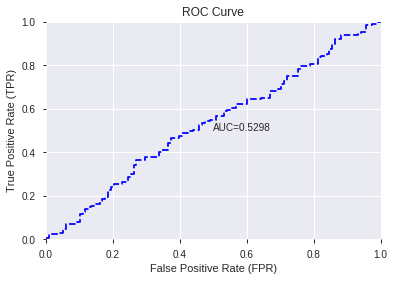

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


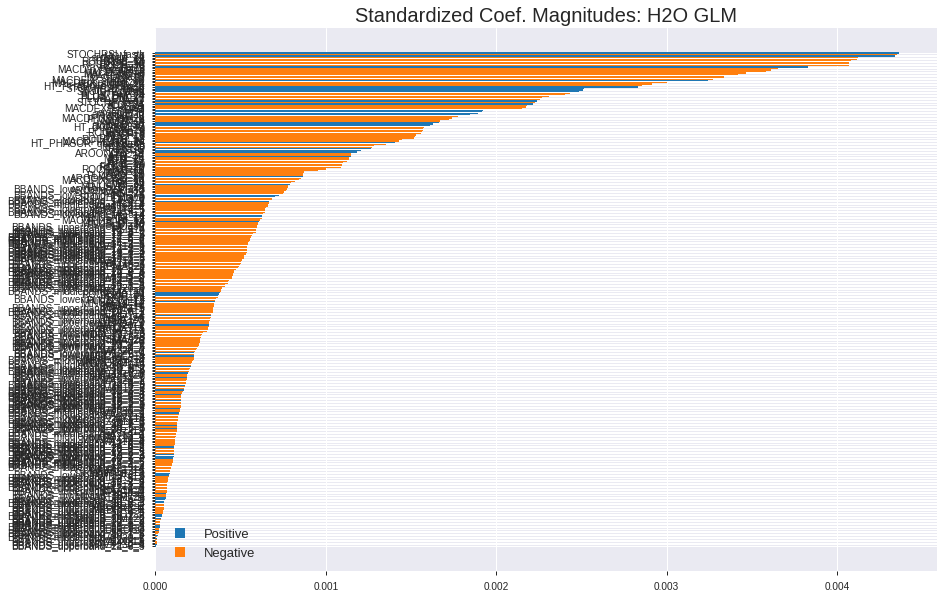

'log_likelihood'
--2019-08-24 20:58:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_205800_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_205800_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_8405',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['STOCHRSI_fastk',
 'MOM_30',
 'aroonup_24',
 'ROCP_14',
 'ROCR100_14',
 'ROC_30',
 'ROCR100_30',
 'ROCR_30',
 'ROCP_30',
 'DX_8',
 'MACDFIX_signal_8',
 'MOM_14',
 'MACD_signal',
 'MACDFIX_20',
 'MACDFIX_8',
 'MACD',
 'TRIX_12',
 'MACDFIX_signal_20',
 'aroondown_30',
 'MACDFIX_signal_24',
 'TRIX_8',
 'HT_PHASOR_inphase',
 'STOCHRSI_fastd',
 'STOCH_slowk',
 'STOCHF_fastd',
 'ADX_8',
 'PLUS_DM_14',
 'PLUS_DM_24',
 'PLUS_DM_12',
 'MACDEXT',
 'APO',
 'STOCHF_fastk',
 'ADX_24',
 'CCI_24',
 'ADX_20',
 'MACDEXT_signal',
 'PPO',
 'CCI_30',
 'aroonup_8',
 'aroonup_30',
 'ADXR_8',
 'MACDFIX_hist_24',
 'PLUS_DM_8',
 'NATR_14',
 'NATR_8',
 'WILLR_30',
 'aroonup_20',
 'HT_DCPERIOD',
 'DX_24',
 'NATR_20',
 'ROCR100_8',
 'ROCR_8',
 'ROCP_8',
 'ROC_12',
 'ROCR_12',
 'ROCR100_12',
 'MACDFIX_hist_20',
 'NATR_24',
 'HT_PHASOR_quadrature',
 'DX_20',
 'NATR_30',
 'TRANGE',
 'CCI_8',
 'CCI_14',
 'AROONOSC_8',
 'ATR_14',
 'ATR_30',
 'MOM_24',
 'ATR_20',
 'ATR_12',
 'ATR_24',
 'ROC_20',
 'ROCP_20',
 'ROCR_20'

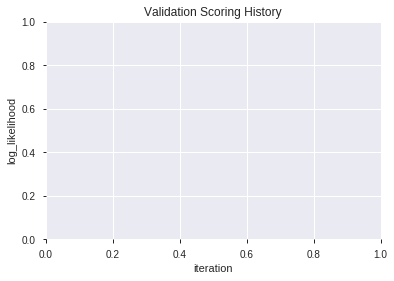

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_205813_model_1  0.505157  0.781569              0.495763  0.537271  0.288660
1               XGBoost_2_AutoML_20190824_205813  0.500460  0.721788              0.500000  0.513370  0.263549
2  XGBoost_grid_1_AutoML_20190824_205813_model_3  0.495139  0.792877              0.486927  0.543298  0.295173
3  XGBoost_grid_1_AutoML_20190824_205813_model_7  0.488109  0.749653              0.495401  0.525250  0.275887
4  XGBoost_grid_1_AutoML_20190824_205813_model_4  0.487025  0.707637              0.500000  0.506935  0.256983
5               XGBoost_1_AutoML_20190824_205813  0.485613  0.741882              0.495763  0.521745  0.272217
6  XGBoost_grid_1_AutoML_20190824_205813_model_5  0.472080  0.809070              0.500000  0.547371  0.299615
7               XGBoost_3_AutoML_20190824_205813  0.461733  0.748030              0.495401  0.525064  0.275693
8  XGBoost_grid_1_AutoML_20190824_205813_model_2  0.458218  0.713224              0.495763  0.509747  0.259842
9  XGBoost_grid_1_AutoML_20190824_205813_model_6  0.441138  0.785508              0.500000  0.540141  0.291752

variable  relative_importance  scaled_importance  percentage
0                HT_DCPERIOD           137.483490           1.000000    0.037146
1       HT_PHASOR_quadrature           123.668884           0.899518    0.033414
2          MACDFIX_signal_24           107.686409           0.783268    0.029096
3                     ADX_14            85.340240           0.620731    0.023058
4          HT_PHASOR_inphase            74.393692           0.541110    0.020100
..                       ...                  ...                ...         ...
152  BBANDS_upperband_20_1_2             3.713862           0.027013    0.001003
153               MACDFIX_20             3.434964           0.024985    0.000928
154  BBANDS_lowerband_14_3_2             2.909340           0.021161    0.000786
155  BBANDS_upperband_24_3_5             2.523403           0.018354    0.000682
156                   TRANGE             1.426546           0.010376    0.000385

[157 rows x 4 columns]

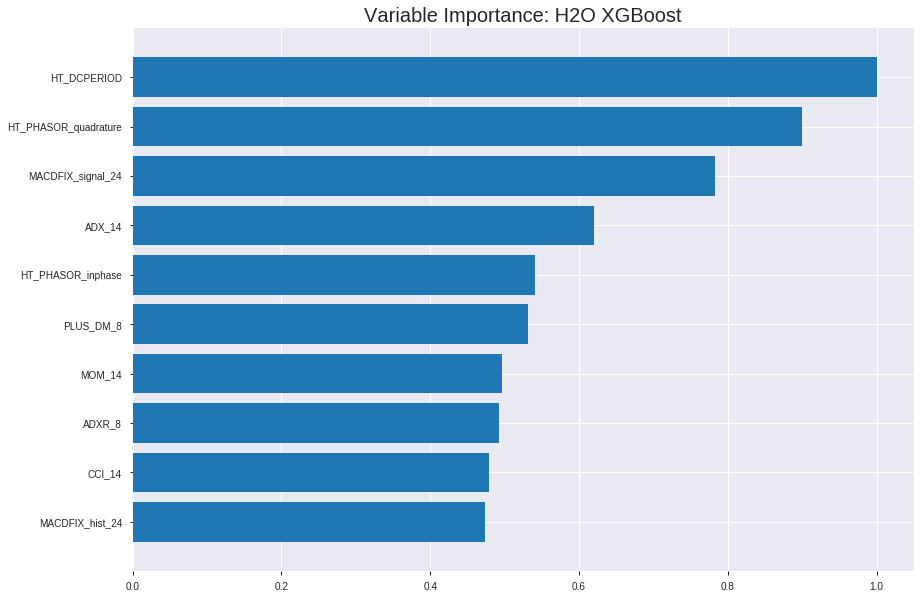

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_205813_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19253364118286762
RMSE: 0.43878655538070854
LogLoss: 0.574038293321413
Mean Per-Class Error: 0.16603891158346606
AUC: 0.9101260126012601
pr_auc: 0.930428967739787
Gini: 0.8202520252025203
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5637986660003662: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      547  168   0.235    (168.0/715.0)
1      110  900   0.1089   (110.0/1010.0)
Total  657  1068  0.1612   (278.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.563799     0.866218  216
max f2                       0.524748     0.912055  264
max f0point5                 0.586914     0.875725  185
max accuracy                 0.563799     0.838841  216
max precision                0.791362     1         0
max recall                   0.3806       1         370
max specificity              0.791362     1         0
max absolute_mcc             0.563799     0.665628  216
max min_per_class_accuracy   0.57638      0.829371  199
max mean_per_class_accuracy  0.574414     0.833961  202

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 57.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.75412            1.70792   1.70792            1                0.767531  1                           0.767531            0.0178218       0.0178218                  70.7921   70.7921
    2        0.0202899                   0.736392           1.70792   1.70792            1                0.744398  1                           0.756295            0.0168317       0.0346535                  70.7921   70.7921
    3        0.0301449                   0.72562            1.70792   1.70792            1                0.731349  1                           0.74814             0.0168317       0.0514851                  70.7921   70.7921
    4        0.04                        0.718511           1.70792   1.70792            1                0.72174   1                           0.741635            0.0168317       0.0683168                  70.7921   70.7921
    5        0.0504348                   0.713351           1.61304   1.68829            0.944444         0.715941  0.988506                    0.736319            0.0168317       0.0851485                  61.3036   68.829
    6        0.10029                     0.687818           1.6682    1.6783             0.976744         0.700346  0.982659                    0.718437            0.0831683       0.168317                   66.8202   67.8304
    7        0.150145                    0.667743           1.6682    1.67495            0.976744         0.676345  0.980695                    0.70446             0.0831683       0.251485                   66.8202   67.4949
    8        0.2                         0.649679           1.62848   1.66337            0.953488         0.659132  0.973913                    0.693161            0.0811881       0.332673                   62.8483   66.3366
    9        0.30029                     0.625454           1.56971   1.63209            0.919075         0.637518  0.955598                    0.674578            0.157426        0.490099                   56.9708   63.2086
    10       0.4                         0.60572            1.54904   1.61139            0.906977         0.615652  0.943478                    0.659889            0.154455        0.644554                   54.9044   61.1386
    11       0.50029                     0.587416           1.28341   1.54564            0.751445         0.596474  0.904983                    0.647176            0.128713        0.773267                   28.3409   54.5639
    12       0.6                         0.566917           0.983047  1.45215            0.575581         0.577424  0.850242                    0.635585            0.0980198       0.871287                   -1.69526  45.2145
    13       0.69971                     0.544749           0.744733  1.35134            0.436047         0.556569  0.791218                    0.624325            0.0742574       0.945545                   -25.5267  35.1337
    14       0.8                         0.511636           0.286299  1.21782            0.16763          0.530368  0.713043                    0.612546            0.0287129       0.974257                   -71.3701  21.7822
    15       0.89971                     0.459287           0.178736  1.10267            0.104651         0.488058  0.645619                    0.59875             0.0178218       0.992079                   -82.1264  10.2665
    16       1                           0.246706           0.078979  1                  0.0462428        0.399601  0.585507                    0.578777          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.30808154450479974
RMSE: 0.5550509386577053
LogLoss: 0.8230025090097453
Mean Per-Class Error: 0.464677047289504
AUC: 0.5186495013230206
pr_auc: 0.610378530190163
Gini: 0.037299002646041135
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1841021478176117: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    197  0.9657   (197.0/204.0)
1      2    287  0.0069   (2.0/289.0)
Total  9    484  0.4037   (199.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.184102     0.742561  392
max f2                       0.160341     0.876289  399
max f0point5                 0.184102     0.644944  392
max accuracy                 0.184102     0.596349  392
max precision                0.735108     1         0
max recall                   0.160341     1         399
max specificity              0.735108     1         0
max absolute_mcc             0.184102     0.100778  392
max min_per_class_accuracy   0.31457      0.49481   216
max mean_per_class_accuracy  0.270236     0.535323  282

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 35.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.676786           1.36471   1.36471            0.8              0.695615  0.8                         0.695615            0.0138408       0.0138408                  36.4706   36.4706
    2        0.020284                    0.633502           1.70588   1.53529            1                0.657302  0.9                         0.676459            0.017301        0.0311419                  70.5882   53.5294
    3        0.030426                    0.621928           1.02353   1.36471            0.6              0.627775  0.8                         0.660231            0.0103806       0.0415225                  2.35294   36.4706
    4        0.040568                    0.605204           0.682353  1.19412            0.4              0.613771  0.7                         0.648616            0.00692042      0.0484429                  -31.7647  19.4118
    5        0.0507099                   0.596196           1.70588   1.29647            1                0.601967  0.76                        0.639286            0.017301        0.0657439                  70.5882   29.6471
    6        0.10142                     0.559018           0.887059  1.09176            0.52             0.577926  0.64                        0.608606            0.0449827       0.110727                   -11.2941  9.17647
    7        0.150101                    0.524225           1.06618   1.08347            0.625            0.541806  0.635135                    0.586941            0.0519031       0.16263                    6.61765   8.34658
    8        0.200811                    0.487886           0.614118  0.964944           0.36             0.506786  0.565657                    0.5667              0.0311419       0.193772                   -38.5882  -3.50564
    9        0.300203                    0.39843            1.07923   1.00278            0.632653         0.437217  0.587838                    0.523831            0.107266        0.301038                   7.92317   0.278219
    10       0.399594                    0.351647           1.04442   1.01314            0.612245         0.372422  0.593909                    0.486171            0.103806        0.404844                   4.44178   1.31383
    11       0.501014                    0.311471           0.887059  0.987616           0.52             0.332781  0.578947                    0.45512             0.0899654       0.49481                    -11.2941  -1.23839
    12       0.600406                    0.289599           1.14886   1.01431            0.673469         0.300439  0.594595                    0.429514            0.114187        0.608997                   14.886    1.43084
    13       0.699797                    0.2681             1.14886   1.03342            0.673469         0.277643  0.605797                    0.407944            0.114187        0.723183                   14.886    3.34186
    14       0.799189                    0.247137           0.835534  1.00881            0.489796         0.25829   0.591371                    0.389332            0.083045        0.806228                   -16.4466  0.88086
    15       0.89858                     0.228694           1.11405   1.02045            0.653061         0.23817   0.598194                    0.372612            0.110727        0.916955                   11.4046   2.04488
    16       1                           0.160341           0.818824  1                  0.48             0.203362  0.586207                    0.355447      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 20:58:19  0.010 sec   0                  0.5              0.693147            0.5             0                  1                0.414493                         0.5                0.693147              0.5               0                    1                  0.413793
    2019-08-24 20:58:20  0.189 sec   5                  0.490855         0.674978            0.684563        0.754623           1.70792          0.36                             0.507727           0.708819              0.512891          0.591625             1.02353            0.40568
    2019-08-24 20:58:20  0.275 sec   10                 0.48367          0.660812            0.748759        0.80577            1.70792          0.325217                         0.51783            0.730189              0.500441          0.597525             1.02353            0.409736
    2019-08-24 20:58:20  0.376 sec   15                 0.477503         0.648708            0.781986        0.835072           1.70792          0.315942                         0.522594           0.740641              0.493317          0.595656             1.02353            0.407708
    2019-08-24 20:58:20  0.477 sec   20                 0.470549         0.635146            0.825844        0.868776           1.70792          0.266087                         0.522927           0.741463              0.511288          0.605372             1.36471            0.403651
    2019-08-24 20:58:20  0.561 sec   25                 0.465003         0.624344            0.851799        0.891714           1.70792          0.234783                         0.531801           0.761943              0.50921           0.606837             1.36471            0.393509
    2019-08-24 20:58:20  0.647 sec   30                 0.459887         0.614422            0.864371        0.899917           1.70792          0.21913                          0.540756           0.78389               0.516707          0.608798             1.70588            0.403651
    2019-08-24 20:58:20  0.736 sec   35                 0.454395         0.60379             0.879416        0.912119           1.70792          0.211014                         0.543397           0.790953              0.512789          0.609688             1.70588            0.403651
    2019-08-24 20:58:20  0.848 sec   40                 0.449792         0.594908            0.885326        0.916228           1.70792          0.198261                         0.550916           0.811319              0.519574          0.613842             1.70588            0.40568
    2019-08-24 20:58:20  0.963 sec   45                 0.443234         0.582514            0.903756        0.928001           1.70792          0.177971                         0.552318           0.815262              0.515189          0.610474             1.36471            0.403651
    2019-08-24 20:58:21  1.076 sec   50                 0.438787         0.574038            0.910126        0.930429           1.70792          0.161159                         0.555051           0.823003              0.51865           0.610379             1.36471            0.403651

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
HT_DCPERIOD              137.48348999023438     1.0                   0.037146336504797234
HT_PHASOR_quadrature     123.66888427734375     0.8995180751239884    0.03341380111070315
MACDFIX_signal_24        107.68640899658203     0.7832679327840102    0.02909553420461174
ADX_14                   85.34024047851562      0.6207308272766239    0.02305787618891864
HT_PHASOR_inphase        74.39369201660156      0.5411100054405503    0.020100254348207343
---                      ---                    ---                   ---
BBANDS_upperband_20_1_2  3.7138619422912598     0.0270131485791862    0.0010034395071765359
MACDFIX_20               3.434964179992676      0.024984557638423825  0.0009280847854603935
BBANDS_lowerband_14_3_2  2.9093399047851562     0.02116137657686614   0.0007860676152290038
BBANDS_upperband_24_3_5  2.5234029293060303     0.018354225147217827  0.000681792223603365
TRANGE                   1.4265460968017578     0.010376126594568462  0.00038543509009821583


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5303643724696356)

('F1', 0.6880000000000001)

('auc', 0.5051570095913809)

('logloss', 0.7815693377564294)

('mean_per_class_error', 0.47099592694783865)

('rmse', 0.5372707106859922)

('mse', 0.28865981656103107)

xgboost prediction progress: |████████████████████████████████████████████| 100%


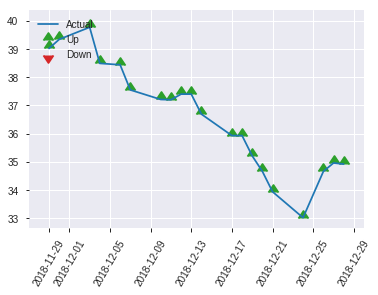


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.28865981656103107
RMSE: 0.5372707106859922
LogLoss: 0.7815693377564294
Mean Per-Class Error: 0.47099592694783865
AUC: 0.5051570095913809
pr_auc: 0.5410953760101345
Gini: 0.010314019182761758
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14499659836292267: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    117  0.9915   (117.0/118.0)
1      0    129  0        (0.0/129.0)
Total  1    246  0.4737   (117.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.144997     0.688     243
max f2                       0.144997     0.846457  243
max f0point5                 0.144997     0.579515  243
max accuracy                 0.276498     0.530364  192
max precision                0.640828     1         0
max recall                   0.144997     1         243
max specificity              0.640828     1         0
max absolute_mcc             0.62672      0.10605   2
max min_per_class_accuracy   0.320729     0.503876  121
max mean_per_class_accuracy  0.386883     0.529004  63

Gains/Lift Table: Avg response rate: 52.23 %, avg score: 34.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.626697           1.91473   1.91473            1                0.632283  1                           0.632283            0.0232558       0.0232558                  91.4729    91.4729
    2        0.0202429                   0.582812           0         1.14884            0                0.622261  0.6                         0.628274            0               0.0232558                  -100       14.8837
    3        0.0323887                   0.563695           1.91473   1.43605            1                0.572783  0.75                        0.607465            0.0232558       0.0465116                  91.4729    43.6047
    4        0.0404858                   0.556694           0         1.14884            0                0.560161  0.6                         0.598004            0               0.0465116                  -100       14.8837
    5        0.0526316                   0.548659           1.27649   1.17829            0.666667         0.554338  0.615385                    0.587927            0.0155039       0.0620155                  27.6486    17.8295
    6        0.101215                    0.491542           0.797804  0.995659           0.416667         0.520049  0.52                        0.555346            0.0387597       0.100775                   -20.2196   -0.434109
    7        0.149798                    0.464428           1.11693   1.03499            0.583333         0.479538  0.540541                    0.530759            0.0542636       0.155039                   11.6925    3.49885
    8        0.202429                    0.418245           1.17829   1.07225            0.615385         0.452654  0.56                        0.510452            0.0620155       0.217054                   17.8295    7.22481
    9        0.299595                    0.365159           0.957364  1.03499            0.5              0.391342  0.540541                    0.471822            0.0930233       0.310078                   -4.26357   3.49885
    10       0.40081                     0.342654           0.995659  1.02506            0.52             0.353706  0.535354                    0.441995            0.100775        0.410853                   -0.434109  2.50568
    11       0.502024                    0.31886            0.91907   1.00369            0.48             0.329609  0.524194                    0.419336            0.0930233       0.503876                   -8.09302   0.368842
    12       0.59919                     0.308799           0.877584  0.983239           0.458333         0.313049  0.513514                    0.4021              0.0852713       0.589147                   -12.2416   -1.67609
    13       0.700405                    0.295255           0.91907   0.973966           0.48             0.302681  0.508671                    0.387733            0.0930233       0.682171                   -8.09302   -2.6034
    14       0.797571                    0.275374           1.27649   1.01082            0.666667         0.283866  0.527919                    0.375079            0.124031        0.806202                   27.6486    1.08212
    15       0.898785                    0.240044           0.842481  0.991864           0.44             0.260485  0.518018                    0.362175            0.0852713       0.891473                   -15.7519   -0.813604
    16       1                           0.138255           1.07225   1                  0.56             0.193179  0.522267              

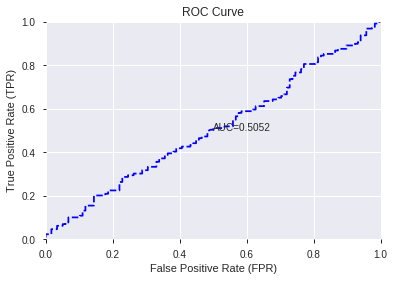

This function is available for GLM models only


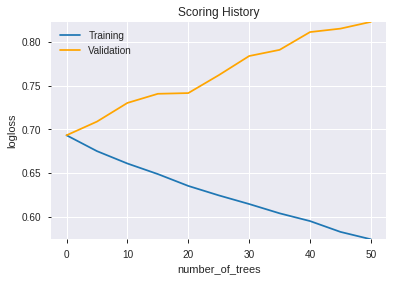

--2019-08-24 20:58:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.82.80
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.82.80|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_205813_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_205813_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_8405',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['HT_DCPERIOD',
 'HT_PHASOR_quadrature',
 'MACDFIX_signal_24',
 'ADX_14',
 'HT_PHASOR_inphase',
 'PLUS_DM_8',
 'MOM_14',
 'ADXR_8',
 'CCI_14',
 'MACDFIX_hist_24',
 'STOCHRSI_fastd',
 'ROCP_8',
 'AROONOSC_30',
 'STOCHRSI_fastk',
 'DX_8',
 'ULTOSC',
 'MACD_signal',
 'MACDEXT_signal',
 'MINUS_DM_24',
 'aroonup_24',
 'ADX_8',
 'MACDFIX_hist_20',
 'ATR_12',
 'STOCH_slowd',
 'APO',
 'ROCP_14',
 'BBANDS_lowerband_30_5_3',
 'ADX_24',
 'BBANDS_upperband_14_0_5',
 'STOCH_slowk',
 'ROCR_12',
 'MOM_24',
 'TRIX_12',
 'MACD_hist',
 'PLUS_DM_24',
 'ATR_30',
 'CCI_24',
 'MOM_30',
 'ROC_20',
 'WILLR_12',
 'BBANDS_upperband_30_7_5',
 'MAVP_12_5',
 'ROC_24',
 'MACDFIX_signal_20',
 'PLUS_DM_14',
 'ADXR_12',
 'DX_14',
 'DX_30',
 'MAVP_14_2',
 'WILLR_20',
 'MINUS_DM_20',
 'CMO_30',
 'BBANDS_upperband_14_1_4',
 'WILLR_30',
 'ROC_12',
 'BBANDS_lowerband_30_2_4',
 'WILLR_24',
 'CMO_14',
 'DX_24',
 'DX_12',
 'BBANDS_upperband_30_7_4',
 'aroondown_30',
 'CMO_8',
 'DX_20',
 'MINUS_DI_30',
 'BBANDS_upperband_30_5_

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.575
GLM             0.547
XGBoost         0.551
dtype: float64

DeepLearning    GLM  XGBoost
All          0.526  0.522    0.551
DLF          0.575  0.530    0.543
Fwe          0.567  0.522    0.551
RFE          0.559  0.547    0.530
XGBF         0.567  0.530    0.543





F1


DeepLearning    0.697
GLM             0.688
XGBoost         0.688
dtype: float64

DeepLearning    GLM  XGBoost
All          0.688  0.686    0.686
DLF          0.697  0.686    0.686
Fwe          0.686  0.686    0.686
RFE          0.686  0.688    0.688
XGBF         0.686  0.686    0.686





auc


DeepLearning    0.572
GLM             0.541
XGBoost         0.520
dtype: float64

DeepLearning    GLM  XGBoost
All          0.501  0.523    0.517
DLF          0.565  0.541    0.520
Fwe          0.572  0.523    0.517
RFE          0.509  0.530    0.505
XGBF         0.560  0.541    0.520





logloss


DeepLearning    16.762
GLM             17.625
XGBoost          0.793
dtype: float64

DeepLearning     GLM  XGBoost
All         16.163  17.625    0.729
DLF          3.124  17.307    0.793
Fwe         15.596  17.625    0.729
RFE          5.721   0.693    0.782
XGBF        16.762  17.307    0.793





mean_per_class_error


DeepLearning    0.495
GLM             0.476
XGBoost         0.471
dtype: float64

DeepLearning    GLM  XGBoost
All          0.495  0.476    0.446
DLF          0.422  0.458    0.450
Fwe          0.426  0.476    0.446
RFE          0.445  0.453    0.471
XGBF         0.426  0.458    0.450





rmse


DeepLearning    0.721
GLM             0.721
XGBoost         0.542
dtype: float64

DeepLearning    GLM  XGBoost
All          0.691  0.721    0.516
DLF          0.625  0.720    0.542
Fwe          0.721  0.721    0.516
RFE          0.687  0.500    0.537
XGBF         0.721  0.720    0.542





mse


DeepLearning    0.520
GLM             0.520
XGBoost         0.294
dtype: float64

DeepLearning    GLM  XGBoost
All          0.477  0.520    0.266
DLF          0.391  0.519    0.294
Fwe          0.520  0.520    0.266
RFE          0.472  0.250    0.289
XGBF         0.519  0.519    0.294

{'F1':       DeepLearning    GLM  XGBoost
 All          0.688    NaN      NaN
 DLF          0.697    NaN      NaN
 DLF            NaN  0.686      NaN
 DLF            NaN    NaN    0.686
 All            NaN  0.686      NaN
 All            NaN    NaN    0.686
 XGBF         0.686    NaN      NaN
 XGBF           NaN  0.686      NaN
 XGBF           NaN    NaN    0.686
 Fwe          0.686    NaN      NaN
 Fwe            NaN  0.686      NaN
 Fwe            NaN    NaN    0.686
 RFE          0.686    NaN      NaN
 RFE            NaN  0.688      NaN
 RFE            NaN    NaN    0.688,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.526    NaN      NaN
 DLF          0.575    NaN      NaN
 DLF            NaN  0.530      NaN
 DLF            NaN    NaN    0.543
 All            NaN  0.522      NaN
 All            NaN    NaN    0.551
 XGBF         0.567    NaN      NaN
 XGBF           NaN  0.530      NaN
 XGBF           NaN    NaN    0.543
 Fwe          0.567    NaN      NaN
 Fwe     